# Fine Tune Ensemble of LSTM Networks on Experimental Data
### Investigating whether starting with a model pretrained on simulated data improves performance

model number 1


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: 0.9952

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 21s 1s/step - loss: 0.9952 - val_loss: -0.9839
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8843

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 14s 956ms/step - loss: -0.8843 - val_loss: -1.0143
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9494

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9494 - val_loss: -1.0231
Epoch 4/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9493 - val_loss: -0.9864
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9518

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9518 - val_loss: -1.0326
Epoch 6/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9409 - val_loss: -0.8924
Epoch 7/2000
15/15 [==============================] - ETA: 0s - loss: -0.9149

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9149 - val_loss: -1.0365
Epoch 8/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9561 - val_loss: -0.9855
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9523

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9523 - val_loss: -1.0416
Epoch 10/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9552 - val_loss: -1.0326
Epoch 11/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9494 - val_loss: -0.9895
Epoch 12/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9513 - val_loss: -1.0319
Epoch 13/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9563 - val_loss: -1.0134
Epoch 14/2000
15/15 [==============================] - 3s 181ms/step - loss: -0.9577 - val_loss: -1.0404
Epoch 15/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9553 - val_loss: -1.0201
Epoch 16/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9485 - val_loss: -1.0023
Epoch 17/2000
15/15 [==============================] - ETA: 0s - loss: -0.9609

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9609 - val_loss: -1.0483
Epoch 18/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9633 - val_loss: -1.0250
Epoch 19/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9627 - val_loss: -1.0421
Epoch 20/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9640 - val_loss: -1.0252
Epoch 21/2000
15/15 [==============================] - ETA: 0s - loss: -0.9660

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9660 - val_loss: -1.0510
Epoch 22/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9537 - val_loss: -0.9917
Epoch 23/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9575 - val_loss: -1.0449
Epoch 24/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9658 - val_loss: -1.0436
Epoch 25/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9562 - val_loss: -1.0311
Epoch 26/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9608 - val_loss: -1.0372
Epoch 27/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9694 - val_loss: -1.0261
Epoch 28/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9529 - val_loss: -1.0394
Epoch 29/2000
15/15 [==============================] - ETA: 0s - loss: -0.9707

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9707 - val_loss: -1.0521
Epoch 30/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9585 - val_loss: -1.0196
Epoch 31/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9530 - val_loss: -1.0430
Epoch 32/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9705 - val_loss: -1.0472
Epoch 33/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9736 - val_loss: -1.0307
Epoch 34/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9624 - val_loss: -1.0412
Epoch 35/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9360 - val_loss: -0.9769
Epoch 36/2000
15/15 [==============================] - ETA: 0s - loss: -0.9530

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9530 - val_loss: -1.0535
Epoch 37/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9709 - val_loss: -1.0420
Epoch 38/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9709 - val_loss: -1.0495
Epoch 39/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9661 - val_loss: -1.0299
Epoch 40/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9656 - val_loss: -1.0355
Epoch 41/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9560 - val_loss: -1.0405
Epoch 42/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9693 - val_loss: -1.0466
Epoch 43/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9746 - val_loss: -1.0428
Epoch 44/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9667 - val_loss: -1.0257
Epoch 45/2000
15/15 [==============================] - 3s 189ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9794 - val_loss: -1.0723
Epoch 67/2000
15/15 [==============================] - ETA: 0s - loss: -1.0016

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.0016 - val_loss: -1.1388
Epoch 68/2000
15/15 [==============================] - ETA: 0s - loss: -1.1086

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.1086 - val_loss: -1.2379
Epoch 69/2000
15/15 [==============================] - ETA: 0s - loss: -1.1167

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.1167 - val_loss: -1.2517
Epoch 70/2000
15/15 [==============================] - ETA: 0s - loss: -1.3058

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.3058 - val_loss: -1.6506
Epoch 71/2000
15/15 [==============================] - ETA: 0s - loss: -1.6531

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.6531 - val_loss: -1.8239
Epoch 72/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7206 - val_loss: -1.6793
Epoch 73/2000
15/15 [==============================] - ETA: 0s - loss: -1.8730

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -1.8730 - val_loss: -1.9584
Epoch 74/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.9642 - val_loss: -1.6138
Epoch 75/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7243 - val_loss: -1.4192
Epoch 76/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.7532 - val_loss: -1.8657
Epoch 77/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.0066 - val_loss: -1.6613
Epoch 78/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.9120 - val_loss: -1.9025
Epoch 79/2000
15/15 [==============================] - ETA: 0s - loss: -2.0863

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.0863 - val_loss: -2.0971
Epoch 80/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.1489 - val_loss: -1.6591
Epoch 81/2000
15/15 [==============================] - ETA: 0s - loss: -2.1653

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.1653 - val_loss: -2.2103
Epoch 82/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.1028 - val_loss: -2.0651
Epoch 83/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.1544 - val_loss: -2.1871
Epoch 84/2000
15/15 [==============================] - ETA: 0s - loss: -2.2100

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.2100 - val_loss: -2.3906
Epoch 85/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.2284 - val_loss: -2.3264
Epoch 86/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2633 - val_loss: -2.1004
Epoch 87/2000
15/15 [==============================] - 3s 200ms/step - loss: -1.8625 - val_loss: -2.0771
Epoch 88/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.9061 - val_loss: -1.9106
Epoch 89/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.1150 - val_loss: -2.2170
Epoch 90/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.1410 - val_loss: -1.5785
Epoch 91/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.1202 - val_loss: -2.1717
Epoch 92/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2878 - val_loss: -2.2855
Epoch 93/2000
15/15 [==============================] - 3s 189ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.2723 - val_loss: -2.4149
Epoch 97/2000
15/15 [==============================] - ETA: 0s - loss: -2.3866

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3866 - val_loss: -2.4150
Epoch 98/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.1036 - val_loss: -1.8356
Epoch 99/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.9398 - val_loss: -1.9649
Epoch 100/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0688 - val_loss: -2.0590
Epoch 101/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.1972 - val_loss: -2.2842
Epoch 102/2000
15/15 [==============================] - ETA: 0s - loss: -2.3886

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3886 - val_loss: -2.4854
Epoch 103/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.3799 - val_loss: -1.8280
Epoch 104/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3082 - val_loss: -2.4545
Epoch 105/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4218 - val_loss: -2.1092
Epoch 106/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2208 - val_loss: -2.3352
Epoch 107/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3466 - val_loss: -2.3334
Epoch 108/2000
15/15 [==============================] - ETA: 0s - loss: -2.4136

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4136 - val_loss: -2.5584
Epoch 109/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.4507 - val_loss: -1.7703
Epoch 110/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2900 - val_loss: -2.5101
Epoch 111/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3280 - val_loss: -2.2748
Epoch 112/2000
15/15 [==============================] - ETA: 0s - loss: -2.4247

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4247 - val_loss: -2.6048
Epoch 113/2000
15/15 [==============================] - ETA: 0s - loss: -2.5474

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5474 - val_loss: -2.6974
Epoch 114/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4548 - val_loss: -2.6903
Epoch 115/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5609 - val_loss: -2.2601
Epoch 116/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.4998 - val_loss: -2.3351
Epoch 117/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.5677 - val_loss: -2.6062
Epoch 118/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.5601 - val_loss: -2.6923
Epoch 119/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.3274 - val_loss: -2.4582
Epoch 120/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4662 - val_loss: -2.6169
Epoch 121/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.6524 - val_loss: -2.6655
Epoch 122/2000
15/15 [==============================] - 3s 184m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5618 - val_loss: -2.7370
Epoch 125/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.6698 - val_loss: -1.7650
Epoch 126/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.3819 - val_loss: -2.6719
Epoch 127/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.6208 - val_loss: -2.5632
Epoch 128/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.4956 - val_loss: -2.3086
Epoch 129/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.5215 - val_loss: -2.7368
Epoch 130/2000
15/15 [==============================] - ETA: 0s - loss: -2.6110

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.6110 - val_loss: -2.8197
Epoch 131/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8095 - val_loss: -2.7554
Epoch 132/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.6400 - val_loss: -2.7763
Epoch 133/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.6994 - val_loss: -2.7434
Epoch 134/2000
15/15 [==============================] - ETA: 0s - loss: -2.6715

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.6715 - val_loss: -2.8944
Epoch 135/2000
15/15 [==============================] - ETA: 0s - loss: -2.8231

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.8231 - val_loss: -2.9692
Epoch 136/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7837 - val_loss: -2.9298
Epoch 137/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.8560 - val_loss: -2.8551
Epoch 138/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.8011 - val_loss: -2.7907
Epoch 139/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.7628 - val_loss: -2.8807
Epoch 140/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.4649 - val_loss: -2.6636
Epoch 141/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.6202 - val_loss: -2.7562
Epoch 142/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7028 - val_loss: -2.9138
Epoch 143/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7507 - val_loss: -2.9564
Epoch 144/2000
15/15 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.8856 - val_loss: -3.0169
Epoch 145/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.8842 - val_loss: -2.9150
Epoch 146/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.7350 - val_loss: -1.9386
Epoch 147/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.7971 - val_loss: -2.6614
Epoch 148/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7716 - val_loss: -2.8729
Epoch 149/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7227 - val_loss: -1.6297
Epoch 150/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4017 - val_loss: -2.6713
Epoch 151/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.7214 - val_loss: -2.8339
Epoch 152/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.8737 - val_loss: -3.0071
Epoch 153/2000
15/15 [==============================] - 3s 195m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7577 - val_loss: -3.0285
Epoch 157/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7075 - val_loss: -2.9272
Epoch 158/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7283 - val_loss: -2.9875
Epoch 159/2000
15/15 [==============================] - ETA: 0s - loss: -2.9554

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.9554 - val_loss: -3.0629
Epoch 160/2000
15/15 [==============================] - ETA: 0s - loss: -3.0280

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0280 - val_loss: -3.0789
Epoch 161/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.8246 - val_loss: -3.0643
Epoch 162/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.8341 - val_loss: -2.9897
Epoch 163/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0053 - val_loss: -2.7533
Epoch 164/2000
15/15 [==============================] - ETA: 0s - loss: -2.7679

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7679 - val_loss: -3.1046
Epoch 165/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9145 - val_loss: -3.0732
Epoch 166/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0120 - val_loss: -3.1003
Epoch 167/2000
15/15 [==============================] - ETA: 0s - loss: -2.8245

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -2.8245 - val_loss: -3.1541
Epoch 168/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.6658 - val_loss: -2.5584
Epoch 169/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.7227 - val_loss: -2.7070
Epoch 170/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.7615 - val_loss: -2.7597
Epoch 171/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7453 - val_loss: -3.0177
Epoch 172/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.7925 - val_loss: -2.9023
Epoch 173/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.8743 - val_loss: -1.6385
Epoch 174/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.6597 - val_loss: -2.8253
Epoch 175/2000
15/15 [==============================] - 3s 202ms/step - loss: -2.9483 - val_loss: -3.0881
Epoch 176/2000
15/15 [==============================] - 3s 193m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0785 - val_loss: -3.1585
Epoch 187/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1508 - val_loss: -3.0909
Epoch 188/2000
15/15 [==============================] - ETA: 0s - loss: -2.7545

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7545 - val_loss: -3.1651
Epoch 189/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.6005 - val_loss: -2.7194
Epoch 190/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7648 - val_loss: -2.9085
Epoch 191/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.9603 - val_loss: -3.0751
Epoch 192/2000
15/15 [==============================] - ETA: 0s - loss: -3.0745

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 14s 982ms/step - loss: -3.0745 - val_loss: -3.1737
Epoch 193/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.0038 - val_loss: -3.1628
Epoch 194/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0439 - val_loss: -3.0650
Epoch 195/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0367 - val_loss: -3.1272
Epoch 196/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.1291 - val_loss: -3.1257
Epoch 197/2000
15/15 [==============================] - ETA: 0s - loss: -3.1193

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1193 - val_loss: -3.1866
Epoch 198/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.8980 - val_loss: -2.9040
Epoch 199/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.9700 - val_loss: -3.0937
Epoch 200/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0693 - val_loss: -3.1607
Epoch 201/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.0800 - val_loss: -2.8731
Epoch 202/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7254 - val_loss: -2.9691
Epoch 203/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9877 - val_loss: -3.1285
Epoch 204/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1408 - val_loss: -3.1507
Epoch 205/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.5960 - val_loss: -2.5571
Epoch 206/2000
15/15 [==============================] - 3s 197m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0085 - val_loss: -3.2000
Epoch 211/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0760 - val_loss: -3.0903
Epoch 212/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1227 - val_loss: -3.1599
Epoch 213/2000
15/15 [==============================] - 3s 207ms/step - loss: -3.0895 - val_loss: -2.7827
Epoch 214/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1769 - val_loss: -3.1942
Epoch 215/2000
15/15 [==============================] - ETA: 0s - loss: -3.0991

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0991 - val_loss: -3.2663
Epoch 216/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.2343 - val_loss: -3.2524
Epoch 217/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0425 - val_loss: -2.9251
Epoch 218/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.8878 - val_loss: -3.0994
Epoch 219/2000
15/15 [==============================] - 3s 183ms/step - loss: -3.0222 - val_loss: -2.9433
Epoch 220/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.0191 - val_loss: -3.1077
Epoch 221/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1023 - val_loss: -3.2255
Epoch 222/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1647 - val_loss: -3.2226
Epoch 223/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0142 - val_loss: -3.2309
Epoch 224/2000
15/15 [==============================] - 3s 193m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2373 - val_loss: -3.2855
Epoch 247/2000
15/15 [==============================] - ETA: 0s - loss: -3.2681

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2681 - val_loss: -3.3107
Epoch 248/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0693 - val_loss: -2.1510
Epoch 249/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.4827 - val_loss: -2.7967
Epoch 250/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.6610 - val_loss: -2.6501
Epoch 251/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7811 - val_loss: -2.9871
Epoch 252/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.0323 - val_loss: -3.1315
Epoch 253/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1770 - val_loss: -3.1813
Epoch 254/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0763 - val_loss: -3.2068
Epoch 255/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.9970 - val_loss: -1.5522
Epoch 256/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2558 - val_loss: -3.3176
Epoch 289/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.2202 - val_loss: -3.2086
Epoch 290/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2541 - val_loss: -3.3022
Epoch 291/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.2582 - val_loss: -2.9469
Epoch 292/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2188 - val_loss: -3.2685
Epoch 293/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0006 - val_loss: -2.6134
Epoch 294/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1988 - val_loss: -3.1991
Epoch 295/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2858 - val_loss: -2.9105
Epoch 296/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.0130 - val_loss: -2.0398
Epoch 297/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2735 - val_loss: -3.3437
Epoch 302/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.3505 - val_loss: -3.2514
Epoch 303/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3601 - val_loss: -3.3052
Epoch 304/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2121 - val_loss: -2.8304
Epoch 305/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2248 - val_loss: -3.2797
Epoch 306/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3380 - val_loss: -2.9127
Epoch 307/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1808 - val_loss: -3.2694
Epoch 308/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2432 - val_loss: -3.2162
Epoch 309/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.3547 - val_loss: -3.1996
Epoch 310/2000
15/15 [==============================] - 3s 194m

15/15 [==============================] - 3s 190ms/step - loss: -3.4941 - val_loss: -3.2182
Epoch 456/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4077 - val_loss: -2.6403
Epoch 457/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2787 - val_loss: -3.1271
Epoch 458/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4838 - val_loss: -3.2216
Epoch 459/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3648 - val_loss: -3.2873
Epoch 460/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5957 - val_loss: -3.1313
Epoch 461/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5998 - val_loss: -3.1217
Epoch 462/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6473 - val_loss: -2.9075
Epoch 463/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4373 - val_loss: -2.8532
Epoch 464/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2192 - val_loss: -3.3448
Epoch 548/2000
15/15 [==============================] - ETA: 0s - loss: -3.2353

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2353 - val_loss: -3.3462
Epoch 549/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.2471 - val_loss: -3.0705
Epoch 550/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3069 - val_loss: -3.3289
Epoch 551/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2964 - val_loss: -3.1681
Epoch 552/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3535 - val_loss: -2.8873
Epoch 553/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3593 - val_loss: -3.0649
Epoch 554/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3999 - val_loss: -3.2770
Epoch 555/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3242 - val_loss: -3.1350
Epoch 556/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0403 - val_loss: -3.0106
Epoch 557/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1931 - val_loss: -3.3475
Epoch 581/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.4880 - val_loss: -3.3143
Epoch 582/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5558 - val_loss: -3.2924
Epoch 583/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3287 - val_loss: -2.9004
Epoch 584/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2246 - val_loss: -2.5683
Epoch 585/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3474 - val_loss: -3.1346
Epoch 586/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.4631 - val_loss: -2.9555
Epoch 587/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.5146 - val_loss: -3.1101
Epoch 588/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5577 - val_loss: -3.1786
Epoch 589/2000
15/15 [==============================] - 3s 193m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.4599 - val_loss: -3.3833
Epoch 688/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6328 - val_loss: -3.2143
Epoch 689/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7095 - val_loss: -3.2350
Epoch 690/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6516 - val_loss: -2.9443
Epoch 691/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6455 - val_loss: -3.2201
Epoch 692/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.4449 - val_loss: -1.9334
Epoch 693/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5049 - val_loss: -3.1667
Epoch 694/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.5175 - val_loss: -3.3023
Epoch 695/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6241 - val_loss: -3.2070
Epoch 696/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 15s 1s/step - loss: -3.7147 - val_loss: -3.4083
Epoch 831/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6139 - val_loss: -3.1487
Epoch 832/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.2840 - val_loss: -3.0691
Epoch 833/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4169 - val_loss: -3.3143
Epoch 834/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6636 - val_loss: -3.2288
Epoch 835/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7121 - val_loss: -3.2178
Epoch 836/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6759 - val_loss: -2.8404
Epoch 837/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7650 - val_loss: -3.1179
Epoch 838/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7592 - val_loss: -3.0892
Epoch 839/2000
15/15 [==============================] - 3s 188m

15/15 [==============================] - 3s 190ms/step - loss: -3.7550 - val_loss: -3.3787
Epoch 985/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8734 - val_loss: -3.1445
Epoch 986/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9243 - val_loss: -2.9125
Epoch 987/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.8786 - val_loss: -2.1031
Epoch 988/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1363 - val_loss: -2.7723
Epoch 989/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.3670 - val_loss: -3.2885
Epoch 990/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6087 - val_loss: -3.3589
Epoch 991/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6943 - val_loss: -2.9070
Epoch 992/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7581 - val_loss: -3.2348
Epoch 993/2000
15/15 [==============================] - 3s 19

Epoch 1061/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.7278 - val_loss: -2.4872
Epoch 1062/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8529 - val_loss: -2.2674
Epoch 1063/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8980 - val_loss: -2.4742
Epoch 1064/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5882 - val_loss: -2.8748
Epoch 1065/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7240 - val_loss: -3.2916
Epoch 1066/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7768 - val_loss: -3.2444
Epoch 1067/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8645 - val_loss: -2.9698
Epoch 1068/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9210 - val_loss: -2.7556
Epoch 1069/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.6744 - val_loss: -2.6903
Epoch 1070/2000
15/15 [==============

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 16s 1s/step - loss: -3.5462 - val_loss: -3.4085
Epoch 1110/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.5713 - val_loss: -3.1132
Epoch 1111/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1156 - val_loss: -3.2245
Epoch 1112/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4423 - val_loss: -3.3309
Epoch 1113/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5131 - val_loss: -3.3787
Epoch 1114/2000
15/15 [==============================] - ETA: 0s - loss: -3.6721

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel1/assets


15/15 [==============================] - 14s 982ms/step - loss: -3.6721 - val_loss: -3.4165
Epoch 1115/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7612 - val_loss: -3.2862
Epoch 1116/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.8335 - val_loss: -3.2520
Epoch 1117/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.7887 - val_loss: -3.1210
Epoch 1118/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4629 - val_loss: -2.8637
Epoch 1119/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5143 - val_loss: -3.1176
Epoch 1120/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5485 - val_loss: -2.6120
Epoch 1121/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5810 - val_loss: -3.3729
Epoch 1122/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6017 - val_loss: -3.3642
Epoch 1123/2000
15/15 [=============================

15/15 [==============================] - 3s 193ms/step - loss: -3.2639 - val_loss: -3.2403
Epoch 1267/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6092 - val_loss: -3.0653
Epoch 1268/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6122 - val_loss: -3.1618
Epoch 1269/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3841 - val_loss: -2.9450
Epoch 1270/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1149 - val_loss: -2.6398
Epoch 1271/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0803 - val_loss: -3.0661
Epoch 1272/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3964 - val_loss: -3.0910
Epoch 1273/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.4166 - val_loss: -3.0351
Epoch 1274/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.5377 - val_loss: -3.1556
Epoch 1275/2000
15/15 [==============================

15/15 [==============================] - 3s 193ms/step - loss: -3.8035 - val_loss: 0.6598
Epoch 1419/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4972 - val_loss: -0.2178
Epoch 1420/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2893 - val_loss: -2.0231
Epoch 1421/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6160 - val_loss: -0.3789
Epoch 1422/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8198 - val_loss: -1.3727
Epoch 1423/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.7447 - val_loss: -1.5973
Epoch 1424/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7260 - val_loss: -1.3560
Epoch 1425/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8423 - val_loss: -0.0727
Epoch 1426/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.7830 - val_loss: -0.7778
Epoch 1427/2000
15/15 [==============================]

15/15 [==============================] - 3s 192ms/step - loss: -3.7060 - val_loss: -2.8054
Epoch 1571/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.8584 - val_loss: -2.6570
Epoch 1572/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9865 - val_loss: -2.1970
Epoch 1573/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.9090 - val_loss: -2.3556
Epoch 1574/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6376 - val_loss: -2.6231
Epoch 1575/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9187 - val_loss: -2.6089
Epoch 1576/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.0941 - val_loss: -1.8817
Epoch 1577/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9828 - val_loss: -1.7503
Epoch 1578/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8641 - val_loss: -1.8827
Epoch 1579/2000
15/15 [==============================

15/15 [==============================] - 3s 194ms/step - loss: -4.0365 - val_loss: 2.2517
Epoch 1723/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8064 - val_loss: -0.6257
Epoch 1724/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.9014 - val_loss: -1.1544
Epoch 1725/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0639 - val_loss: 0.3810
Epoch 1726/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0118 - val_loss: 1.9026
Epoch 1727/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7814 - val_loss: -0.9093
Epoch 1728/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.9357 - val_loss: -1.3523
Epoch 1729/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.9603 - val_loss: -0.8820
Epoch 1730/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.1250 - val_loss: -0.8268
Epoch 1731/2000
15/15 [==============================] -

Epoch 1799/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.8389 - val_loss: -2.2192
Epoch 1800/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.0303 - val_loss: -1.9421
Epoch 1801/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0888 - val_loss: -1.9197
Epoch 1802/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1752 - val_loss: -0.5807
Epoch 1803/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7567 - val_loss: -1.5452
Epoch 1804/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.1406 - val_loss: -2.6313
Epoch 1805/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5695 - val_loss: -2.8835
Epoch 1806/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8872 - val_loss: -2.4300
Epoch 1807/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.0654 - val_loss: -1.6194
Epoch 1808/2000
15/15 [==============

Epoch 1876/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.0244 - val_loss: 0.2972
Epoch 1877/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.8951 - val_loss: 0.0790
Epoch 1878/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9408 - val_loss: 0.7894
Epoch 1879/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0079 - val_loss: 1.2875
Epoch 1880/2000
15/15 [==============================] - 3s 185ms/step - loss: -4.2135 - val_loss: 4.3086
Epoch 1881/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.3298 - val_loss: 4.6196
Epoch 1882/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.2859 - val_loss: 7.2620
Epoch 1883/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.0772 - val_loss: 4.7641
Epoch 1884/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.9341 - val_loss: 1.5831
Epoch 1885/2000
15/15 [=======================

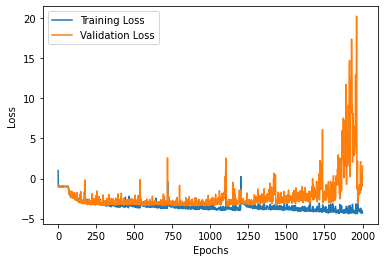

20/20 [==============================] - 1s 50ms/step - loss: -2.8224


20/20 [==============================] - 3s 46ms/step - loss: -3.6587
model number 2


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.4074

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 20s 1s/step - loss: -0.4074 - val_loss: -0.8802
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.7550

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.7550 - val_loss: -1.0000
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9351

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9351 - val_loss: -1.0138
Epoch 4/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9423 - val_loss: -1.0071
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9541

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9541 - val_loss: -1.0282
Epoch 6/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9301 - val_loss: -0.8946
Epoch 7/2000
15/15 [==============================] - ETA: 0s - loss: -0.9141

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9141 - val_loss: -1.0365
Epoch 8/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9582 - val_loss: -0.9870
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9530

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9530 - val_loss: -1.0424
Epoch 10/2000
15/15 [==============================] - ETA: 0s - loss: -0.9687

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9687 - val_loss: -1.0576
Epoch 11/2000
15/15 [==============================] - ETA: 0s - loss: -1.0226

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -1.0226 - val_loss: -1.1950
Epoch 12/2000
15/15 [==============================] - ETA: 0s - loss: -1.4031

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 14s 973ms/step - loss: -1.4031 - val_loss: -1.6673
Epoch 13/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.4926 - val_loss: -1.5570
Epoch 14/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.2653 - val_loss: -0.7578
Epoch 15/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.0912 - val_loss: -1.1883
Epoch 16/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.3980 - val_loss: -1.5615
Epoch 17/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.6892 - val_loss: -1.5843
Epoch 18/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.6857 - val_loss: -1.6479
Epoch 19/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.4385 - val_loss: -1.5954
Epoch 20/2000
15/15 [==============================] - ETA: 0s - loss: -1.6017

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 16s 1s/step - loss: -1.6017 - val_loss: -1.7488
Epoch 21/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.6623 - val_loss: -1.6382
Epoch 22/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.7428 - val_loss: -1.6256
Epoch 23/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9558 - val_loss: -1.0262
Epoch 24/2000
15/15 [==============================] - 3s 184ms/step - loss: -0.9164 - val_loss: -0.9347
Epoch 25/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9075 - val_loss: -0.9933
Epoch 26/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9561 - val_loss: -1.0399
Epoch 27/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9866 - val_loss: -1.0706
Epoch 28/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.0344 - val_loss: -0.9478
Epoch 29/2000
15/15 [==============================] - 3s 193ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -1.8002 - val_loss: -1.7489
Epoch 36/2000
15/15 [==============================] - 3s 199ms/step - loss: -1.8321 - val_loss: -1.6120
Epoch 37/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.8683 - val_loss: -1.4850
Epoch 38/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.8131 - val_loss: -1.5431
Epoch 39/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.7532 - val_loss: -1.6280
Epoch 40/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.8237 - val_loss: -1.5983
Epoch 41/2000
15/15 [==============================] - 3s 184ms/step - loss: -1.8422 - val_loss: -1.5744
Epoch 42/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8352 - val_loss: -1.5945
Epoch 43/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7967 - val_loss: -1.6180
Epoch 44/2000
15/15 [==============================] - 3s 185ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -1.8945 - val_loss: -1.8937
Epoch 47/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.8605 - val_loss: -1.5903
Epoch 48/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.8726 - val_loss: -1.6173
Epoch 49/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.8517 - val_loss: -1.7424
Epoch 50/2000
15/15 [==============================] - ETA: 0s - loss: -1.9699

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -1.9699 - val_loss: -2.0314
Epoch 51/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.1459 - val_loss: -1.9905
Epoch 52/2000
15/15 [==============================] - ETA: 0s - loss: -2.1020

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.1020 - val_loss: -2.2140
Epoch 53/2000
15/15 [==============================] - ETA: 0s - loss: -2.3058

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3058 - val_loss: -2.2807
Epoch 54/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3866 - val_loss: -1.9441
Epoch 55/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2295 - val_loss: -1.9956
Epoch 56/2000
15/15 [==============================] - ETA: 0s - loss: -2.3520

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3520 - val_loss: -2.3908
Epoch 57/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.5102 - val_loss: -2.3022
Epoch 58/2000
15/15 [==============================] - ETA: 0s - loss: -2.4288

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4288 - val_loss: -2.4840
Epoch 59/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4714 - val_loss: -2.4674
Epoch 60/2000
15/15 [==============================] - ETA: 0s - loss: -2.4730

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4730 - val_loss: -2.5130
Epoch 61/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.3857 - val_loss: -2.2132
Epoch 62/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3763 - val_loss: -2.3311
Epoch 63/2000
15/15 [==============================] - ETA: 0s - loss: -2.5411

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5411 - val_loss: -2.7638
Epoch 64/2000
15/15 [==============================] - ETA: 0s - loss: -2.6199

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.6199 - val_loss: -2.8404
Epoch 65/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7959 - val_loss: 0.7283
Epoch 66/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0125 - val_loss: -2.3836
Epoch 67/2000
15/15 [==============================] - 3s 183ms/step - loss: -2.3842 - val_loss: -2.4622
Epoch 68/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.5914 - val_loss: -2.7699
Epoch 69/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.6758 - val_loss: -2.6890
Epoch 70/2000
15/15 [==============================] - ETA: 0s - loss: -2.7584

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7584 - val_loss: -2.9131
Epoch 71/2000
15/15 [==============================] - ETA: 0s - loss: -2.7775

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7775 - val_loss: -2.9787
Epoch 72/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.6921 - val_loss: -2.9511
Epoch 73/2000
15/15 [==============================] - ETA: 0s - loss: -2.9362

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 14s 980ms/step - loss: -2.9362 - val_loss: -3.0830
Epoch 74/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.9848 - val_loss: -2.9559
Epoch 75/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8185 - val_loss: -3.0058
Epoch 76/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.9096 - val_loss: -2.9304
Epoch 77/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.9322 - val_loss: -2.5849
Epoch 78/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.8981 - val_loss: -2.8054
Epoch 79/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.8604 - val_loss: -2.9124
Epoch 80/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0042 - val_loss: -2.9363
Epoch 81/2000
15/15 [==============================] - ETA: 0s - loss: -3.0014

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 16s 1s/step - loss: -3.0014 - val_loss: -3.1302
Epoch 82/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9431 - val_loss: -3.1172
Epoch 83/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.9222 - val_loss: -3.0557
Epoch 84/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0137 - val_loss: -2.9090
Epoch 85/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.9936 - val_loss: -2.9443
Epoch 86/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0374 - val_loss: -3.0550
Epoch 87/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0203 - val_loss: -3.0121
Epoch 88/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9084 - val_loss: -2.9304
Epoch 89/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.9139 - val_loss: -2.6300
Epoch 90/2000
15/15 [==============================] - 3s 187ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1257 - val_loss: -3.1375
Epoch 99/2000
15/15 [==============================] - ETA: 0s - loss: -3.0710

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0710 - val_loss: -3.1684
Epoch 100/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0946 - val_loss: -3.0724
Epoch 101/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.9809 - val_loss: -2.8958
Epoch 102/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.0741 - val_loss: -3.1670
Epoch 103/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.1052 - val_loss: -3.1447
Epoch 104/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0901 - val_loss: -2.6502
Epoch 105/2000
15/15 [==============================] - 3s 201ms/step - loss: -2.8526 - val_loss: -2.7321
Epoch 106/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.9822 - val_loss: -3.1149
Epoch 107/2000
15/15 [==============================] - ETA: 0s - loss: -3.1324

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1324 - val_loss: -3.1981
Epoch 108/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.1077 - val_loss: -3.1863
Epoch 109/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1296 - val_loss: -3.1830
Epoch 110/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1283 - val_loss: -2.5975
Epoch 111/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9133 - val_loss: -3.0081
Epoch 112/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.1064 - val_loss: -2.7931
Epoch 113/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0569 - val_loss: -3.1229
Epoch 114/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1858 - val_loss: -3.1679
Epoch 115/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.8452 - val_loss: -2.8663
Epoch 116/2000
15/15 [==============================] - 3s 200m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2031 - val_loss: -3.2162
Epoch 127/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.3033 - val_loss: -3.0911
Epoch 128/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7216 - val_loss: -2.6828
Epoch 129/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.0171 - val_loss: -2.9952
Epoch 130/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1733 - val_loss: -2.9522
Epoch 131/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.2122 - val_loss: -3.2025
Epoch 132/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.2337 - val_loss: -3.0814
Epoch 133/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.1240 - val_loss: -2.8382
Epoch 134/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0601 - val_loss: -3.0823
Epoch 135/2000
15/15 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2202 - val_loss: -3.2686
Epoch 136/2000
15/15 [==============================] - ETA: 0s - loss: -3.2669

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2669 - val_loss: -3.3109
Epoch 137/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3508 - val_loss: -2.8958
Epoch 138/2000
15/15 [==============================] - 3s 183ms/step - loss: -3.1571 - val_loss: -2.8537
Epoch 139/2000
15/15 [==============================] - ETA: 0s - loss: -3.1890

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1890 - val_loss: -3.3301
Epoch 140/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3207 - val_loss: -3.1337
Epoch 141/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3130 - val_loss: -3.2336
Epoch 142/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3791 - val_loss: -3.0678
Epoch 143/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2761 - val_loss: -2.9976
Epoch 144/2000
15/15 [==============================] - ETA: 0s - loss: -3.3636

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.3636 - val_loss: -3.3654
Epoch 145/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3721 - val_loss: -3.2118
Epoch 146/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1839 - val_loss: -2.9177
Epoch 147/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.6840 - val_loss: -2.8432
Epoch 148/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0618 - val_loss: -3.1932
Epoch 149/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0441 - val_loss: -3.1765
Epoch 150/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.9530 - val_loss: -2.9603
Epoch 151/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0956 - val_loss: -3.2187
Epoch 152/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2533 - val_loss: -3.2579
Epoch 153/2000
15/15 [==============================] - 3s 192m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.4222 - val_loss: -3.3744
Epoch 202/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4885 - val_loss: -3.3022
Epoch 203/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.5257 - val_loss: -2.8605
Epoch 204/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4039 - val_loss: -2.8937
Epoch 205/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1553 - val_loss: -3.0646
Epoch 206/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3976 - val_loss: -3.2846
Epoch 207/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5069 - val_loss: -3.3323
Epoch 208/2000
15/15 [==============================] - ETA: 0s - loss: -3.5220

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.5220 - val_loss: -3.3911
Epoch 209/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5891 - val_loss: -3.1529
Epoch 210/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4047 - val_loss: -3.3757
Epoch 211/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5052 - val_loss: -3.1173
Epoch 212/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3392 - val_loss: -3.2601
Epoch 213/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4916 - val_loss: -3.3331
Epoch 214/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.6422 - val_loss: -3.2543
Epoch 215/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.6218 - val_loss: -3.0793
Epoch 216/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6523 - val_loss: -3.3232
Epoch 217/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.5439 - val_loss: -3.3978
Epoch 221/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5058 - val_loss: -3.3408
Epoch 222/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6098 - val_loss: -3.2048
Epoch 223/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5695 - val_loss: -3.1293
Epoch 224/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.6037 - val_loss: -3.3029
Epoch 225/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.4612 - val_loss: -2.8698
Epoch 226/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4699 - val_loss: -3.2192
Epoch 227/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4091 - val_loss: -3.3282
Epoch 228/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1831 - val_loss: -3.2241
Epoch 229/2000
15/15 [==============================] - 3s 197m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 15s 1s/step - loss: -3.6028 - val_loss: -3.3980
Epoch 263/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5037 - val_loss: -3.3368
Epoch 264/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5942 - val_loss: -3.2414
Epoch 265/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6671 - val_loss: -3.3918
Epoch 266/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6801 - val_loss: -3.2948
Epoch 267/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.7334 - val_loss: -2.8424
Epoch 268/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5292 - val_loss: -3.0075
Epoch 269/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5881 - val_loss: -2.9355
Epoch 270/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6377 - val_loss: -3.1388
Epoch 271/2000
15/15 [==============================] - 3s 194m

15/15 [==============================] - 3s 184ms/step - loss: -3.4693 - val_loss: -3.0390
Epoch 417/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6090 - val_loss: -2.8620
Epoch 418/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6980 - val_loss: -2.9761
Epoch 419/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.6277 - val_loss: -3.1623
Epoch 420/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6125 - val_loss: -3.0527
Epoch 421/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7161 - val_loss: -3.0228
Epoch 422/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4658 - val_loss: -3.2055
Epoch 423/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4587 - val_loss: -3.2015
Epoch 424/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5847 - val_loss: -3.3361
Epoch 425/2000
15/15 [==============================] - 3s 18

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel2/assets


15/15 [==============================] - 14s 984ms/step - loss: -3.8063 - val_loss: -3.4058
Epoch 464/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7446 - val_loss: -3.3299
Epoch 465/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.5201 - val_loss: -3.4040
Epoch 466/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6649 - val_loss: -3.3048
Epoch 467/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8241 - val_loss: -3.1342
Epoch 468/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9046 - val_loss: -2.6709
Epoch 469/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.8166 - val_loss: -2.7300
Epoch 470/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.6308 - val_loss: -2.7127
Epoch 471/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7334 - val_loss: -3.1177
Epoch 472/2000
15/15 [==============================] - 3s 1

15/15 [==============================] - 3s 199ms/step - loss: -3.6194 - val_loss: -3.2278
Epoch 618/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.8311 - val_loss: -3.1984
Epoch 619/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9748 - val_loss: -2.9325
Epoch 620/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.0545 - val_loss: -2.7105
Epoch 621/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.9942 - val_loss: -2.6115
Epoch 622/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6434 - val_loss: -3.0237
Epoch 623/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8364 - val_loss: -3.2007
Epoch 624/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.9979 - val_loss: -2.6559
Epoch 625/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.0098 - val_loss: -2.9678
Epoch 626/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 189ms/step - loss: -4.1206 - val_loss: -0.7071
Epoch 772/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.2832 - val_loss: -0.2813
Epoch 773/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.2847 - val_loss: 1.5824
Epoch 774/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.1543 - val_loss: 1.3415
Epoch 775/2000
15/15 [==============================] - 3s 186ms/step - loss: -4.0677 - val_loss: 0.8169
Epoch 776/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1380 - val_loss: 2.2048
Epoch 777/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1628 - val_loss: 5.3272
Epoch 778/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.2821 - val_loss: 2.1784
Epoch 779/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.3707 - val_loss: 2.7521
Epoch 780/2000
15/15 [==============================] - 3s 188ms/ste

Epoch 926/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.5009 - val_loss: 7.1216
Epoch 927/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0186 - val_loss: 6.1757
Epoch 928/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0584 - val_loss: 7.4729
Epoch 929/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9539 - val_loss: 5.0615
Epoch 930/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0059 - val_loss: 3.4522
Epoch 931/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1597 - val_loss: 6.6732
Epoch 932/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2883 - val_loss: 9.2171
Epoch 933/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.3172 - val_loss: 10.3911
Epoch 934/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.4025 - val_loss: 2.4541
Epoch 935/2000
15/15 [==============================] 

15/15 [==============================] - 3s 193ms/step - loss: -4.2882 - val_loss: 37.1141
Epoch 1080/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.5253 - val_loss: 42.4996
Epoch 1081/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.6356 - val_loss: 49.8388
Epoch 1082/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.7250 - val_loss: 53.9440
Epoch 1083/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.7373 - val_loss: 58.6936
Epoch 1084/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.7304 - val_loss: 61.6595
Epoch 1085/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.5893 - val_loss: 57.8709
Epoch 1086/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.6619 - val_loss: 52.7437
Epoch 1087/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.6301 - val_loss: 51.1242
Epoch 1088/2000
15/15 [==============================

15/15 [==============================] - 3s 191ms/step - loss: -4.8380 - val_loss: 4.9163
Epoch 1157/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.9268 - val_loss: 7.7384
Epoch 1158/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2514 - val_loss: 2.3889
Epoch 1159/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.3062 - val_loss: 0.2245
Epoch 1160/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.5411 - val_loss: 1.0311
Epoch 1161/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.7346 - val_loss: 3.7252
Epoch 1162/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.8085 - val_loss: 4.7917
Epoch 1163/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.5943 - val_loss: 6.6863
Epoch 1164/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0011 - val_loss: -0.2772
Epoch 1165/2000
15/15 [==============================] - 3s 1

Epoch 1310/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.8516 - val_loss: 5.8168
Epoch 1311/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.9742 - val_loss: 8.5548
Epoch 1312/2000
15/15 [==============================] - 3s 189ms/step - loss: -5.0778 - val_loss: 12.9840
Epoch 1313/2000
15/15 [==============================] - 3s 185ms/step - loss: -5.0497 - val_loss: 17.3658
Epoch 1314/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.8222 - val_loss: 8.1292
Epoch 1315/2000
15/15 [==============================] - 3s 202ms/step - loss: -2.8501 - val_loss: -1.8156
Epoch 1316/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.9420 - val_loss: -2.5993
Epoch 1317/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.0977 - val_loss: -2.5186
Epoch 1318/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.2845 - val_loss: -1.9947
Epoch 1319/2000
15/15 [=================

15/15 [==============================] - 3s 192ms/step - loss: -4.8306 - val_loss: 15.8819
Epoch 1388/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.5128 - val_loss: 16.8483
Epoch 1389/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.2607 - val_loss: 6.6331
Epoch 1390/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.4584 - val_loss: 2.7273
Epoch 1391/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.6964 - val_loss: 3.5653
Epoch 1392/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.8728 - val_loss: 6.6180
Epoch 1393/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.9877 - val_loss: 11.7866
Epoch 1394/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.9308 - val_loss: 17.9238
Epoch 1395/2000
15/15 [==============================] - 3s 185ms/step - loss: -4.1186 - val_loss: 7.3768
Epoch 1396/2000
15/15 [==============================] - 3

Epoch 1464/2000
15/15 [==============================] - 3s 187ms/step - loss: -5.0660 - val_loss: 33.1975
Epoch 1465/2000
15/15 [==============================] - 3s 190ms/step - loss: -5.1359 - val_loss: 39.7908
Epoch 1466/2000
15/15 [==============================] - 3s 188ms/step - loss: -5.2060 - val_loss: 46.2510
Epoch 1467/2000
15/15 [==============================] - 3s 195ms/step - loss: -5.0834 - val_loss: 41.0081
Epoch 1468/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.9790 - val_loss: 35.2820
Epoch 1469/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.8210 - val_loss: 30.6330
Epoch 1470/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.8011 - val_loss: 28.6764
Epoch 1471/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.8510 - val_loss: 26.4103
Epoch 1472/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.7535 - val_loss: 31.5800
Epoch 1473/2000
15/15 [==============

Epoch 1617/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.8072 - val_loss: 21.8010
Epoch 1618/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.9769 - val_loss: 24.0732
Epoch 1619/2000
15/15 [==============================] - 3s 195ms/step - loss: -5.0318 - val_loss: 33.6238
Epoch 1620/2000
15/15 [==============================] - 3s 187ms/step - loss: -5.0449 - val_loss: 42.8716
Epoch 1621/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.9338 - val_loss: 44.9459
Epoch 1622/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.4254 - val_loss: 39.9342
Epoch 1623/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.7079 - val_loss: 34.5014
Epoch 1624/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.9016 - val_loss: 43.2021
Epoch 1625/2000
15/15 [==============================] - 3s 186ms/step - loss: -4.9814 - val_loss: 34.5111
Epoch 1626/2000
15/15 [==============

15/15 [==============================] - 3s 192ms/step - loss: -4.9760 - val_loss: 68.1904
Epoch 1770/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.8345 - val_loss: 52.4681
Epoch 1771/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.7311 - val_loss: 44.0189
Epoch 1772/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.8409 - val_loss: 41.2352
Epoch 1773/2000
15/15 [==============================] - 3s 199ms/step - loss: -5.0328 - val_loss: 45.2887
Epoch 1774/2000
15/15 [==============================] - 3s 190ms/step - loss: -5.0051 - val_loss: 51.0251
Epoch 1775/2000
15/15 [==============================] - 3s 193ms/step - loss: -5.0613 - val_loss: 52.3831
Epoch 1776/2000
15/15 [==============================] - 3s 190ms/step - loss: -5.1413 - val_loss: 56.8256
Epoch 1777/2000
15/15 [==============================] - 3s 197ms/step - loss: -5.0651 - val_loss: 59.8859
Epoch 1778/2000
15/15 [==============================

Epoch 1922/2000
15/15 [==============================] - 3s 189ms/step - loss: -5.0189 - val_loss: 48.1744
Epoch 1923/2000
15/15 [==============================] - 3s 188ms/step - loss: -5.1656 - val_loss: 54.1741
Epoch 1924/2000
15/15 [==============================] - 3s 188ms/step - loss: -5.3070 - val_loss: 63.8574
Epoch 1925/2000
15/15 [==============================] - 3s 196ms/step - loss: -5.3797 - val_loss: 69.3747
Epoch 1926/2000
15/15 [==============================] - 3s 191ms/step - loss: -5.3685 - val_loss: 74.6000
Epoch 1927/2000
15/15 [==============================] - 3s 194ms/step - loss: -5.4156 - val_loss: 86.8807
Epoch 1928/2000
15/15 [==============================] - 3s 195ms/step - loss: -5.3194 - val_loss: 85.4510
Epoch 1929/2000
15/15 [==============================] - 3s 188ms/step - loss: -5.2377 - val_loss: 88.5948
Epoch 1930/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.9856 - val_loss: 81.7850
Epoch 1931/2000
15/15 [==============

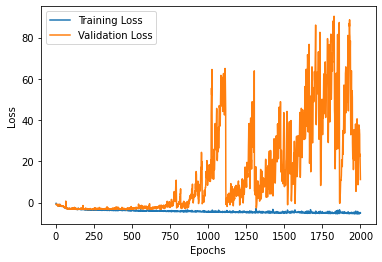

20/20 [==============================] - 1s 51ms/step - loss: -0.9182


20/20 [==============================] - 2s 52ms/step - loss: -3.7708
model number 3


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6404

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 21s 1s/step - loss: -0.6404 - val_loss: -0.8754
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8896

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -0.8896 - val_loss: -0.9978
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9569

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9569 - val_loss: -1.0327
Epoch 4/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9614 - val_loss: -1.0111
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9619

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 995ms/step - loss: -0.9619 - val_loss: -1.0473
Epoch 6/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9499 - val_loss: -0.9378
Epoch 7/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9379 - val_loss: -1.0422
Epoch 8/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9597 - val_loss: -1.0105
Epoch 9/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9586 - val_loss: -1.0467
Epoch 10/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9677 - val_loss: -1.0316
Epoch 11/2000
15/15 [==============================] - ETA: 0s - loss: -0.9745

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9745 - val_loss: -1.0577
Epoch 12/2000
15/15 [==============================] - ETA: 0s - loss: -1.0164

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -1.0164 - val_loss: -1.1497
Epoch 13/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.1248 - val_loss: -0.9274
Epoch 14/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.8295 - val_loss: -0.9446
Epoch 15/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9549 - val_loss: -1.0437
Epoch 16/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9627 - val_loss: -1.0393
Epoch 17/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9664 - val_loss: -1.0333
Epoch 18/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9711 - val_loss: -1.0477
Epoch 19/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9692 - val_loss: -1.0301
Epoch 20/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9698 - val_loss: -1.0450
Epoch 21/2000
15/15 [==============================] - 3s 191ms/step - 

15/15 [==============================] - 3s 193ms/step - loss: -0.9788 - val_loss: -1.0500
Epoch 168/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9760 - val_loss: -1.0473
Epoch 169/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9758 - val_loss: -1.0501
Epoch 170/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9799 - val_loss: -1.0530
Epoch 171/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9767 - val_loss: -1.0472
Epoch 172/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9802 - val_loss: -1.0498
Epoch 173/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9762 - val_loss: -1.0473
Epoch 174/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9767 - val_loss: -1.0454
Epoch 175/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9790 - val_loss: -1.0512
Epoch 176/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -1.0313 - val_loss: -1.1668
Epoch 310/2000
15/15 [==============================] - ETA: 0s - loss: -1.2899

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -1.2899 - val_loss: -1.5931
Epoch 311/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.5481 - val_loss: -0.9006
Epoch 312/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.8259 - val_loss: -0.8758
Epoch 313/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9109 - val_loss: -1.0254
Epoch 314/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9728 - val_loss: -1.0557
Epoch 315/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9798 - val_loss: -1.0482
Epoch 316/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9777 - val_loss: -1.0439
Epoch 317/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9771 - val_loss: -1.0536
Epoch 318/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9770 - val_loss: -1.0456
Epoch 319/2000
15/15 [==============================] - 3s 189m

15/15 [==============================] - 3s 192ms/step - loss: -0.9811 - val_loss: -1.0522
Epoch 465/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9814 - val_loss: -1.0508
Epoch 466/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9879 - val_loss: -1.0591
Epoch 467/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9898 - val_loss: -1.0614
Epoch 468/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9900 - val_loss: -1.0627
Epoch 469/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9932 - val_loss: -1.0619
Epoch 470/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9926 - val_loss: -1.0646
Epoch 471/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9973 - val_loss: -1.0681
Epoch 472/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9981 - val_loss: -1.0743
Epoch 473/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -1.5440 - val_loss: -1.5940
Epoch 495/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.0723 - val_loss: -0.1543
Epoch 496/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.6741 - val_loss: -0.9495
Epoch 497/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.8934 - val_loss: -0.9555
Epoch 498/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9566 - val_loss: -1.0580
Epoch 499/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9786 - val_loss: -1.0502
Epoch 500/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9839 - val_loss: -1.0563
Epoch 501/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9904 - val_loss: -1.0661
Epoch 502/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9994 - val_loss: -1.0816
Epoch 503/2000
15/15 [==============================] - 3s 195m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 987ms/step - loss: -1.6951 - val_loss: -1.6527
Epoch 511/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.8046 - val_loss: -1.6192
Epoch 512/2000
15/15 [==============================] - ETA: 0s - loss: -1.8213

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -1.8213 - val_loss: -1.8667
Epoch 513/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8075 - val_loss: -1.5251
Epoch 514/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.8202 - val_loss: -0.9634
Epoch 515/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.0576 - val_loss: -1.1797
Epoch 516/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.3067 - val_loss: -1.4631
Epoch 517/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.5135 - val_loss: -1.6466
Epoch 518/2000
15/15 [==============================] - ETA: 0s - loss: -1.6602

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -1.6602 - val_loss: -1.8722
Epoch 519/2000
15/15 [==============================] - ETA: 0s - loss: -1.8647

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -1.8647 - val_loss: -1.9209
Epoch 520/2000
15/15 [==============================] - ETA: 0s - loss: -2.0292

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.0292 - val_loss: -2.1198
Epoch 521/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.5776 - val_loss: -1.8594
Epoch 522/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.8729 - val_loss: -1.8023
Epoch 523/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.8506 - val_loss: -1.8052
Epoch 524/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.9066 - val_loss: -1.9150
Epoch 525/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.0242 - val_loss: -2.0038
Epoch 526/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.0986 - val_loss: -2.0468
Epoch 527/2000
15/15 [==============================] - ETA: 0s - loss: -2.1826

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.1826 - val_loss: -2.1847
Epoch 528/2000
15/15 [==============================] - ETA: 0s - loss: -2.2461

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.2461 - val_loss: -2.1994
Epoch 529/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.2713 - val_loss: -1.5522
Epoch 530/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0793 - val_loss: -2.1224
Epoch 531/2000
15/15 [==============================] - ETA: 0s - loss: -2.1766

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.1766 - val_loss: -2.2528
Epoch 532/2000
15/15 [==============================] - ETA: 0s - loss: -2.2696

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.2696 - val_loss: -2.3111
Epoch 533/2000
15/15 [==============================] - ETA: 0s - loss: -2.3484

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3484 - val_loss: -2.3541
Epoch 534/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3049 - val_loss: -2.1927
Epoch 535/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3706 - val_loss: -2.2802
Epoch 536/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3440 - val_loss: -2.1074
Epoch 537/2000
15/15 [==============================] - ETA: 0s - loss: -2.3284

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3284 - val_loss: -2.3902
Epoch 538/2000
15/15 [==============================] - ETA: 0s - loss: -2.3744

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3744 - val_loss: -2.4475
Epoch 539/2000
15/15 [==============================] - ETA: 0s - loss: -2.4314

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 979ms/step - loss: -2.4314 - val_loss: -2.4851
Epoch 540/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4392 - val_loss: -2.4579
Epoch 541/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.4201 - val_loss: -2.4775
Epoch 542/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.4871 - val_loss: -2.4843
Epoch 543/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.4491 - val_loss: -1.6725
Epoch 544/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.2679 - val_loss: -2.3277
Epoch 545/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.4065 - val_loss: -2.4644
Epoch 546/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.4528 - val_loss: -2.4686
Epoch 547/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3789 - val_loss: -2.2408
Epoch 548/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.4986 - val_loss: -2.5074
Epoch 552/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4360 - val_loss: -2.0258
Epoch 553/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4725 - val_loss: -2.4608
Epoch 554/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4215 - val_loss: -2.3773
Epoch 555/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.4312 - val_loss: -2.4516
Epoch 556/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.4855 - val_loss: -2.4150
Epoch 557/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.5010 - val_loss: -2.4825
Epoch 558/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.4856 - val_loss: -2.4204
Epoch 559/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4011 - val_loss: -2.3854
Epoch 560/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5095 - val_loss: -2.5132
Epoch 565/2000
15/15 [==============================] - ETA: 0s - loss: -2.5021

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5021 - val_loss: -2.5404
Epoch 566/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5262 - val_loss: -2.5386
Epoch 567/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.5448 - val_loss: -2.4832
Epoch 568/2000
15/15 [==============================] - ETA: 0s - loss: -2.5135

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5135 - val_loss: -2.5478
Epoch 569/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5461 - val_loss: -2.3991
Epoch 570/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.4708 - val_loss: -2.4445
Epoch 571/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.4983 - val_loss: -2.5209
Epoch 572/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.5383 - val_loss: -2.5231
Epoch 573/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.5396 - val_loss: -2.4079
Epoch 574/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.3971 - val_loss: -2.2795
Epoch 575/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.4506 - val_loss: -2.4811
Epoch 576/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.5208 - val_loss: -2.5179
Epoch 577/2000
15/15 [==============================] - 3s 200m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.5903 - val_loss: -2.6223
Epoch 603/2000
15/15 [==============================] - ETA: 0s - loss: -2.7050

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7050 - val_loss: -2.7501
Epoch 604/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7804 - val_loss: -2.4446
Epoch 605/2000
15/15 [==============================] - ETA: 0s - loss: -2.7545

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7545 - val_loss: -2.7559
Epoch 606/2000
15/15 [==============================] - ETA: 0s - loss: -2.9122

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.9122 - val_loss: -2.8319
Epoch 607/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.7681 - val_loss: -2.5929
Epoch 608/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.6383 - val_loss: -2.6826
Epoch 609/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2813 - val_loss: -2.1101
Epoch 610/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2917 - val_loss: -2.5267
Epoch 611/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.5567 - val_loss: -2.7520
Epoch 612/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.7648 - val_loss: -2.5104
Epoch 613/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3031 - val_loss: -1.7280
Epoch 614/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.2237 - val_loss: -1.9366
Epoch 615/2000
15/15 [==============================] - 3s 193m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -2.9396 - val_loss: -2.8611
Epoch 677/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.9485 - val_loss: -2.8104
Epoch 678/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.0289 - val_loss: -2.8425
Epoch 679/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0192 - val_loss: -2.7845
Epoch 680/2000
15/15 [==============================] - ETA: 0s - loss: -3.0022

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.0022 - val_loss: -2.8691
Epoch 681/2000
15/15 [==============================] - ETA: 0s - loss: -3.0331

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -3.0331 - val_loss: -2.8820
Epoch 682/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.0278 - val_loss: -2.6974
Epoch 683/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0138 - val_loss: -2.7676
Epoch 684/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9800 - val_loss: -2.8693
Epoch 685/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0277 - val_loss: -2.6544
Epoch 686/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9043 - val_loss: -2.8599
Epoch 687/2000
15/15 [==============================] - ETA: 0s - loss: -2.9925

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.9925 - val_loss: -2.9740
Epoch 688/2000
15/15 [==============================] - ETA: 0s - loss: -3.1314

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1314 - val_loss: -2.9920
Epoch 689/2000
15/15 [==============================] - ETA: 0s - loss: -3.1399

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1399 - val_loss: -3.0633
Epoch 690/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.1195 - val_loss: -2.8337
Epoch 691/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0122 - val_loss: -2.9718
Epoch 692/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1722 - val_loss: -2.8465
Epoch 693/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9347 - val_loss: -2.7616
Epoch 694/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0800 - val_loss: -2.8761
Epoch 695/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1484 - val_loss: -2.9588
Epoch 696/2000
15/15 [==============================] - ETA: 0s - loss: -3.2552

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2552 - val_loss: -3.0904
Epoch 697/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2628 - val_loss: -2.8801
Epoch 698/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2183 - val_loss: -2.9888
Epoch 699/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1632 - val_loss: -2.8735
Epoch 700/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1341 - val_loss: -2.9464
Epoch 701/2000
15/15 [==============================] - ETA: 0s - loss: -3.2802

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2802 - val_loss: -3.1272
Epoch 702/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2992 - val_loss: -2.6786
Epoch 703/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.9478 - val_loss: -2.6530
Epoch 704/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9728 - val_loss: -3.0297
Epoch 705/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1278 - val_loss: -3.0420
Epoch 706/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3279 - val_loss: -3.0954
Epoch 707/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3894 - val_loss: -3.0576
Epoch 708/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2654 - val_loss: -2.4790
Epoch 709/2000
15/15 [==============================] - ETA: 0s - loss: -3.2808

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 991ms/step - loss: -3.2808 - val_loss: -3.1378
Epoch 710/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3792 - val_loss: -3.0532
Epoch 711/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2257 - val_loss: -3.0549
Epoch 712/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3881 - val_loss: -3.0371
Epoch 713/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3883 - val_loss: -2.9834
Epoch 714/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.3892 - val_loss: -2.8791
Epoch 715/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2113 - val_loss: -2.8447
Epoch 716/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1950 - val_loss: -3.0013
Epoch 717/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2849 - val_loss: -2.8498
Epoch 718/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -2.9420 - val_loss: -3.1695
Epoch 721/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1213 - val_loss: -3.1086
Epoch 722/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3222 - val_loss: -3.0969
Epoch 723/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3212 - val_loss: -3.0781
Epoch 724/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4384 - val_loss: -2.9707
Epoch 725/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3903 - val_loss: -3.0367
Epoch 726/2000
15/15 [==============================] - ETA: 0s - loss: -3.3699

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.3699 - val_loss: -3.2085
Epoch 727/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.4512 - val_loss: -3.0446
Epoch 728/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3767 - val_loss: -2.8185
Epoch 729/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3422 - val_loss: -3.0911
Epoch 730/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.4393 - val_loss: -3.0574
Epoch 731/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.3792 - val_loss: -3.0289
Epoch 732/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2724 - val_loss: -3.1767
Epoch 733/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2090 - val_loss: -3.1740
Epoch 734/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2593 - val_loss: -3.0867
Epoch 735/2000
15/15 [==============================] - 3s 185m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1069 - val_loss: -3.2267
Epoch 750/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.2536 - val_loss: -2.5475
Epoch 751/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9517 - val_loss: -3.1087
Epoch 752/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1039 - val_loss: -3.0137
Epoch 753/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2325 - val_loss: -3.1905
Epoch 754/2000
15/15 [==============================] - ETA: 0s - loss: -3.3030

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.3030 - val_loss: -3.2845
Epoch 755/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3363 - val_loss: -3.0730
Epoch 756/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.3928 - val_loss: -3.0852
Epoch 757/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3347 - val_loss: -3.2477
Epoch 758/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4497 - val_loss: -3.2793
Epoch 759/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4731 - val_loss: -3.1730
Epoch 760/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1416 - val_loss: -2.8633
Epoch 761/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.1528 - val_loss: -2.9336
Epoch 762/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2575 - val_loss: -3.2343
Epoch 763/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 15s 1s/step - loss: -3.3523 - val_loss: -3.2960
Epoch 766/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4534 - val_loss: -3.2504
Epoch 767/2000
15/15 [==============================] - ETA: 0s - loss: -3.4260

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4260 - val_loss: -3.2976
Epoch 768/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4140 - val_loss: -3.1820
Epoch 769/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3943 - val_loss: -3.1514
Epoch 770/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4377 - val_loss: -2.7738
Epoch 771/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3671 - val_loss: -3.0977
Epoch 772/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.2093 - val_loss: -3.2447
Epoch 773/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3340 - val_loss: -3.2852
Epoch 774/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4542 - val_loss: -3.1083
Epoch 775/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5181 - val_loss: -3.2174
Epoch 776/2000
15/15 [==============================] - 3s 186m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel3/assets


15/15 [==============================] - 14s 985ms/step - loss: -3.4747 - val_loss: -3.4328
Epoch 902/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5963 - val_loss: -3.3153
Epoch 903/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5837 - val_loss: -3.0385
Epoch 904/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5967 - val_loss: -3.0962
Epoch 905/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5988 - val_loss: -2.9337
Epoch 906/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6329 - val_loss: -3.0168
Epoch 907/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5432 - val_loss: -2.8843
Epoch 908/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.5623 - val_loss: -3.1739
Epoch 909/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6834 - val_loss: -3.0976
Epoch 910/2000
15/15 [==============================] - 3s 1

Epoch 1055/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8351 - val_loss: -2.7453
Epoch 1056/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.8668 - val_loss: -2.7195
Epoch 1057/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.8253 - val_loss: -2.8710
Epoch 1058/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7346 - val_loss: -2.6498
Epoch 1059/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8393 - val_loss: -2.8463
Epoch 1060/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8225 - val_loss: -2.7923
Epoch 1061/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.8566 - val_loss: -2.6763
Epoch 1062/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.8878 - val_loss: -2.4855
Epoch 1063/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.8094 - val_loss: -2.7551
Epoch 1064/2000
15/15 [==============

15/15 [==============================] - 3s 193ms/step - loss: -3.8208 - val_loss: -3.1381
Epoch 1208/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9177 - val_loss: -2.6442
Epoch 1209/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.7147 - val_loss: -2.5923
Epoch 1210/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7100 - val_loss: -3.1937
Epoch 1211/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8835 - val_loss: -3.0067
Epoch 1212/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8908 - val_loss: -2.9532
Epoch 1213/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.9449 - val_loss: -2.8963
Epoch 1214/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.9092 - val_loss: -2.5467
Epoch 1215/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.6003 - val_loss: -2.9533
Epoch 1216/2000
15/15 [==============================

15/15 [==============================] - 3s 193ms/step - loss: -3.2433 - val_loss: -2.7081
Epoch 1360/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4872 - val_loss: -3.1128
Epoch 1361/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.7740 - val_loss: -3.1872
Epoch 1362/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.9745 - val_loss: -2.7632
Epoch 1363/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0012 - val_loss: -2.6055
Epoch 1364/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0012 - val_loss: -2.6549
Epoch 1365/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.9992 - val_loss: -2.5622
Epoch 1366/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.9151 - val_loss: -2.9843
Epoch 1367/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.0578 - val_loss: -2.6893
Epoch 1368/2000
15/15 [==============================

15/15 [==============================] - 3s 193ms/step - loss: -4.1263 - val_loss: 0.1723
Epoch 1512/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.1437 - val_loss: 1.1925
Epoch 1513/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0022 - val_loss: -2.4092
Epoch 1514/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.8648 - val_loss: -2.0950
Epoch 1515/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8286 - val_loss: -2.8756
Epoch 1516/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0526 - val_loss: -2.7014
Epoch 1517/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0826 - val_loss: -2.4449
Epoch 1518/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.1180 - val_loss: -2.6480
Epoch 1519/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1077 - val_loss: -2.0487
Epoch 1520/2000
15/15 [==============================] 

Epoch 1588/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9497 - val_loss: -2.5381
Epoch 1589/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0191 - val_loss: -2.5691
Epoch 1590/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0166 - val_loss: -2.5880
Epoch 1591/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.9621 - val_loss: -2.6709
Epoch 1592/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0721 - val_loss: -2.7047
Epoch 1593/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1139 - val_loss: -2.5402
Epoch 1594/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1340 - val_loss: -1.4092
Epoch 1595/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8805 - val_loss: -2.2294
Epoch 1596/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9783 - val_loss: -2.5461
Epoch 1597/2000
15/15 [==============

Epoch 1665/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8339 - val_loss: -2.6164
Epoch 1666/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.0544 - val_loss: -2.5488
Epoch 1667/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1657 - val_loss: -1.6180
Epoch 1668/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.0001 - val_loss: -2.1525
Epoch 1669/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1303 - val_loss: -2.0992
Epoch 1670/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0843 - val_loss: -1.4847
Epoch 1671/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0977 - val_loss: -1.5337
Epoch 1672/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9845 - val_loss: -1.7661
Epoch 1673/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.1121 - val_loss: -1.6477
Epoch 1674/2000
15/15 [==============

Epoch 1742/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1807 - val_loss: -1.8777
Epoch 1743/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.7717 - val_loss: -0.6259
Epoch 1744/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.8695 - val_loss: -3.0661
Epoch 1745/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2797 - val_loss: -3.1175
Epoch 1746/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.4167 - val_loss: -3.2651
Epoch 1747/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5771 - val_loss: -3.3307
Epoch 1748/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6959 - val_loss: -3.3078
Epoch 1749/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7882 - val_loss: -3.2343
Epoch 1750/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8414 - val_loss: -3.2255
Epoch 1751/2000
15/15 [==============

15/15 [==============================] - 3s 190ms/step - loss: -4.1896 - val_loss: -2.0834
Epoch 1895/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.0132 - val_loss: -1.8682
Epoch 1896/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.1635 - val_loss: -2.1759
Epoch 1897/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.0945 - val_loss: -2.4171
Epoch 1898/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0847 - val_loss: -2.2731
Epoch 1899/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.1742 - val_loss: -1.6953
Epoch 1900/2000
15/15 [==============================] - 3s 206ms/step - loss: -4.2294 - val_loss: -1.9057
Epoch 1901/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2477 - val_loss: -1.9275
Epoch 1902/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1620 - val_loss: -1.8375
Epoch 1903/2000
15/15 [==============================

Epoch 1971/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.1957 - val_loss: -1.9933
Epoch 1972/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.2252 - val_loss: -0.7292
Epoch 1973/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.1359 - val_loss: -1.5478
Epoch 1974/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.1781 - val_loss: -1.4564
Epoch 1975/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.3359 - val_loss: -0.5295
Epoch 1976/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.3732 - val_loss: 0.6439
Epoch 1977/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.2563 - val_loss: -0.1344
Epoch 1978/2000
15/15 [==============================] - 3s 185ms/step - loss: -4.1901 - val_loss: -0.3675
Epoch 1979/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.9167 - val_loss: 0.2455
Epoch 1980/2000
15/15 [================

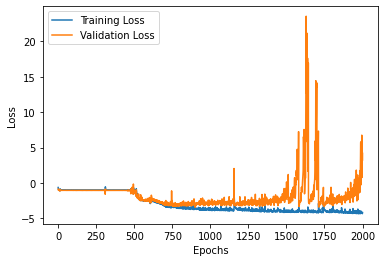

20/20 [==============================] - 1s 49ms/step - loss: -2.0500


20/20 [==============================] - 2s 48ms/step - loss: -3.5360
model number 4


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6639

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 22s 1s/step - loss: -0.6639 - val_loss: -0.9122
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8972

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 986ms/step - loss: -0.8972 - val_loss: -0.9280
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9386

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9386 - val_loss: -1.0219
Epoch 4/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9589 - val_loss: -1.0104
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9581

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9581 - val_loss: -1.0414
Epoch 6/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9366 - val_loss: -0.9282
Epoch 7/2000
15/15 [==============================] - ETA: 0s - loss: -0.9326

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9326 - val_loss: -1.0431
Epoch 8/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9504 - val_loss: -1.0023
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9542

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 987ms/step - loss: -0.9542 - val_loss: -1.0457
Epoch 10/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9673 - val_loss: -1.0300
Epoch 11/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9633 - val_loss: -1.0329
Epoch 12/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9660 - val_loss: -1.0373
Epoch 13/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9643 - val_loss: -1.0255
Epoch 14/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9670 - val_loss: -1.0447
Epoch 15/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9632 - val_loss: -1.0270
Epoch 16/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9603 - val_loss: -1.0343
Epoch 17/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9693 - val_loss: -1.0445
Epoch 18/2000
15/15 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9746 - val_loss: -1.0468
Epoch 19/2000
15/15 [==============================] - ETA: 0s - loss: -0.9796

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9796 - val_loss: -1.0664
Epoch 20/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.1312 - val_loss: -1.0142
Epoch 21/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.5505 - val_loss: -0.6167
Epoch 22/2000
15/15 [==============================] - ETA: 0s - loss: -0.8005

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -0.8005 - val_loss: -1.0787
Epoch 23/2000
15/15 [==============================] - ETA: 0s - loss: -1.0424

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 993ms/step - loss: -1.0424 - val_loss: -1.2199
Epoch 24/2000
15/15 [==============================] - ETA: 0s - loss: -1.2255

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -1.2255 - val_loss: -1.2955
Epoch 25/2000
15/15 [==============================] - ETA: 0s - loss: -1.3850

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -1.3850 - val_loss: -1.6018
Epoch 26/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9741 - val_loss: -1.0722
Epoch 27/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.0829 - val_loss: -1.2870
Epoch 28/2000
15/15 [==============================] - 3s 186ms/step - loss: -1.3940 - val_loss: -1.4864
Epoch 29/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7064 - val_loss: -1.5602
Epoch 30/2000
15/15 [==============================] - ETA: 0s - loss: -1.6754

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -1.6754 - val_loss: -1.6983
Epoch 31/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.7422 - val_loss: -1.5153
Epoch 32/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.7506 - val_loss: -1.3431
Epoch 33/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.7056 - val_loss: -1.6573
Epoch 34/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.7257 - val_loss: -1.6157
Epoch 35/2000
15/15 [==============================] - ETA: 0s - loss: -1.6771

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 987ms/step - loss: -1.6771 - val_loss: -1.7592
Epoch 36/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.6271 - val_loss: -1.7563
Epoch 37/2000
15/15 [==============================] - 3s 186ms/step - loss: -1.7306 - val_loss: -1.7376
Epoch 38/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.7900 - val_loss: -1.6950
Epoch 39/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.7485 - val_loss: -1.3753
Epoch 40/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.5114 - val_loss: -1.7117
Epoch 41/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.6268 - val_loss: -1.6763
Epoch 42/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.7502 - val_loss: -1.6474
Epoch 43/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.7886 - val_loss: -1.6262
Epoch 44/2000
15/15 [==============================] - 3s 195ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -1.6516 - val_loss: -1.8302
Epoch 54/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.6728 - val_loss: -1.7678
Epoch 55/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.6202 - val_loss: -1.7136
Epoch 56/2000
15/15 [==============================] - 3s 201ms/step - loss: -1.6415 - val_loss: -1.7282
Epoch 57/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.6561 - val_loss: -1.8196
Epoch 58/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.6631 - val_loss: -1.8226
Epoch 59/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.6612 - val_loss: -1.6910
Epoch 60/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.6646 - val_loss: -1.7573
Epoch 61/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.6885 - val_loss: -1.7748
Epoch 62/2000
15/15 [==============================] - 3s 193ms/step - 

Epoch 131/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.7956 - val_loss: -1.6908
Epoch 132/2000
15/15 [==============================] - 3s 187ms/step - loss: -1.8052 - val_loss: -1.6959
Epoch 133/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8042 - val_loss: -1.6458
Epoch 134/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.7978 - val_loss: -1.5877
Epoch 135/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.8254 - val_loss: -1.5840
Epoch 136/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.7939 - val_loss: -1.5422
Epoch 137/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.7365 - val_loss: -1.5014
Epoch 138/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.7315 - val_loss: -1.6267
Epoch 139/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.8138 - val_loss: -1.6191
Epoch 140/2000
15/15 [========================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -1.9795 - val_loss: -1.8693
Epoch 172/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.0666 - val_loss: -1.5803
Epoch 173/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.8347 - val_loss: -1.7312
Epoch 174/2000
15/15 [==============================] - 3s 186ms/step - loss: -1.9255 - val_loss: -1.8126
Epoch 175/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.9173 - val_loss: -1.7947
Epoch 176/2000
15/15 [==============================] - ETA: 0s - loss: -1.9413

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -1.9413 - val_loss: -1.9925
Epoch 177/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.9816 - val_loss: -1.7979
Epoch 178/2000
15/15 [==============================] - ETA: 0s - loss: -2.0778

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 977ms/step - loss: -2.0778 - val_loss: -2.2109
Epoch 179/2000
15/15 [==============================] - 3s 195ms/step - loss: 1.6833 - val_loss: -1.4722
Epoch 180/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.6641 - val_loss: -1.5101
Epoch 181/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.6341 - val_loss: -1.6355
Epoch 182/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.7706 - val_loss: -1.6902
Epoch 183/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.8355 - val_loss: -1.7852
Epoch 184/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.8887 - val_loss: -1.8323
Epoch 185/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.7864 - val_loss: -1.8827
Epoch 186/2000
15/15 [==============================] - 3s 184ms/step - loss: -1.9519 - val_loss: -2.0161
Epoch 187/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -2.2564 - val_loss: -2.3606
Epoch 200/2000
15/15 [==============================] - ETA: 0s - loss: -2.3799

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3799 - val_loss: -2.4494
Epoch 201/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.1298 - val_loss: -2.0767
Epoch 202/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.1583 - val_loss: -2.2362
Epoch 203/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.3151 - val_loss: -2.3562
Epoch 204/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4262 - val_loss: -2.2954
Epoch 205/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3943 - val_loss: -2.4084
Epoch 206/2000
15/15 [==============================] - ETA: 0s - loss: -2.4649

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4649 - val_loss: -2.5934
Epoch 207/2000
15/15 [==============================] - ETA: 0s - loss: -2.5954

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 996ms/step - loss: -2.5954 - val_loss: -2.6691
Epoch 208/2000
15/15 [==============================] - ETA: 0s - loss: -2.5441

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -2.5441 - val_loss: -2.7809
Epoch 209/2000
15/15 [==============================] - ETA: 0s - loss: -2.7290

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7290 - val_loss: -2.8739
Epoch 210/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.7488 - val_loss: -2.7422
Epoch 211/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.5453 - val_loss: -2.4794
Epoch 212/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.4387 - val_loss: -2.7199
Epoch 213/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.5312 - val_loss: -2.7212
Epoch 214/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.6992 - val_loss: -2.7030
Epoch 215/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.7189 - val_loss: -2.8373
Epoch 216/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.7680 - val_loss: -2.5717
Epoch 217/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2886 - val_loss: -2.1473
Epoch 218/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.7692 - val_loss: -2.9427
Epoch 224/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8872 - val_loss: -2.5326
Epoch 225/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.8082 - val_loss: -2.8839
Epoch 226/2000
15/15 [==============================] - ETA: 0s - loss: -2.8381

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -2.8381 - val_loss: -2.9553
Epoch 227/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.5300 - val_loss: -2.7557
Epoch 228/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.8243 - val_loss: -2.8521
Epoch 229/2000
15/15 [==============================] - ETA: 0s - loss: -2.8527

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.8527 - val_loss: -2.9701
Epoch 230/2000
15/15 [==============================] - ETA: 0s - loss: -2.9453

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -2.9453 - val_loss: -3.0977
Epoch 231/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0124 - val_loss: -3.0165
Epoch 232/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.9347 - val_loss: -3.0546
Epoch 233/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8762 - val_loss: -2.9443
Epoch 234/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.0199 - val_loss: -3.0723
Epoch 235/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0673 - val_loss: -2.7167
Epoch 236/2000
15/15 [==============================] - ETA: 0s - loss: -2.9196

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.9196 - val_loss: -3.1315
Epoch 237/2000
15/15 [==============================] - ETA: 0s - loss: -2.9902

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -2.9902 - val_loss: -3.2034
Epoch 238/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.8996 - val_loss: -2.8958
Epoch 239/2000
15/15 [==============================] - 3s 184ms/step - loss: -2.9081 - val_loss: -3.1124
Epoch 240/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1128 - val_loss: -3.1874
Epoch 241/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7292 - val_loss: -2.8621
Epoch 242/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.5985 - val_loss: -2.6174
Epoch 243/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.7195 - val_loss: -2.9031
Epoch 244/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9475 - val_loss: -3.0765
Epoch 245/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0813 - val_loss: -3.1837
Epoch 246/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -3.1705 - val_loss: -3.2228
Epoch 252/2000
15/15 [==============================] - ETA: 0s - loss: -3.1224

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 979ms/step - loss: -3.1224 - val_loss: -3.2353
Epoch 253/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1045 - val_loss: -3.0445
Epoch 254/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7222 - val_loss: -2.7479
Epoch 255/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.7724 - val_loss: -2.8227
Epoch 256/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9434 - val_loss: -3.1055
Epoch 257/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1359 - val_loss: -3.1947
Epoch 258/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.2135 - val_loss: -2.8712
Epoch 259/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0347 - val_loss: -3.0425
Epoch 260/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.1167 - val_loss: -3.0757
Epoch 261/2000
15/15 [==============================] - ETA:

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 17s 1s/step - loss: -3.2270 - val_loss: -3.2402
Epoch 262/2000
15/15 [==============================] - ETA: 0s - loss: -3.2887

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2887 - val_loss: -3.2733
Epoch 263/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9718 - val_loss: -2.7525
Epoch 264/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.7760 - val_loss: -3.0442
Epoch 265/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0317 - val_loss: -3.1932
Epoch 266/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2225 - val_loss: -3.2447
Epoch 267/2000
15/15 [==============================] - ETA: 0s - loss: -3.2679

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2679 - val_loss: -3.2794
Epoch 268/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2464 - val_loss: -3.0321
Epoch 269/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1923 - val_loss: -2.8732
Epoch 270/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.1786 - val_loss: -3.0751
Epoch 271/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.2658 - val_loss: -3.1441
Epoch 272/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2008 - val_loss: -3.1611
Epoch 273/2000
15/15 [==============================] - ETA: 0s - loss: -3.2203

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2203 - val_loss: -3.3057
Epoch 274/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2832 - val_loss: -3.2138
Epoch 275/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.2608 - val_loss: -3.0901
Epoch 276/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.3147 - val_loss: -3.2504
Epoch 277/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.9343 - val_loss: -2.9564
Epoch 278/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.0193 - val_loss: -2.9974
Epoch 279/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1389 - val_loss: -3.1708
Epoch 280/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3231 - val_loss: -3.2971
Epoch 281/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3842 - val_loss: -3.2400
Epoch 282/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 980ms/step - loss: -3.3626 - val_loss: -3.3203
Epoch 294/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3909 - val_loss: -3.2499
Epoch 295/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1499 - val_loss: -3.1093
Epoch 296/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2901 - val_loss: -3.2018
Epoch 297/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3777 - val_loss: -3.3010
Epoch 298/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3945 - val_loss: -3.1527
Epoch 299/2000
15/15 [==============================] - ETA: 0s - loss: -3.4001

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4001 - val_loss: -3.3742
Epoch 300/2000
15/15 [==============================] - ETA: 0s - loss: -3.4842

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -3.4842 - val_loss: -3.3771
Epoch 301/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.5704 - val_loss: -2.7819
Epoch 302/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.9529 - val_loss: -3.0695
Epoch 303/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1851 - val_loss: -3.2130
Epoch 304/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.2848 - val_loss: -3.0536
Epoch 305/2000
15/15 [==============================] - 3s 183ms/step - loss: -3.3143 - val_loss: -3.2598
Epoch 306/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.3848 - val_loss: -3.2152
Epoch 307/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3623 - val_loss: -2.8996
Epoch 308/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.2391 - val_loss: -3.2094
Epoch 309/2000
15/15 [==============================] - 3s 197m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 15s 1s/step - loss: -3.4348 - val_loss: -3.4010
Epoch 389/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3948 - val_loss: -3.2932
Epoch 390/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5279 - val_loss: -3.1510
Epoch 391/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5320 - val_loss: -3.0903
Epoch 392/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3914 - val_loss: -2.8612
Epoch 393/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2411 - val_loss: -3.2472
Epoch 394/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.4996 - val_loss: -3.2465
Epoch 395/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4843 - val_loss: -3.1620
Epoch 396/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4620 - val_loss: -3.2883
Epoch 397/2000
15/15 [==============================] - 3s 192m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 14s 982ms/step - loss: -3.4378 - val_loss: -3.4758
Epoch 459/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5112 - val_loss: -3.4262
Epoch 460/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5104 - val_loss: -3.2837
Epoch 461/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.2240 - val_loss: -3.3046
Epoch 462/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3724 - val_loss: -3.3976
Epoch 463/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.5193 - val_loss: -3.3806
Epoch 464/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5672 - val_loss: -3.4313
Epoch 465/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5430 - val_loss: -3.2050
Epoch 466/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5349 - val_loss: -3.3754
Epoch 467/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel4/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4881 - val_loss: -3.4902
Epoch 558/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5346 - val_loss: -3.4756
Epoch 559/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.6070 - val_loss: -3.4393
Epoch 560/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4149 - val_loss: -3.4796
Epoch 561/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5176 - val_loss: -3.2684
Epoch 562/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5063 - val_loss: -3.1892
Epoch 563/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6030 - val_loss: -3.0866
Epoch 564/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.5276 - val_loss: -3.2310
Epoch 565/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4951 - val_loss: -3.2079
Epoch 566/2000
15/15 [==============================] - 3s 191m

15/15 [==============================] - 3s 196ms/step - loss: -3.5294 - val_loss: -3.1201
Epoch 712/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7168 - val_loss: -3.1891
Epoch 713/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7767 - val_loss: -2.9462
Epoch 714/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7882 - val_loss: -2.9935
Epoch 715/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7213 - val_loss: -3.1677
Epoch 716/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.7717 - val_loss: -3.1716
Epoch 717/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7475 - val_loss: -3.0289
Epoch 718/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5608 - val_loss: -2.8925
Epoch 719/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4056 - val_loss: -3.1233
Epoch 720/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 194ms/step - loss: -3.8067 - val_loss: -2.8103
Epoch 866/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6776 - val_loss: -2.8597
Epoch 867/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.7114 - val_loss: -3.0355
Epoch 868/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7538 - val_loss: -2.8360
Epoch 869/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6806 - val_loss: -3.3768
Epoch 870/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.6405 - val_loss: -3.2621
Epoch 871/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5141 - val_loss: -3.3117
Epoch 872/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6582 - val_loss: -3.3096
Epoch 873/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7104 - val_loss: -3.0696
Epoch 874/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 192ms/step - loss: -3.8393 - val_loss: -2.7395
Epoch 1020/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7882 - val_loss: -2.9481
Epoch 1021/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7291 - val_loss: -3.0397
Epoch 1022/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.7311 - val_loss: -3.0095
Epoch 1023/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7608 - val_loss: -3.1437
Epoch 1024/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8458 - val_loss: -2.9445
Epoch 1025/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.8562 - val_loss: -2.8628
Epoch 1026/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8711 - val_loss: -2.8769
Epoch 1027/2000
15/15 [==============================] - 3s 183ms/step - loss: -3.6849 - val_loss: -2.8830
Epoch 1028/2000
15/15 [==============================

15/15 [==============================] - 3s 196ms/step - loss: -3.8086 - val_loss: -3.0362
Epoch 1172/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.8660 - val_loss: -3.0574
Epoch 1173/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.8973 - val_loss: -2.7400
Epoch 1174/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.7306 - val_loss: -3.2438
Epoch 1175/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.9267 - val_loss: -3.0856
Epoch 1176/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.9498 - val_loss: -2.7775
Epoch 1177/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8513 - val_loss: -2.7595
Epoch 1178/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4420 - val_loss: -3.0908
Epoch 1179/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.6299 - val_loss: -3.2229
Epoch 1180/2000
15/15 [==============================

15/15 [==============================] - 3s 195ms/step - loss: -3.9256 - val_loss: -2.6609
Epoch 1324/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6527 - val_loss: -3.2602
Epoch 1325/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8381 - val_loss: -3.1622
Epoch 1326/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8638 - val_loss: -2.4291
Epoch 1327/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6545 - val_loss: -3.0693
Epoch 1328/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.8133 - val_loss: -2.5942
Epoch 1329/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7373 - val_loss: -2.9823
Epoch 1330/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6731 - val_loss: -2.7331
Epoch 1331/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.7294 - val_loss: -3.1908
Epoch 1332/2000
15/15 [==============================

15/15 [==============================] - 3s 191ms/step - loss: -4.0032 - val_loss: -2.7052
Epoch 1476/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9534 - val_loss: -2.3444
Epoch 1477/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9951 - val_loss: -2.7266
Epoch 1478/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8940 - val_loss: -2.9538
Epoch 1479/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7679 - val_loss: -3.1683
Epoch 1480/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8786 - val_loss: -3.0296
Epoch 1481/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.9410 - val_loss: -3.2295
Epoch 1482/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.9606 - val_loss: -3.1455
Epoch 1483/2000
15/15 [==============================] - 3s 186ms/step - loss: -4.0216 - val_loss: -2.9574
Epoch 1484/2000
15/15 [==============================

15/15 [==============================] - 3s 191ms/step - loss: -3.8977 - val_loss: -3.1043
Epoch 1628/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.9430 - val_loss: -2.9371
Epoch 1629/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8605 - val_loss: -2.7223
Epoch 1630/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8982 - val_loss: -3.0574
Epoch 1631/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0019 - val_loss: -2.7458
Epoch 1632/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9880 - val_loss: -2.6555
Epoch 1633/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0039 - val_loss: -2.7107
Epoch 1634/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.9651 - val_loss: -2.8233
Epoch 1635/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.0782 - val_loss: -2.3600
Epoch 1636/2000
15/15 [==============================

15/15 [==============================] - 3s 197ms/step - loss: -4.1574 - val_loss: -2.2900
Epoch 1780/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.1472 - val_loss: -2.3971
Epoch 1781/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.1638 - val_loss: -2.2643
Epoch 1782/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0784 - val_loss: -2.3070
Epoch 1783/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0064 - val_loss: -2.4178
Epoch 1784/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.0436 - val_loss: -2.4761
Epoch 1785/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.1489 - val_loss: -2.3241
Epoch 1786/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.1622 - val_loss: -2.2556
Epoch 1787/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0715 - val_loss: -2.6984
Epoch 1788/2000
15/15 [==============================

15/15 [==============================] - 3s 191ms/step - loss: -4.2989 - val_loss: -1.8763
Epoch 1932/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.3435 - val_loss: -1.6312
Epoch 1933/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.3811 - val_loss: -1.3082
Epoch 1934/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.3919 - val_loss: -1.3797
Epoch 1935/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.3595 - val_loss: -1.4452
Epoch 1936/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.1934 - val_loss: -0.9935
Epoch 1937/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.0408 - val_loss: -1.6613
Epoch 1938/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1380 - val_loss: -1.9571
Epoch 1939/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.1410 - val_loss: -2.3622
Epoch 1940/2000
15/15 [==============================

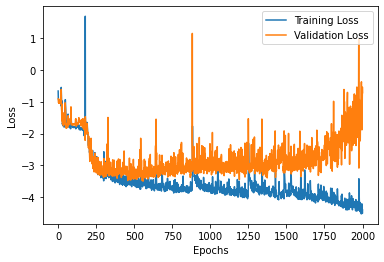

20/20 [==============================] - 1s 47ms/step - loss: -3.2744


20/20 [==============================] - 2s 46ms/step - loss: -3.5602
model number 5


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6209

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 22s 1s/step - loss: -0.6209 - val_loss: -0.8542
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8992

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -0.8992 - val_loss: -0.9842
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9603

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9603 - val_loss: -1.0573
Epoch 4/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9753 - val_loss: -1.0526
Epoch 5/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.0800 - val_loss: -1.0209
Epoch 6/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.0029 - val_loss: -0.0520
Epoch 7/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.5047 - val_loss: -0.6578
Epoch 8/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.7661 - val_loss: -0.9701
Epoch 9/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9568 - val_loss: -1.0411
Epoch 10/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9593 - val_loss: -1.0173
Epoch 11/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9584 - val_loss: -1.0335
Epoch 12/2000
15/15 [==============================] - 3s 198ms/step - loss: 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 17s 1s/step - loss: -1.0242 - val_loss: -1.0629
Epoch 84/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9799 - val_loss: -1.0518
Epoch 85/2000
15/15 [==============================] - ETA: 0s - loss: -0.9826

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -0.9826 - val_loss: -1.0960
Epoch 86/2000
15/15 [==============================] - ETA: 0s - loss: -1.1881

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 981ms/step - loss: -1.1881 - val_loss: -1.3724
Epoch 87/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.6091 - val_loss: -0.8692
Epoch 88/2000
15/15 [==============================] - ETA: 0s - loss: -1.6474

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -1.6474 - val_loss: -1.5803
Epoch 89/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.0395 - val_loss: -1.0617
Epoch 90/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.8680 - val_loss: -0.8571
Epoch 91/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.8586 - val_loss: -1.0123
Epoch 92/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.7130 - val_loss: -0.9267
Epoch 93/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9143 - val_loss: -0.9917
Epoch 94/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9672 - val_loss: -1.0463
Epoch 95/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9759 - val_loss: -1.0504
Epoch 96/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9743 - val_loss: -1.0517
Epoch 97/2000
15/15 [==============================] - 3s 189ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -1.3992 - val_loss: -1.6585
Epoch 123/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.6950 - val_loss: -0.7369
Epoch 124/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.7275 - val_loss: -0.8300
Epoch 125/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.8538 - val_loss: -0.9753
Epoch 126/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9577 - val_loss: -1.0439
Epoch 127/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9765 - val_loss: -1.0516
Epoch 128/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9729 - val_loss: -1.0533
Epoch 129/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9783 - val_loss: -1.0426
Epoch 130/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9794 - val_loss: -1.0504
Epoch 131/2000
15/15 [==============================] - 3s 198m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -1.7530 - val_loss: -1.8048
Epoch 232/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.8934 - val_loss: -1.7557
Epoch 233/2000
15/15 [==============================] - ETA: 0s - loss: -1.9119

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 993ms/step - loss: -1.9119 - val_loss: -1.8165
Epoch 234/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.8484 - val_loss: -1.4686
Epoch 235/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.7397 - val_loss: -1.5509
Epoch 236/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.8076 - val_loss: -1.6078
Epoch 237/2000
15/15 [==============================] - 3s 186ms/step - loss: -1.8633 - val_loss: -1.4526
Epoch 238/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.8430 - val_loss: -1.6284
Epoch 239/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8459 - val_loss: -1.6503
Epoch 240/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8093 - val_loss: -1.5834
Epoch 241/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.8817 - val_loss: -1.6138
Epoch 242/2000
15/15 [==============================] - 3s 1

15/15 [==============================] - 3s 194ms/step - loss: -0.9812 - val_loss: -1.0492
Epoch 388/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9794 - val_loss: -1.0516
Epoch 389/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9806 - val_loss: -1.0514
Epoch 390/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9811 - val_loss: -1.0514
Epoch 391/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9821 - val_loss: -1.0483
Epoch 392/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9794 - val_loss: -1.0498
Epoch 393/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9814 - val_loss: -1.0532
Epoch 394/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9804 - val_loss: -1.0514
Epoch 395/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9816 - val_loss: -1.0494
Epoch 396/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 17s 1s/step - loss: -2.0236 - val_loss: -1.8622
Epoch 431/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.0515 - val_loss: -1.7713
Epoch 432/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.9470 - val_loss: -1.6634
Epoch 433/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.9422 - val_loss: -1.8133
Epoch 434/2000
15/15 [==============================] - ETA: 0s - loss: -2.0314

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.0314 - val_loss: -1.8934
Epoch 435/2000
15/15 [==============================] - ETA: 0s - loss: -2.0702

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 984ms/step - loss: -2.0702 - val_loss: -1.9493
Epoch 436/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.0879 - val_loss: -1.9121
Epoch 437/2000
15/15 [==============================] - ETA: 0s - loss: -2.1579

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.1579 - val_loss: -2.0765
Epoch 438/2000
15/15 [==============================] - ETA: 0s - loss: -2.1200

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.1200 - val_loss: -2.0827
Epoch 439/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.0101 - val_loss: -1.9124
Epoch 440/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.8968 - val_loss: -2.0004
Epoch 441/2000
15/15 [==============================] - ETA: 0s - loss: -2.0569

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 986ms/step - loss: -2.0569 - val_loss: -2.0995
Epoch 442/2000
15/15 [==============================] - ETA: 0s - loss: -2.0907

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.0907 - val_loss: -2.1360
Epoch 443/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.0500 - val_loss: -2.0288
Epoch 444/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0386 - val_loss: -1.8838
Epoch 445/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.9979 - val_loss: -2.0512
Epoch 446/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.9693 - val_loss: -1.7638
Epoch 447/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.9501 - val_loss: -1.3463
Epoch 448/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.1869 - val_loss: -1.5520
Epoch 449/2000
15/15 [==============================] - 3s 199ms/step - loss: -1.3840 - val_loss: -1.5186
Epoch 450/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.4731 - val_loss: -1.6195
Epoch 451/2000
15/15 [==============================] - 3s 196m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -2.1450 - val_loss: -2.1680
Epoch 461/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.1442 - val_loss: -1.6476
Epoch 462/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0002 - val_loss: -1.6979
Epoch 463/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.0699 - val_loss: -2.0805
Epoch 464/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.0942 - val_loss: -2.0832
Epoch 465/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.1328 - val_loss: -2.0131
Epoch 466/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.0336 - val_loss: -1.8204
Epoch 467/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.9410 - val_loss: -1.9599
Epoch 468/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.0699 - val_loss: -1.9108
Epoch 469/2000
15/15 [==============================] - 3s 198m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -2.2281 - val_loss: -2.2624
Epoch 525/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2512 - val_loss: -2.2010
Epoch 526/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.2526 - val_loss: -2.1171
Epoch 527/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2040 - val_loss: -2.1282
Epoch 528/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.2596 - val_loss: -2.1465
Epoch 529/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2617 - val_loss: -2.2030
Epoch 530/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2385 - val_loss: -2.1625
Epoch 531/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2540 - val_loss: -2.2383
Epoch 532/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.2338 - val_loss: -1.4351
Epoch 533/2000
15/15 [==============================] - 3s 193m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 993ms/step - loss: -2.2706 - val_loss: -2.2705
Epoch 546/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.2425 - val_loss: -2.2548
Epoch 547/2000
15/15 [==============================] - ETA: 0s - loss: -2.3368

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3368 - val_loss: -2.4063
Epoch 548/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4031 - val_loss: -2.3725
Epoch 549/2000
15/15 [==============================] - ETA: 0s - loss: -2.3304

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3304 - val_loss: -2.4863
Epoch 550/2000
15/15 [==============================] - ETA: 0s - loss: -2.4014

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 977ms/step - loss: -2.4014 - val_loss: -2.4884
Epoch 551/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.4490 - val_loss: -2.4373
Epoch 552/2000
15/15 [==============================] - ETA: 0s - loss: -2.3730

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3730 - val_loss: -2.5014
Epoch 553/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2418 - val_loss: -2.1610
Epoch 554/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.3380 - val_loss: -2.4292
Epoch 555/2000
15/15 [==============================] - ETA: 0s - loss: -2.4664

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -2.4664 - val_loss: -2.5314
Epoch 556/2000
15/15 [==============================] - ETA: 0s - loss: -2.5211

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.5211 - val_loss: -2.5556
Epoch 557/2000
15/15 [==============================] - ETA: 0s - loss: -2.5508

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 992ms/step - loss: -2.5508 - val_loss: -2.6759
Epoch 558/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2796 - val_loss: -1.5501
Epoch 559/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2140 - val_loss: -2.2339
Epoch 560/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3006 - val_loss: -2.3664
Epoch 561/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4480 - val_loss: -2.4816
Epoch 562/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.5644 - val_loss: -2.5810
Epoch 563/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.6044 - val_loss: -2.6397
Epoch 564/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.6287 - val_loss: -2.4781
Epoch 565/2000
15/15 [==============================] - ETA: 0s - loss: -2.5907

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.5907 - val_loss: -2.7279
Epoch 566/2000
15/15 [==============================] - ETA: 0s - loss: -2.6765

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -2.6765 - val_loss: -2.7497
Epoch 567/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.7370 - val_loss: -2.6614
Epoch 568/2000
15/15 [==============================] - ETA: 0s - loss: -2.7680

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7680 - val_loss: -2.8385
Epoch 569/2000
15/15 [==============================] - 3s 203ms/step - loss: -2.7633 - val_loss: -2.8215
Epoch 570/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.7698 - val_loss: -2.7589
Epoch 571/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7349 - val_loss: -2.7692
Epoch 572/2000
15/15 [==============================] - ETA: 0s - loss: -2.7480

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 990ms/step - loss: -2.7480 - val_loss: -2.8616
Epoch 573/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.8538 - val_loss: -2.8397
Epoch 574/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.8237 - val_loss: -2.4197
Epoch 575/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.1767 - val_loss: -2.5435
Epoch 576/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.4422 - val_loss: -2.5660
Epoch 577/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.6317 - val_loss: -2.7529
Epoch 578/2000
15/15 [==============================] - ETA: 0s - loss: -2.8366

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.8366 - val_loss: -2.8678
Epoch 579/2000
15/15 [==============================] - ETA: 0s - loss: -2.8536

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -2.8536 - val_loss: -2.9875
Epoch 580/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.8939 - val_loss: -2.8885
Epoch 581/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.9494 - val_loss: -2.8037
Epoch 582/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.9106 - val_loss: -2.8805
Epoch 583/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.8353 - val_loss: -2.5890
Epoch 584/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.8379 - val_loss: -2.9295
Epoch 585/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.8964 - val_loss: -2.8322
Epoch 586/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.8184 - val_loss: -2.8555
Epoch 587/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8244 - val_loss: -2.7189
Epoch 588/2000
15/15 [==============================] - 3s 192m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 998ms/step - loss: -3.0187 - val_loss: -3.1079
Epoch 593/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.9554 - val_loss: -2.9722
Epoch 594/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9533 - val_loss: -2.7684
Epoch 595/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8341 - val_loss: -2.7908
Epoch 596/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.9496 - val_loss: -2.9815
Epoch 597/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.9430 - val_loss: -2.8867
Epoch 598/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9583 - val_loss: -2.9732
Epoch 599/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0246 - val_loss: -3.0435
Epoch 600/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0748 - val_loss: -2.8807
Epoch 601/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2271 - val_loss: -3.1319
Epoch 619/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3011 - val_loss: -3.0071
Epoch 620/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2885 - val_loss: -3.0971
Epoch 621/2000
15/15 [==============================] - ETA: 0s - loss: -3.1917

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1917 - val_loss: -3.1674
Epoch 622/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.8678 - val_loss: -2.9802
Epoch 623/2000
15/15 [==============================] - ETA: 0s - loss: -3.1566

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1566 - val_loss: -3.1832
Epoch 624/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.3141 - val_loss: -3.0813
Epoch 625/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2901 - val_loss: -3.1183
Epoch 626/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3056 - val_loss: -3.1353
Epoch 627/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2987 - val_loss: -3.0663
Epoch 628/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3267 - val_loss: -2.4387
Epoch 629/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0111 - val_loss: -3.0121
Epoch 630/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2906 - val_loss: -3.1124
Epoch 631/2000
15/15 [==============================] - 3s 182ms/step - loss: -3.3655 - val_loss: -3.1645
Epoch 632/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 980ms/step - loss: -3.3573 - val_loss: -3.2252
Epoch 637/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4434 - val_loss: -2.6723
Epoch 638/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.3580 - val_loss: -2.8603
Epoch 639/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.1817 - val_loss: -2.9339
Epoch 640/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3250 - val_loss: -3.1761
Epoch 641/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3012 - val_loss: -3.1627
Epoch 642/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3166 - val_loss: -3.0411
Epoch 643/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.2799 - val_loss: -3.0550
Epoch 644/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3912 - val_loss: -3.0675
Epoch 645/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 17s 1s/step - loss: -3.3156 - val_loss: -3.2551
Epoch 663/2000
15/15 [==============================] - ETA: 0s - loss: -3.4190

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 15s 1s/step - loss: -3.4190 - val_loss: -3.2643
Epoch 664/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.4206 - val_loss: -3.1440
Epoch 665/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4579 - val_loss: -3.1452
Epoch 666/2000
15/15 [==============================] - ETA: 0s - loss: -3.5351

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 971ms/step - loss: -3.5351 - val_loss: -3.2702
Epoch 667/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5734 - val_loss: -3.2179
Epoch 668/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6044 - val_loss: -3.1355
Epoch 669/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4832 - val_loss: -2.8238
Epoch 670/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4476 - val_loss: -3.0775
Epoch 671/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4528 - val_loss: -3.1064
Epoch 672/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5605 - val_loss: -3.0374
Epoch 673/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5525 - val_loss: -2.9975
Epoch 674/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.6592 - val_loss: -3.1202
Epoch 675/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.3823 - val_loss: -3.3099
Epoch 679/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3304 - val_loss: -3.2617
Epoch 680/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4702 - val_loss: -3.1883
Epoch 681/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6262 - val_loss: -3.0764
Epoch 682/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.4788 - val_loss: 3.2051
Epoch 683/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.2837 - val_loss: -1.9143
Epoch 684/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.9790 - val_loss: -2.3115
Epoch 685/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.5465 - val_loss: -2.6825
Epoch 686/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.5890 - val_loss: -2.8169
Epoch 687/2000
15/15 [==============================] - 3s 190ms

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.3503 - val_loss: -3.3103
Epoch 714/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.3699 - val_loss: -3.2465
Epoch 715/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.3525 - val_loss: -3.2103
Epoch 716/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3730 - val_loss: -3.1471
Epoch 717/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.4081 - val_loss: -3.2918
Epoch 718/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4663 - val_loss: -3.2679
Epoch 719/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3725 - val_loss: -3.1895
Epoch 720/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3001 - val_loss: -3.0144
Epoch 721/2000
15/15 [==============================] - ETA: 0s - loss: -3.4176

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4176 - val_loss: -3.3269
Epoch 722/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.5397 - val_loss: -3.2088
Epoch 723/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4793 - val_loss: -3.0441
Epoch 724/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3003 - val_loss: -3.0083
Epoch 725/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.3150 - val_loss: -2.8712
Epoch 726/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.7629 - val_loss: -2.9485
Epoch 727/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0703 - val_loss: -3.0637
Epoch 728/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2127 - val_loss: -3.1414
Epoch 729/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0891 - val_loss: -2.9978
Epoch 730/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 985ms/step - loss: -3.3496 - val_loss: -3.3525
Epoch 733/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3893 - val_loss: -3.1453
Epoch 734/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3117 - val_loss: -3.3225
Epoch 735/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1521 - val_loss: -3.1904
Epoch 736/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1002 - val_loss: -3.1023
Epoch 737/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2151 - val_loss: -3.2557
Epoch 738/2000
15/15 [==============================] - ETA: 0s - loss: -3.4024

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4024 - val_loss: -3.3669
Epoch 739/2000
15/15 [==============================] - ETA: 0s - loss: -3.3978

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 16s 1s/step - loss: -3.3978 - val_loss: -3.3715
Epoch 740/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4617 - val_loss: -3.2560
Epoch 741/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4566 - val_loss: -3.3403
Epoch 742/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.3986 - val_loss: -3.0590
Epoch 743/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.4228 - val_loss: -3.3338
Epoch 744/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.5407 - val_loss: -3.3024
Epoch 745/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5433 - val_loss: -3.3287
Epoch 746/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5237 - val_loss: -2.5539
Epoch 747/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2578 - val_loss: -3.0654
Epoch 748/2000
15/15 [==============================] - 3s 190m

15/15 [==============================] - 3s 189ms/step - loss: -3.5566 - val_loss: -3.2057
Epoch 894/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6099 - val_loss: -3.1520
Epoch 895/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.5683 - val_loss: -3.2916
Epoch 896/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6800 - val_loss: -3.2757
Epoch 897/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.5793 - val_loss: -3.3102
Epoch 898/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5739 - val_loss: -3.1708
Epoch 899/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3711 - val_loss: -3.2512
Epoch 900/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5329 - val_loss: -3.2564
Epoch 901/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6205 - val_loss: -3.2954
Epoch 902/2000
15/15 [==============================] - 3s 20

Epoch 1047/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4387 - val_loss: -3.2356
Epoch 1048/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.5936 - val_loss: -2.9722
Epoch 1049/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6533 - val_loss: -3.1559
Epoch 1050/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.6851 - val_loss: -2.8856
Epoch 1051/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6010 - val_loss: -2.8758
Epoch 1052/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6878 - val_loss: -2.8375
Epoch 1053/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6425 - val_loss: -2.9084
Epoch 1054/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.5933 - val_loss: -3.0740
Epoch 1055/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5834 - val_loss: -3.0594
Epoch 1056/2000
15/15 [==============

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel5/assets


15/15 [==============================] - 14s 981ms/step - loss: -3.7603 - val_loss: -3.4559
Epoch 1120/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.7459 - val_loss: -3.2430
Epoch 1121/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8071 - val_loss: -3.2314
Epoch 1122/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6579 - val_loss: -3.1977
Epoch 1123/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7763 - val_loss: -3.3119
Epoch 1124/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.8843 - val_loss: -2.8664
Epoch 1125/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7242 - val_loss: -2.9856
Epoch 1126/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5301 - val_loss: -3.1536
Epoch 1127/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6954 - val_loss: -3.0179
Epoch 1128/2000
15/15 [=============================

15/15 [==============================] - 3s 193ms/step - loss: -3.9029 - val_loss: -2.6779
Epoch 1272/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.9627 - val_loss: -3.0319
Epoch 1273/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.0321 - val_loss: -2.8497
Epoch 1274/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0186 - val_loss: -2.7862
Epoch 1275/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0298 - val_loss: -2.6410
Epoch 1276/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9340 - val_loss: -2.9546
Epoch 1277/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.1085 - val_loss: -2.7256
Epoch 1278/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.1244 - val_loss: -2.5409
Epoch 1279/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1376 - val_loss: -2.2972
Epoch 1280/2000
15/15 [==============================

15/15 [==============================] - 3s 197ms/step - loss: -3.9810 - val_loss: -0.5959
Epoch 1424/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8259 - val_loss: -3.1284
Epoch 1425/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0165 - val_loss: -2.8914
Epoch 1426/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.0677 - val_loss: -2.3635
Epoch 1427/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.1614 - val_loss: -2.5079
Epoch 1428/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0801 - val_loss: -2.3832
Epoch 1429/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0001 - val_loss: -2.1139
Epoch 1430/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.8603 - val_loss: -2.8713
Epoch 1431/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0077 - val_loss: -2.5450
Epoch 1432/2000
15/15 [==============================

15/15 [==============================] - 3s 203ms/step - loss: -3.7951 - val_loss: -3.0988
Epoch 1576/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8690 - val_loss: -3.0586
Epoch 1577/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.9356 - val_loss: -2.9517
Epoch 1578/2000
15/15 [==============================] - 3s 184ms/step - loss: -4.0069 - val_loss: -2.8211
Epoch 1579/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.0175 - val_loss: -2.6424
Epoch 1580/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.9286 - val_loss: -2.8141
Epoch 1581/2000
15/15 [==============================] - 3s 202ms/step - loss: -4.0487 - val_loss: -2.7202
Epoch 1582/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9913 - val_loss: -2.0320
Epoch 1583/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.8558 - val_loss: -2.5658
Epoch 1584/2000
15/15 [==============================

15/15 [==============================] - 3s 195ms/step - loss: -4.0923 - val_loss: -1.0830
Epoch 1728/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.1802 - val_loss: -1.4685
Epoch 1729/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.2084 - val_loss: -1.1293
Epoch 1730/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.3515 - val_loss: -1.1420
Epoch 1731/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.3565 - val_loss: 0.1220
Epoch 1732/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.2616 - val_loss: -1.2051
Epoch 1733/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.2736 - val_loss: -1.0396
Epoch 1734/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.2226 - val_loss: -0.9228
Epoch 1735/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.4016 - val_loss: -0.4319
Epoch 1736/2000
15/15 [==============================]

Epoch 1804/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0170 - val_loss: -2.6491
Epoch 1805/2000
15/15 [==============================] - 3s 204ms/step - loss: -4.1369 - val_loss: -2.4095
Epoch 1806/2000
15/15 [==============================] - 3s 185ms/step - loss: -4.1220 - val_loss: -1.8931
Epoch 1807/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.2269 - val_loss: -1.9826
Epoch 1808/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.3210 - val_loss: -2.7989
Epoch 1809/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0171 - val_loss: -2.7107
Epoch 1810/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0840 - val_loss: -2.4870
Epoch 1811/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.1418 - val_loss: -2.1700
Epoch 1812/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.2045 - val_loss: -1.5946
Epoch 1813/2000
15/15 [==============

Epoch 1957/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.1149 - val_loss: -2.1265
Epoch 1958/2000
15/15 [==============================] - 3s 202ms/step - loss: -4.2264 - val_loss: -1.7576
Epoch 1959/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.3556 - val_loss: -1.0053
Epoch 1960/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4068 - val_loss: -0.3473
Epoch 1961/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.4855 - val_loss: 0.7443
Epoch 1962/2000
15/15 [==============================] - 3s 199ms/step - loss: -4.4577 - val_loss: 0.2997
Epoch 1963/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.2045 - val_loss: 2.2071
Epoch 1964/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.9184 - val_loss: 0.0934
Epoch 1965/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.1167 - val_loss: -1.2788
Epoch 1966/2000
15/15 [==================

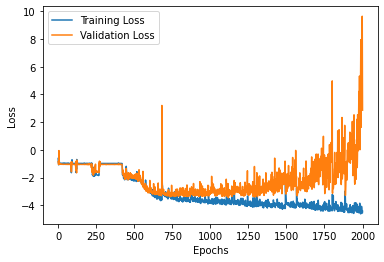

20/20 [==============================] - 1s 53ms/step - loss: -2.5515


20/20 [==============================] - 2s 48ms/step - loss: -3.7201
model number 6


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6188

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 21s 1s/step - loss: -0.6188 - val_loss: -0.8539
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8926

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -0.8926 - val_loss: -1.0030
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -1.0390

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -1.0390 - val_loss: -1.2794
Epoch 4/2000
15/15 [==============================] - ETA: 0s - loss: -1.4656

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 994ms/step - loss: -1.4656 - val_loss: -1.6592
Epoch 5/2000
15/15 [==============================] - 3s 187ms/step - loss: -1.8452 - val_loss: -1.3921
Epoch 6/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.2844 - val_loss: -1.5204
Epoch 7/2000
15/15 [==============================] - 3s 200ms/step - loss: -1.4162 - val_loss: -1.4697
Epoch 8/2000
15/15 [==============================] - ETA: 0s - loss: -1.6417

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -1.6417 - val_loss: -1.7462
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -1.8552

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -1.8552 - val_loss: -1.8033
Epoch 10/2000
15/15 [==============================] - ETA: 0s - loss: -1.9362

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 982ms/step - loss: -1.9362 - val_loss: -1.9902
Epoch 11/2000
15/15 [==============================] - ETA: 0s - loss: -2.1299

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.1299 - val_loss: -2.0446
Epoch 12/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.0508 - val_loss: -2.0081
Epoch 13/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0296 - val_loss: -1.9902
Epoch 14/2000
15/15 [==============================] - ETA: 0s - loss: -2.1069

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 15s 1s/step - loss: -2.1069 - val_loss: -2.1292
Epoch 15/2000
15/15 [==============================] - ETA: 0s - loss: -2.1825

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 990ms/step - loss: -2.1825 - val_loss: -2.2064
Epoch 16/2000
15/15 [==============================] - ETA: 0s - loss: -2.2747

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 17s 1s/step - loss: -2.2747 - val_loss: -2.2116
Epoch 17/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.0694 - val_loss: -1.9835
Epoch 18/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.9614 - val_loss: -1.8637
Epoch 19/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.9096 - val_loss: -1.9541
Epoch 20/2000
15/15 [==============================] - 3s 184ms/step - loss: -1.3596 - val_loss: -1.7914
Epoch 21/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.7094 - val_loss: -1.7362
Epoch 22/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.9065 - val_loss: -2.0929
Epoch 23/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.1782 - val_loss: -2.1687
Epoch 24/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.0893 - val_loss: -1.9363
Epoch 25/2000
15/15 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 999ms/step - loss: -2.1880 - val_loss: -2.2199
Epoch 26/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2497 - val_loss: -2.1804
Epoch 27/2000
15/15 [==============================] - ETA: 0s - loss: -2.2964

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.2964 - val_loss: -2.2277
Epoch 28/2000
15/15 [==============================] - ETA: 0s - loss: -2.3143

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3143 - val_loss: -2.2479
Epoch 29/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2668 - val_loss: -2.1141
Epoch 30/2000
15/15 [==============================] - ETA: 0s - loss: -2.2579

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.2579 - val_loss: -2.2716
Epoch 31/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2873 - val_loss: -2.1415
Epoch 32/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.2055 - val_loss: -2.2594
Epoch 33/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2547 - val_loss: -2.2347
Epoch 34/2000
15/15 [==============================] - ETA: 0s - loss: -2.2421

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 976ms/step - loss: -2.2421 - val_loss: -2.2824
Epoch 35/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2718 - val_loss: -2.1194
Epoch 36/2000
15/15 [==============================] - ETA: 0s - loss: -2.3058

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 17s 1s/step - loss: -2.3058 - val_loss: -2.3013
Epoch 37/2000
15/15 [==============================] - ETA: 0s - loss: -2.3045

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 977ms/step - loss: -2.3045 - val_loss: -2.3306
Epoch 38/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2817 - val_loss: -2.3157
Epoch 39/2000
15/15 [==============================] - ETA: 0s - loss: -2.3394

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3394 - val_loss: -2.3313
Epoch 40/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2878 - val_loss: -2.2022
Epoch 41/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2138 - val_loss: -2.2570
Epoch 42/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.1957 - val_loss: -2.2576
Epoch 43/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.3314 - val_loss: -2.2217
Epoch 44/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3133 - val_loss: -2.2096
Epoch 45/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.3104 - val_loss: -2.2078
Epoch 46/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3584 - val_loss: -2.2416
Epoch 47/2000
15/15 [==============================] - ETA: 0s - loss: -2.3420

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3420 - val_loss: -2.3637
Epoch 48/2000
15/15 [==============================] - 3s 201ms/step - loss: -2.3543 - val_loss: -2.3112
Epoch 49/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3564 - val_loss: -2.2999
Epoch 50/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3573 - val_loss: -2.2313
Epoch 51/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3107 - val_loss: -2.3271
Epoch 52/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3052 - val_loss: -2.2505
Epoch 53/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3119 - val_loss: -2.3489
Epoch 54/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2374 - val_loss: -2.2876
Epoch 55/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.1833 - val_loss: -1.9151
Epoch 56/2000
15/15 [==============================] - 3s 184ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3312 - val_loss: -2.3756
Epoch 67/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3482 - val_loss: -2.2385
Epoch 68/2000
15/15 [==============================] - ETA: 0s - loss: -2.2571

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 976ms/step - loss: -2.2571 - val_loss: -2.3813
Epoch 69/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.2898 - val_loss: -2.2802
Epoch 70/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3072 - val_loss: -2.3741
Epoch 71/2000
15/15 [==============================] - ETA: 0s - loss: -2.3732

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3732 - val_loss: -2.4062
Epoch 72/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3649 - val_loss: -2.3405
Epoch 73/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.3589 - val_loss: -2.3774
Epoch 74/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3183 - val_loss: -2.3999
Epoch 75/2000
15/15 [==============================] - 3s 184ms/step - loss: -2.3500 - val_loss: -2.3571
Epoch 76/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.3073 - val_loss: -2.3203
Epoch 77/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3139 - val_loss: -2.3300
Epoch 78/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3321 - val_loss: -2.2644
Epoch 79/2000
15/15 [==============================] - ETA: 0s - loss: -2.3516

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 983ms/step - loss: -2.3516 - val_loss: -2.4357
Epoch 80/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3835 - val_loss: -2.4321
Epoch 81/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3652 - val_loss: -2.3128
Epoch 82/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4005 - val_loss: -2.3895
Epoch 83/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.3257 - val_loss: -2.3273
Epoch 84/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.2902 - val_loss: -2.3451
Epoch 85/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3348 - val_loss: -2.3369
Epoch 86/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3589 - val_loss: -2.1982
Epoch 87/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.3633 - val_loss: -2.3950
Epoch 88/2000
15/15 [==============================] - 3s 193ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3802 - val_loss: -2.4511
Epoch 96/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.4002 - val_loss: -2.4181
Epoch 97/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.4214 - val_loss: -2.3905
Epoch 98/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3672 - val_loss: -2.2769
Epoch 99/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2056 - val_loss: -2.2328
Epoch 100/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.3007 - val_loss: -2.3517
Epoch 101/2000
15/15 [==============================] - ETA: 0s - loss: -2.3834

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 15s 1s/step - loss: -2.3834 - val_loss: -2.4709
Epoch 102/2000
15/15 [==============================] - ETA: 0s - loss: -2.3927

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3927 - val_loss: -2.4867
Epoch 103/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3464 - val_loss: -2.3731
Epoch 104/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.3873 - val_loss: -2.4545
Epoch 105/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.4043 - val_loss: -2.3955
Epoch 106/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3887 - val_loss: -2.2705
Epoch 107/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.3521 - val_loss: -2.4151
Epoch 108/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.4040 - val_loss: -2.4472
Epoch 109/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3724 - val_loss: -2.4391
Epoch 110/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4251 - val_loss: -2.4336
Epoch 111/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 986ms/step - loss: -2.4436 - val_loss: -2.4970
Epoch 114/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.4567 - val_loss: -2.4805
Epoch 115/2000
15/15 [==============================] - ETA: 0s - loss: -2.4141

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 17s 1s/step - loss: -2.4141 - val_loss: -2.4975
Epoch 116/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3854 - val_loss: -2.2422
Epoch 117/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2127 - val_loss: -2.1801
Epoch 118/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2015 - val_loss: -2.1205
Epoch 119/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.2137 - val_loss: -2.1947
Epoch 120/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2436 - val_loss: -2.0339
Epoch 121/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2153 - val_loss: -2.2946
Epoch 122/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2788 - val_loss: -2.3112
Epoch 123/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.2946 - val_loss: -2.2661
Epoch 124/2000
15/15 [==============================] - 3s 194m

15/15 [==============================] - 3s 198ms/step - loss: -2.3376 - val_loss: -2.2335
Epoch 270/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3507 - val_loss: -2.2472
Epoch 271/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3579 - val_loss: -2.1790
Epoch 272/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3386 - val_loss: -2.2371
Epoch 273/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3356 - val_loss: -2.1890
Epoch 274/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3512 - val_loss: -2.1658
Epoch 275/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.3637 - val_loss: -2.2185
Epoch 276/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.3614 - val_loss: -2.2449
Epoch 277/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.3010 - val_loss: -2.2854
Epoch 278/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 980ms/step - loss: -2.5091 - val_loss: -2.5216
Epoch 296/2000
15/15 [==============================] - ETA: 0s - loss: -2.5320

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.5320 - val_loss: -2.5498
Epoch 297/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3574 - val_loss: -2.3614
Epoch 298/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.3921 - val_loss: -2.4815
Epoch 299/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.4811 - val_loss: -2.5196
Epoch 300/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.5425 - val_loss: -2.4874
Epoch 301/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.5113 - val_loss: -2.5289
Epoch 302/2000
15/15 [==============================] - ETA: 0s - loss: -2.5775

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 15s 1s/step - loss: -2.5775 - val_loss: -2.6251
Epoch 303/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.6216 - val_loss: -2.3627
Epoch 304/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2561 - val_loss: -2.2675
Epoch 305/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3971 - val_loss: -2.1741
Epoch 306/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.4393 - val_loss: -2.5567
Epoch 307/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.5926 - val_loss: -2.5677
Epoch 308/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.5952 - val_loss: -2.5770
Epoch 309/2000
15/15 [==============================] - ETA: 0s - loss: -2.6870

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.6870 - val_loss: -2.7292
Epoch 310/2000
15/15 [==============================] - ETA: 0s - loss: -2.6814

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 992ms/step - loss: -2.6814 - val_loss: -2.7298
Epoch 311/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.5543 - val_loss: -2.6861
Epoch 312/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.6130 - val_loss: -2.7015
Epoch 313/2000
15/15 [==============================] - ETA: 0s - loss: -2.6913

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.6913 - val_loss: -2.7673
Epoch 314/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.7335 - val_loss: -2.5230
Epoch 315/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.7084 - val_loss: -2.7003
Epoch 316/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.5069 - val_loss: -2.4904
Epoch 317/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.5249 - val_loss: -2.6704
Epoch 318/2000
15/15 [==============================] - 3s 185ms/step - loss: -2.7068 - val_loss: -2.7328
Epoch 319/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.7852 - val_loss: -2.7373
Epoch 320/2000
15/15 [==============================] - ETA: 0s - loss: -2.8478

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 982ms/step - loss: -2.8478 - val_loss: -2.7918
Epoch 321/2000
15/15 [==============================] - ETA: 0s - loss: -2.9579

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.9579 - val_loss: -2.8129
Epoch 322/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.7988 - val_loss: -1.4901
Epoch 323/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.1702 - val_loss: -2.4595
Epoch 324/2000
15/15 [==============================] - 3s 187ms/step - loss: -2.4786 - val_loss: -2.6274
Epoch 325/2000
15/15 [==============================] - ETA: 0s - loss: -2.7174

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7174 - val_loss: -2.8456
Epoch 326/2000
15/15 [==============================] - ETA: 0s - loss: -2.8671

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -2.8671 - val_loss: -2.9197
Epoch 327/2000
15/15 [==============================] - ETA: 0s - loss: -2.9619

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 1s/step - loss: -2.9619 - val_loss: -3.0374
Epoch 328/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0508 - val_loss: -3.0165
Epoch 329/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0162 - val_loss: -2.8745
Epoch 330/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0789 - val_loss: -2.9893
Epoch 331/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.0573 - val_loss: -2.6506
Epoch 332/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.7679 - val_loss: -2.9948
Epoch 333/2000
15/15 [==============================] - 3s 183ms/step - loss: -2.8068 - val_loss: -2.8402
Epoch 334/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9495 - val_loss: -2.9653
Epoch 335/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0466 - val_loss: -2.8913
Epoch 336/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1199 - val_loss: -3.0530
Epoch 340/2000
15/15 [==============================] - ETA: 0s - loss: -3.1395

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 972ms/step - loss: -3.1395 - val_loss: -3.0661
Epoch 341/2000
15/15 [==============================] - ETA: 0s - loss: -3.0574

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.0574 - val_loss: -3.0828
Epoch 342/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1486 - val_loss: -3.0588
Epoch 343/2000
15/15 [==============================] - ETA: 0s - loss: -3.2047

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2047 - val_loss: -3.0968
Epoch 344/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1528 - val_loss: -3.0772
Epoch 345/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.8414 - val_loss: -2.8093
Epoch 346/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0029 - val_loss: -3.0509
Epoch 347/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0797 - val_loss: -2.9762
Epoch 348/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0897 - val_loss: -2.8860
Epoch 349/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1111 - val_loss: -3.0833
Epoch 350/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1733 - val_loss: -3.0824
Epoch 351/2000
15/15 [==============================] - ETA: 0s - loss: -3.2490

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2490 - val_loss: -3.1353
Epoch 352/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2965 - val_loss: -2.6492
Epoch 353/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.0103 - val_loss: -2.9423
Epoch 354/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1435 - val_loss: -3.0797
Epoch 355/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2030 - val_loss: -3.0347
Epoch 356/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1860 - val_loss: -2.7550
Epoch 357/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.0952 - val_loss: -3.1060
Epoch 358/2000
15/15 [==============================] - ETA: 0s - loss: -3.2416

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 983ms/step - loss: -3.2416 - val_loss: -3.1514
Epoch 359/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0884 - val_loss: -2.8270
Epoch 360/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.8118 - val_loss: -2.8998
Epoch 361/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.0434 - val_loss: -3.1075
Epoch 362/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2621 - val_loss: -3.1098
Epoch 363/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.2759 - val_loss: -2.8996
Epoch 364/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2651 - val_loss: -3.1416
Epoch 365/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.3017 - val_loss: -3.1106
Epoch 366/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3639 - val_loss: -3.1293
Epoch 367/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.5296 - val_loss: -3.1608
Epoch 421/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5254 - val_loss: -2.9710
Epoch 422/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3905 - val_loss: -3.1472
Epoch 423/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.5181 - val_loss: -2.9675
Epoch 424/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5078 - val_loss: -2.9100
Epoch 425/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.4082 - val_loss: -2.9739
Epoch 426/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.5009 - val_loss: -2.9241
Epoch 427/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5693 - val_loss: -2.7879
Epoch 428/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5183 - val_loss: -2.8800
Epoch 429/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 998ms/step - loss: -3.4545 - val_loss: -3.1965
Epoch 479/2000
15/15 [==============================] - ETA: 0s - loss: -3.5252

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.5252 - val_loss: -3.1997
Epoch 480/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.7225 - val_loss: -3.0036
Epoch 481/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6752 - val_loss: -2.9365
Epoch 482/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.7478 - val_loss: -2.8814
Epoch 483/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.7280 - val_loss: -2.8712
Epoch 484/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6738 - val_loss: -2.9916
Epoch 485/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5277 - val_loss: -2.9409
Epoch 486/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.6511 - val_loss: -2.9356
Epoch 487/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6379 - val_loss: -2.9860
Epoch 488/2000
15/15 [==============================] - 3s 200m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 15s 1s/step - loss: -3.2888 - val_loss: -3.2407
Epoch 550/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3101 - val_loss: -3.1935
Epoch 551/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3322 - val_loss: -3.0677
Epoch 552/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3942 - val_loss: -3.1063
Epoch 553/2000
15/15 [==============================] - ETA: 0s - loss: -3.4904

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 14s 985ms/step - loss: -3.4904 - val_loss: -3.2459
Epoch 554/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.4338 - val_loss: -3.1931
Epoch 555/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5056 - val_loss: -3.0554
Epoch 556/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.5204 - val_loss: -3.1930
Epoch 557/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5919 - val_loss: -3.1034
Epoch 558/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5476 - val_loss: -2.0126
Epoch 559/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1660 - val_loss: -3.1132
Epoch 560/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3123 - val_loss: -3.1262
Epoch 561/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4923 - val_loss: -3.1296
Epoch 562/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.3763 - val_loss: -3.2787
Epoch 573/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5325 - val_loss: -3.1951
Epoch 574/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4534 - val_loss: -3.0618
Epoch 575/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.5796 - val_loss: -3.1346
Epoch 576/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6109 - val_loss: -3.0235
Epoch 577/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.5458 - val_loss: -3.0566
Epoch 578/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.6369 - val_loss: -3.0556
Epoch 579/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6922 - val_loss: -2.9130
Epoch 580/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7146 - val_loss: -2.7335
Epoch 581/2000
15/15 [==============================] - 3s 190m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.7701 - val_loss: -3.3665
Epoch 616/2000
15/15 [==============================] - ETA: 0s - loss: -3.5937

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel6/assets


15/15 [==============================] - 16s 1s/step - loss: -3.5937 - val_loss: -3.4941
Epoch 617/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5221 - val_loss: -3.3267
Epoch 618/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6934 - val_loss: -2.7668
Epoch 619/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7923 - val_loss: -2.7411
Epoch 620/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.7369 - val_loss: -2.9000
Epoch 621/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.6809 - val_loss: -2.7964
Epoch 622/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.6993 - val_loss: -3.0777
Epoch 623/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.7939 - val_loss: -2.7505
Epoch 624/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5844 - val_loss: -3.0518
Epoch 625/2000
15/15 [==============================] - 3s 194m

15/15 [==============================] - 3s 195ms/step - loss: -3.6429 - val_loss: -3.3186
Epoch 771/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7473 - val_loss: -3.3031
Epoch 772/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7454 - val_loss: -3.4123
Epoch 773/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7240 - val_loss: -3.3236
Epoch 774/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.7851 - val_loss: -3.2111
Epoch 775/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.8089 - val_loss: -2.5726
Epoch 776/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.6814 - val_loss: -3.3051
Epoch 777/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.8163 - val_loss: -3.0778
Epoch 778/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8841 - val_loss: -3.1675
Epoch 779/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 188ms/step - loss: -3.8052 - val_loss: -3.0092
Epoch 925/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.8948 - val_loss: -2.9303
Epoch 926/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.9001 - val_loss: -2.8191
Epoch 927/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.9011 - val_loss: -2.9392
Epoch 928/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.7896 - val_loss: -2.7025
Epoch 929/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8278 - val_loss: -3.0037
Epoch 930/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9092 - val_loss: -2.7965
Epoch 931/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.8968 - val_loss: -2.4703
Epoch 932/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7293 - val_loss: -2.9306
Epoch 933/2000
15/15 [==============================] - 3s 18

15/15 [==============================] - 3s 187ms/step - loss: -3.8328 - val_loss: -2.9223
Epoch 1078/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9762 - val_loss: -2.4089
Epoch 1079/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7661 - val_loss: -2.9982
Epoch 1080/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7556 - val_loss: -3.1139
Epoch 1081/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8627 - val_loss: -2.6016
Epoch 1082/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.7719 - val_loss: -3.0724
Epoch 1083/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7931 - val_loss: -2.7639
Epoch 1084/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8722 - val_loss: -2.6579
Epoch 1085/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.8254 - val_loss: -2.7067
Epoch 1086/2000
15/15 [==============================

15/15 [==============================] - 3s 186ms/step - loss: -4.0871 - val_loss: -2.5003
Epoch 1230/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.1741 - val_loss: -2.0999
Epoch 1231/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.0571 - val_loss: -2.3528
Epoch 1232/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8578 - val_loss: -2.9098
Epoch 1233/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0904 - val_loss: -2.6613
Epoch 1234/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.1455 - val_loss: -2.1623
Epoch 1235/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.1138 - val_loss: -2.1559
Epoch 1236/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.1511 - val_loss: -2.2408
Epoch 1237/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.2016 - val_loss: -1.9719
Epoch 1238/2000
15/15 [==============================

15/15 [==============================] - 3s 197ms/step - loss: -4.1173 - val_loss: -2.3444
Epoch 1382/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.1437 - val_loss: -0.9087
Epoch 1383/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8882 - val_loss: -2.8727
Epoch 1384/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0779 - val_loss: -2.7621
Epoch 1385/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.1747 - val_loss: -1.9788
Epoch 1386/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.1146 - val_loss: -2.3413
Epoch 1387/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.1775 - val_loss: -2.0264
Epoch 1388/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.2109 - val_loss: -2.1662
Epoch 1389/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.2791 - val_loss: -1.7629
Epoch 1390/2000
15/15 [==============================

Epoch 1534/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.4094 - val_loss: -0.6027
Epoch 1535/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.2263 - val_loss: -1.0401
Epoch 1536/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2693 - val_loss: -1.3996
Epoch 1537/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.3788 - val_loss: -1.2591
Epoch 1538/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.3911 - val_loss: -0.4347
Epoch 1539/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4892 - val_loss: -0.6138
Epoch 1540/2000
15/15 [==============================] - 3s 199ms/step - loss: -4.6067 - val_loss: 1.1053
Epoch 1541/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.6123 - val_loss: 2.1194
Epoch 1542/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.1765 - val_loss: 1.0950
Epoch 1543/2000
15/15 [=================

Epoch 1687/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.6589 - val_loss: 2.2578
Epoch 1688/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.2135 - val_loss: 0.2318
Epoch 1689/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4907 - val_loss: -1.9745
Epoch 1690/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.9263 - val_loss: -2.9204
Epoch 1691/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.1617 - val_loss: -2.7269
Epoch 1692/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.3308 - val_loss: -2.2358
Epoch 1693/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.4767 - val_loss: -1.2186
Epoch 1694/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.3893 - val_loss: -1.2049
Epoch 1695/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.1316 - val_loss: -1.9256
Epoch 1696/2000
15/15 [================

15/15 [==============================] - 3s 198ms/step - loss: -4.7700 - val_loss: 1.9839
Epoch 1841/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.8131 - val_loss: 3.3516
Epoch 1842/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.7759 - val_loss: 3.3006
Epoch 1843/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.6156 - val_loss: 2.1020
Epoch 1844/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.4990 - val_loss: 0.3466
Epoch 1845/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.6225 - val_loss: 0.4017
Epoch 1846/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.6696 - val_loss: 1.2666
Epoch 1847/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.7101 - val_loss: 2.1768
Epoch 1848/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.8000 - val_loss: 3.1165
Epoch 1849/2000
15/15 [==============================] - 3s 18

15/15 [==============================] - 3s 192ms/step - loss: -4.9945 - val_loss: 7.0542
Epoch 1995/2000
15/15 [==============================] - 3s 199ms/step - loss: -5.0427 - val_loss: 8.5024
Epoch 1996/2000
15/15 [==============================] - 3s 202ms/step - loss: -4.7611 - val_loss: 8.1161
Epoch 1997/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7779 - val_loss: 0.9808
Epoch 1998/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.2447 - val_loss: -1.8654
Epoch 1999/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.4365 - val_loss: -1.6618
Epoch 2000/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.6283 - val_loss: -0.3728


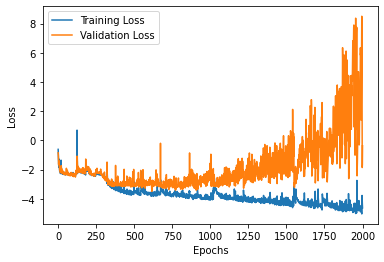

20/20 [==============================] - 1s 45ms/step - loss: -3.6249


20/20 [==============================] - 2s 52ms/step - loss: -3.7119
model number 7


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.3668

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 23s 1s/step - loss: -0.3668 - val_loss: -0.9147
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8505

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -0.8505 - val_loss: -0.9987
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9460

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 983ms/step - loss: -0.9460 - val_loss: -1.0104
Epoch 4/2000
15/15 [==============================] - 3s 185ms/step - loss: -0.9574 - val_loss: -1.0051
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9615

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9615 - val_loss: -1.0372
Epoch 6/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9639 - val_loss: -0.9613
Epoch 7/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9309 - val_loss: -0.9966
Epoch 8/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9403 - val_loss: -0.9873
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9481

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9481 - val_loss: -1.0413
Epoch 10/2000
15/15 [==============================] - 3s 203ms/step - loss: -0.9641 - val_loss: -1.0393
Epoch 11/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9638 - val_loss: -1.0133
Epoch 12/2000
15/15 [==============================] - ETA: 0s - loss: -0.9875

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 983ms/step - loss: -0.9875 - val_loss: -1.0637
Epoch 13/2000
15/15 [==============================] - ETA: 0s - loss: -1.0144

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -1.0144 - val_loss: -1.1478
Epoch 14/2000
15/15 [==============================] - ETA: 0s - loss: -1.1893

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -1.1893 - val_loss: -1.6627
Epoch 15/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.7163 - val_loss: -0.8746
Epoch 16/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9674 - val_loss: -1.1371
Epoch 17/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.1285 - val_loss: -1.2691
Epoch 18/2000
15/15 [==============================] - ETA: 0s - loss: -1.4543

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 988ms/step - loss: -1.4543 - val_loss: -1.6678
Epoch 19/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.2607 - val_loss: -1.2661
Epoch 20/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.3550 - val_loss: -1.6471
Epoch 21/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.6954 - val_loss: -1.3365
Epoch 22/2000
15/15 [==============================] - ETA: 0s - loss: -1.7449

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -1.7449 - val_loss: -1.7122
Epoch 23/2000
15/15 [==============================] - ETA: 0s - loss: -1.8076

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 990ms/step - loss: -1.8076 - val_loss: -1.7976
Epoch 24/2000
15/15 [==============================] - ETA: 0s - loss: -2.0381

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -2.0381 - val_loss: -2.1796
Epoch 25/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.9828 - val_loss: -2.0679
Epoch 26/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0179 - val_loss: -2.0537
Epoch 27/2000
15/15 [==============================] - ETA: 0s - loss: -2.0315

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -2.0315 - val_loss: -2.1987
Epoch 28/2000
15/15 [==============================] - ETA: 0s - loss: -2.2844

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 998ms/step - loss: -2.2844 - val_loss: -2.3444
Epoch 29/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2421 - val_loss: -2.2558
Epoch 30/2000
15/15 [==============================] - ETA: 0s - loss: -2.3059

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -2.3059 - val_loss: -2.4511
Epoch 31/2000
15/15 [==============================] - ETA: 0s - loss: -2.4600

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 980ms/step - loss: -2.4600 - val_loss: -2.6563
Epoch 32/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.6183 - val_loss: -1.3241
Epoch 33/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.9666 - val_loss: -2.2789
Epoch 34/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2588 - val_loss: -2.5083
Epoch 35/2000
15/15 [==============================] - ETA: 0s - loss: -2.5203

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -2.5203 - val_loss: -2.7709
Epoch 36/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.6907 - val_loss: -1.5084
Epoch 37/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5825 - val_loss: -1.8355
Epoch 38/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.3821 - val_loss: -2.3536
Epoch 39/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.5766 - val_loss: -2.7460
Epoch 40/2000
15/15 [==============================] - ETA: 0s - loss: -2.8085

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -2.8085 - val_loss: -3.0221
Epoch 41/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.4602 - val_loss: -2.6521
Epoch 42/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.6965 - val_loss: -2.8438
Epoch 43/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.8701 - val_loss: -2.8613
Epoch 44/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9050 - val_loss: -2.8307
Epoch 45/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5686 - val_loss: -2.7822
Epoch 46/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7288 - val_loss: -2.6981
Epoch 47/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.7693 - val_loss: -2.9268
Epoch 48/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.8920 - val_loss: -2.9086
Epoch 49/2000
15/15 [==============================] - 3s 194ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 992ms/step - loss: -3.0047 - val_loss: -3.1543
Epoch 54/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.0247 - val_loss: -2.8396
Epoch 55/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0427 - val_loss: -3.0698
Epoch 56/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.7942 - val_loss: -2.4857
Epoch 57/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7357 - val_loss: -2.8773
Epoch 58/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.8807 - val_loss: -2.8314
Epoch 59/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9389 - val_loss: -3.0809
Epoch 60/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0262 - val_loss: -2.9490
Epoch 61/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0196 - val_loss: -3.0560
Epoch 62/2000
15/15 [==============================] - 3s 187ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -3.0903 - val_loss: -3.1742
Epoch 74/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1365 - val_loss: -3.1651
Epoch 75/2000
15/15 [==============================] - 3s 183ms/step - loss: -2.8641 - val_loss: -2.7482
Epoch 76/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.9762 - val_loss: -3.1688
Epoch 77/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0450 - val_loss: -2.9949
Epoch 78/2000
15/15 [==============================] - 3s 206ms/step - loss: -3.0824 - val_loss: -3.0118
Epoch 79/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1117 - val_loss: -3.1117
Epoch 80/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.1569 - val_loss: -2.5991
Epoch 81/2000
15/15 [==============================] - ETA: 0s - loss: -3.1406

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1406 - val_loss: -3.2784
Epoch 82/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.9647 - val_loss: -3.0271
Epoch 83/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0375 - val_loss: -2.9988
Epoch 84/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0903 - val_loss: -3.1071
Epoch 85/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1477 - val_loss: -3.1479
Epoch 86/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.0946 - val_loss: -2.5713
Epoch 87/2000
15/15 [==============================] - 3s 186ms/step - loss: -2.7643 - val_loss: -2.9944
Epoch 88/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0847 - val_loss: -3.0914
Epoch 89/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1808 - val_loss: -3.2558
Epoch 90/2000
15/15 [==============================] - 3s 187ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 990ms/step - loss: -3.2938 - val_loss: -3.3256
Epoch 131/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0181 - val_loss: -3.0968
Epoch 132/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1913 - val_loss: -3.2682
Epoch 133/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2756 - val_loss: -2.5887
Epoch 134/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0597 - val_loss: -3.1763
Epoch 135/2000
15/15 [==============================] - ETA: 0s - loss: -3.2867

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -3.2867 - val_loss: -3.3367
Epoch 136/2000
15/15 [==============================] - ETA: 0s - loss: -3.2996

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2996 - val_loss: -3.3477
Epoch 137/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3749 - val_loss: -3.0827
Epoch 138/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.2248 - val_loss: -2.8547
Epoch 139/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3006 - val_loss: -3.1642
Epoch 140/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3776 - val_loss: -3.1347
Epoch 141/2000
15/15 [==============================] - 3s 184ms/step - loss: -3.3173 - val_loss: -3.3091
Epoch 142/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.2304 - val_loss: -3.1180
Epoch 143/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1544 - val_loss: -3.0621
Epoch 144/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1990 - val_loss: -3.1935
Epoch 145/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 985ms/step - loss: -3.3200 - val_loss: -3.3577
Epoch 186/2000
15/15 [==============================] - ETA: 0s - loss: -3.3372

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -3.3372 - val_loss: -3.3697
Epoch 187/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4432 - val_loss: -3.2384
Epoch 188/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2927 - val_loss: -3.3009
Epoch 189/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3584 - val_loss: -3.3123
Epoch 190/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0342 - val_loss: -2.8029
Epoch 191/2000
15/15 [==============================] - 3s 187ms/step - loss: -3.1763 - val_loss: -3.3112
Epoch 192/2000
15/15 [==============================] - ETA: 0s - loss: -3.4090

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 995ms/step - loss: -3.4090 - val_loss: -3.3851
Epoch 193/2000
15/15 [==============================] - 3s 205ms/step - loss: -3.4022 - val_loss: -3.2119
Epoch 194/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3098 - val_loss: -3.3771
Epoch 195/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4084 - val_loss: -3.0580
Epoch 196/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2738 - val_loss: -3.2273
Epoch 197/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.1572 - val_loss: -3.0493
Epoch 198/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2815 - val_loss: -3.2661
Epoch 199/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4257 - val_loss: -3.3770
Epoch 200/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3906 - val_loss: -3.3145
Epoch 201/2000
15/15 [==============================] - 3s 2

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4230 - val_loss: -3.3931
Epoch 211/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4226 - val_loss: -3.2997
Epoch 212/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3298 - val_loss: -3.3339
Epoch 213/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.3742 - val_loss: -3.3040
Epoch 214/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3153 - val_loss: -3.2092
Epoch 215/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.4269 - val_loss: -3.2736
Epoch 216/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4422 - val_loss: -3.2255
Epoch 217/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4805 - val_loss: -3.3308
Epoch 218/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.4770 - val_loss: -3.2836
Epoch 219/2000
15/15 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4487 - val_loss: -3.4006
Epoch 220/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3013 - val_loss: -3.1983
Epoch 221/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2793 - val_loss: -3.1843
Epoch 222/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3479 - val_loss: -3.1411
Epoch 223/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.3153 - val_loss: -3.2508
Epoch 224/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3536 - val_loss: -2.7373
Epoch 225/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1983 - val_loss: -3.1320
Epoch 226/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3239 - val_loss: -3.2959
Epoch 227/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4419 - val_loss: -3.3743
Epoch 228/2000
15/15 [==============================] - 3s 191m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 14s 982ms/step - loss: -3.4353 - val_loss: -3.4190
Epoch 265/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4951 - val_loss: -2.0106
Epoch 266/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.8840 - val_loss: -2.9662
Epoch 267/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0996 - val_loss: -3.2236
Epoch 268/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.3313 - val_loss: -3.2538
Epoch 269/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4029 - val_loss: -3.3489
Epoch 270/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4478 - val_loss: -3.0921
Epoch 271/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4167 - val_loss: -3.2292
Epoch 272/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2120 - val_loss: -3.0545
Epoch 273/2000
15/15 [==============================] - 3s 1

15/15 [==============================] - 3s 198ms/step - loss: -3.4730 - val_loss: -3.3610
Epoch 419/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5236 - val_loss: -3.1214
Epoch 420/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.5297 - val_loss: -3.0162
Epoch 421/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3781 - val_loss: -2.9744
Epoch 422/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2871 - val_loss: -3.1326
Epoch 423/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5114 - val_loss: -3.1771
Epoch 424/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.6362 - val_loss: -3.2601
Epoch 425/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.6449 - val_loss: -3.1707
Epoch 426/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5776 - val_loss: -3.3613
Epoch 427/2000
15/15 [==============================] - 3s 18

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel7/assets


15/15 [==============================] - 17s 1s/step - loss: -3.5557 - val_loss: -3.4785
Epoch 452/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.5090 - val_loss: -3.2473
Epoch 453/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6538 - val_loss: -3.0430
Epoch 454/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5151 - val_loss: -3.0225
Epoch 455/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3830 - val_loss: -3.1538
Epoch 456/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.6300 - val_loss: -3.2161
Epoch 457/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4700 - val_loss: -3.1687
Epoch 458/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3904 - val_loss: -3.2288
Epoch 459/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5629 - val_loss: -3.2251
Epoch 460/2000
15/15 [==============================] - 3s 199m

15/15 [==============================] - 3s 196ms/step - loss: -3.7933 - val_loss: -3.0956
Epoch 606/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8472 - val_loss: -2.1444
Epoch 607/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7905 - val_loss: -3.0593
Epoch 608/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7296 - val_loss: -2.5220
Epoch 609/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3544 - val_loss: -3.2224
Epoch 610/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6036 - val_loss: -3.0946
Epoch 611/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.7791 - val_loss: -2.4519
Epoch 612/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7671 - val_loss: -3.2445
Epoch 613/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7978 - val_loss: -2.8078
Epoch 614/2000
15/15 [==============================] - 3s 20

15/15 [==============================] - 3s 188ms/step - loss: -3.9435 - val_loss: -2.5917
Epoch 760/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8598 - val_loss: -2.9002
Epoch 761/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.9135 - val_loss: -2.7600
Epoch 762/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6969 - val_loss: -2.5492
Epoch 763/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.6597 - val_loss: -2.4616
Epoch 764/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3068 - val_loss: -2.9350
Epoch 765/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5088 - val_loss: -3.3595
Epoch 766/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7816 - val_loss: -2.9836
Epoch 767/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7217 - val_loss: -3.0282
Epoch 768/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 199ms/step - loss: -3.8809 - val_loss: -3.0842
Epoch 914/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.9673 - val_loss: -2.7924
Epoch 915/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.9977 - val_loss: -2.5495
Epoch 916/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0120 - val_loss: -2.3729
Epoch 917/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.9269 - val_loss: -2.6721
Epoch 918/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9728 - val_loss: -2.6994
Epoch 919/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.0716 - val_loss: -2.4630
Epoch 920/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.0841 - val_loss: -2.2931
Epoch 921/2000
15/15 [==============================] - 3s 199ms/step - loss: -4.0469 - val_loss: -2.2480
Epoch 922/2000
15/15 [==============================] - 3s 19

Epoch 1067/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.0677 - val_loss: -2.6905
Epoch 1068/2000
15/15 [==============================] - 3s 198ms/step - loss: -4.0987 - val_loss: -2.2544
Epoch 1069/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.0574 - val_loss: -2.1713
Epoch 1070/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0869 - val_loss: -2.6458
Epoch 1071/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1914 - val_loss: -1.9338
Epoch 1072/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.0218 - val_loss: -2.2036
Epoch 1073/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.0500 - val_loss: -2.4231
Epoch 1074/2000
15/15 [==============================] - 3s 199ms/step - loss: -4.0474 - val_loss: -1.7752
Epoch 1075/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8530 - val_loss: -2.7154
Epoch 1076/2000
15/15 [==============

15/15 [==============================] - 3s 197ms/step - loss: -4.0777 - val_loss: -2.7047
Epoch 1220/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.9963 - val_loss: -2.6670
Epoch 1221/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.0720 - val_loss: -3.0665
Epoch 1222/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.2534 - val_loss: -1.9455
Epoch 1223/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.2279 - val_loss: -1.9905
Epoch 1224/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1769 - val_loss: -1.8309
Epoch 1225/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.1078 - val_loss: -2.6680
Epoch 1226/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.1347 - val_loss: -1.7815
Epoch 1227/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.2217 - val_loss: -2.0216
Epoch 1228/2000
15/15 [==============================

15/15 [==============================] - 3s 188ms/step - loss: -4.1266 - val_loss: -2.3818
Epoch 1372/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.2596 - val_loss: -2.1429
Epoch 1373/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.1703 - val_loss: -1.3508
Epoch 1374/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7483 - val_loss: -1.9953
Epoch 1375/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.5656 - val_loss: -3.3181
Epoch 1376/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.8374 - val_loss: -3.2206
Epoch 1377/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.9950 - val_loss: -3.1279
Epoch 1378/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.0666 - val_loss: -2.9913
Epoch 1379/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.9825 - val_loss: -2.8615
Epoch 1380/2000
15/15 [==============================

Epoch 1524/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.3266 - val_loss: -1.2690
Epoch 1525/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.3405 - val_loss: -1.2752
Epoch 1526/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.3691 - val_loss: -1.0418
Epoch 1527/2000
15/15 [==============================] - 3s 203ms/step - loss: -4.3927 - val_loss: -0.2257
Epoch 1528/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.4371 - val_loss: -1.1975
Epoch 1529/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.5079 - val_loss: -0.5161
Epoch 1530/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.5682 - val_loss: 0.6316
Epoch 1531/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.5169 - val_loss: 0.3868
Epoch 1532/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.1868 - val_loss: -1.2160
Epoch 1533/2000
15/15 [================

Epoch 1677/2000
15/15 [==============================] - 3s 195ms/step - loss: -4.5907 - val_loss: 0.4013
Epoch 1678/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.7223 - val_loss: 1.9782
Epoch 1679/2000
15/15 [==============================] - 3s 191ms/step - loss: -4.7671 - val_loss: 2.0870
Epoch 1680/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.7498 - val_loss: 2.8505
Epoch 1681/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4097 - val_loss: 4.4061
Epoch 1682/2000
15/15 [==============================] - 3s 186ms/step - loss: -4.2366 - val_loss: -0.8683
Epoch 1683/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2617 - val_loss: -1.8225
Epoch 1684/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.3677 - val_loss: -1.2438
Epoch 1685/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.3687 - val_loss: -0.8043
Epoch 1686/2000
15/15 [===================

Epoch 1754/2000
15/15 [==============================] - 3s 189ms/step - loss: -4.5679 - val_loss: 0.3637
Epoch 1755/2000
15/15 [==============================] - 3s 197ms/step - loss: -4.5986 - val_loss: 1.4543
Epoch 1756/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.5634 - val_loss: 1.1523
Epoch 1757/2000
15/15 [==============================] - 3s 199ms/step - loss: -4.6750 - val_loss: 1.5979
Epoch 1758/2000
15/15 [==============================] - 3s 200ms/step - loss: -4.7208 - val_loss: 1.9425
Epoch 1759/2000
15/15 [==============================] - 3s 194ms/step - loss: -4.8083 - val_loss: 4.9924
Epoch 1760/2000
15/15 [==============================] - 3s 201ms/step - loss: -4.6320 - val_loss: 3.0905
Epoch 1761/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4804 - val_loss: 1.0251
Epoch 1762/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.5085 - val_loss: 1.9752
Epoch 1763/2000
15/15 [=======================

15/15 [==============================] - 3s 190ms/step - loss: -4.1312 - val_loss: -1.9861
Epoch 1909/2000
15/15 [==============================] - 3s 187ms/step - loss: -4.2271 - val_loss: -1.6332
Epoch 1910/2000
15/15 [==============================] - 3s 188ms/step - loss: -4.2507 - val_loss: -1.4478
Epoch 1911/2000
15/15 [==============================] - 3s 190ms/step - loss: -4.3166 - val_loss: -0.8882
Epoch 1912/2000
15/15 [==============================] - 3s 196ms/step - loss: -4.4162 - val_loss: -0.4036
Epoch 1913/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4493 - val_loss: -0.0220
Epoch 1914/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.4518 - val_loss: 0.4317
Epoch 1915/2000
15/15 [==============================] - 3s 192ms/step - loss: -4.5654 - val_loss: 0.9873
Epoch 1916/2000
15/15 [==============================] - 3s 193ms/step - loss: -4.5855 - val_loss: 1.3165
Epoch 1917/2000
15/15 [==============================] -

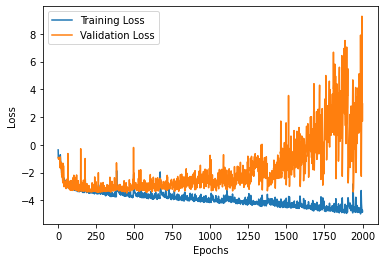

20/20 [==============================] - 1s 52ms/step - loss: -2.8431


20/20 [==============================] - 2s 51ms/step - loss: -3.5625
model number 8


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6503

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 20s 1s/step - loss: -0.6503 - val_loss: -0.8757
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8904

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -0.8904 - val_loss: -1.0140
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9571

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9571 - val_loss: -1.0242
Epoch 4/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9610 - val_loss: -1.0083
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9586

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 989ms/step - loss: -0.9586 - val_loss: -1.0400
Epoch 6/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9379 - val_loss: -0.9373
Epoch 7/2000
15/15 [==============================] - ETA: 0s - loss: -0.9309

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9309 - val_loss: -1.0436
Epoch 8/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9512 - val_loss: -1.0085
Epoch 9/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9527 - val_loss: -1.0411
Epoch 10/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9660 - val_loss: -1.0360
Epoch 11/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9660 - val_loss: -1.0333
Epoch 12/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9669 - val_loss: -1.0338
Epoch 13/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9647 - val_loss: -1.0331
Epoch 14/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9679 - val_loss: -1.0399
Epoch 15/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9645 - val_loss: -1.0321
Epoch 16/2000
15/15 [==============================] - 3s 192ms/step - lo

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 986ms/step - loss: -0.9714 - val_loss: -1.0462
Epoch 19/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9690 - val_loss: -1.0314
Epoch 20/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9695 - val_loss: -1.0440
Epoch 21/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9677 - val_loss: -1.0426
Epoch 22/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9628 - val_loss: -1.0292
Epoch 23/2000
15/15 [==============================] - ETA: 0s - loss: -0.9690

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9690 - val_loss: -1.0475
Epoch 24/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9720 - val_loss: -1.0458
Epoch 25/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9662 - val_loss: -1.0399
Epoch 26/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9708 - val_loss: -1.0439
Epoch 27/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9721 - val_loss: -1.0376
Epoch 28/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9627 - val_loss: -1.0407
Epoch 29/2000
15/15 [==============================] - ETA: 0s - loss: -0.9759

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9759 - val_loss: -1.0495
Epoch 30/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9697 - val_loss: -1.0395
Epoch 31/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9666 - val_loss: -1.0474
Epoch 32/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9707 - val_loss: -1.0464
Epoch 33/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9715 - val_loss: -1.0456
Epoch 34/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9653 - val_loss: -1.0364
Epoch 35/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9538 - val_loss: -1.0375
Epoch 36/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9719 - val_loss: -1.0462
Epoch 37/2000
15/15 [==============================] - ETA: 0s - loss: -0.9768

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9768 - val_loss: -1.0518
Epoch 38/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9742 - val_loss: -1.0419
Epoch 39/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9738 - val_loss: -1.0447
Epoch 40/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9711 - val_loss: -1.0418
Epoch 41/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9624 - val_loss: -1.0489
Epoch 42/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9786 - val_loss: -1.0433
Epoch 43/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9729 - val_loss: -1.0422
Epoch 44/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9694 - val_loss: -1.0419
Epoch 45/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9727 - val_loss: -1.0431
Epoch 46/2000
15/15 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9762 - val_loss: -1.0525
Epoch 47/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9752 - val_loss: -1.0446
Epoch 48/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9659 - val_loss: -1.0476
Epoch 49/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9755 - val_loss: -1.0427
Epoch 50/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9742 - val_loss: -1.0437
Epoch 51/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9705 - val_loss: -1.0463
Epoch 52/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9803 - val_loss: -1.0441
Epoch 53/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9754 - val_loss: -1.0453
Epoch 54/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9766 - val_loss: -1.0519
Epoch 55/2000
15/15 [==============================] - 3s 195ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9770 - val_loss: -1.0525
Epoch 77/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9774 - val_loss: -1.0517
Epoch 78/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9792 - val_loss: -1.0367
Epoch 79/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9746 - val_loss: -1.0451
Epoch 80/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9782 - val_loss: -1.0487
Epoch 81/2000
15/15 [==============================] - ETA: 0s - loss: -0.9776

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9776 - val_loss: -1.0534
Epoch 82/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9798 - val_loss: -1.0466
Epoch 83/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9782 - val_loss: -1.0467
Epoch 84/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9787 - val_loss: -1.0484
Epoch 85/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9774 - val_loss: -1.0482
Epoch 86/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9777 - val_loss: -1.0452
Epoch 87/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9713 - val_loss: -1.0516
Epoch 88/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9767 - val_loss: -1.0445
Epoch 89/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9794 - val_loss: -1.0472
Epoch 90/2000
15/15 [==============================] - 3s 199ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 989ms/step - loss: -0.9766 - val_loss: -1.0549
Epoch 97/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9779 - val_loss: -1.0422
Epoch 98/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9787 - val_loss: -1.0487
Epoch 99/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9757 - val_loss: -1.0483
Epoch 100/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9760 - val_loss: -1.0518
Epoch 101/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9802 - val_loss: -1.0441
Epoch 102/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9746 - val_loss: -1.0505
Epoch 103/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9774 - val_loss: -1.0458
Epoch 104/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9775 - val_loss: -1.0539
Epoch 105/2000
15/15 [==============================] - 3s 195m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9803 - val_loss: -1.0572
Epoch 112/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9777 - val_loss: -1.0491
Epoch 113/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9797 - val_loss: -1.0491
Epoch 114/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9756 - val_loss: -1.0448
Epoch 115/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9759 - val_loss: -1.0543
Epoch 116/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9799 - val_loss: -1.0441
Epoch 117/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9805 - val_loss: -1.0500
Epoch 118/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9797 - val_loss: -1.0483
Epoch 119/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9766 - val_loss: -1.0522
Epoch 120/2000
15/15 [==============================] - 3s 193m

15/15 [==============================] - 3s 192ms/step - loss: -0.9823 - val_loss: -1.0512
Epoch 266/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9791 - val_loss: -1.0498
Epoch 267/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9801 - val_loss: -1.0516
Epoch 268/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9808 - val_loss: -1.0516
Epoch 269/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9793 - val_loss: -1.0454
Epoch 270/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9814 - val_loss: -1.0490
Epoch 271/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9801 - val_loss: -1.0530
Epoch 272/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9815 - val_loss: -1.0476
Epoch 273/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9813 - val_loss: -1.0511
Epoch 274/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 191ms/step - loss: -0.9828 - val_loss: -1.0504
Epoch 420/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9800 - val_loss: -1.0440
Epoch 421/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9811 - val_loss: -1.0540
Epoch 422/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9822 - val_loss: -1.0520
Epoch 423/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9811 - val_loss: -1.0498
Epoch 424/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9826 - val_loss: -1.0501
Epoch 425/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9776 - val_loss: -1.0490
Epoch 426/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9768 - val_loss: -1.0516
Epoch 427/2000
15/15 [==============================] - 3s 203ms/step - loss: -0.9776 - val_loss: -1.0512
Epoch 428/2000
15/15 [==============================] - 3s 19

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9782 - val_loss: -1.0576
Epoch 512/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9817 - val_loss: -1.0507
Epoch 513/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9786 - val_loss: -1.0456
Epoch 514/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9805 - val_loss: -1.0517
Epoch 515/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9820 - val_loss: -1.0491
Epoch 516/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9809 - val_loss: -1.0504
Epoch 517/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9808 - val_loss: -1.0534
Epoch 518/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9812 - val_loss: -1.0512
Epoch 519/2000
15/15 [==============================] - 3s 185ms/step - loss: -0.9817 - val_loss: -1.0523
Epoch 520/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 996ms/step - loss: -0.9927 - val_loss: -1.0890
Epoch 566/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.0736 - val_loss: -1.0337
Epoch 567/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9283 - val_loss: -1.0692
Epoch 568/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9680 - val_loss: -1.0594
Epoch 569/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9983 - val_loss: -1.0826
Epoch 570/2000
15/15 [==============================] - ETA: 0s - loss: -1.0674

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -1.0674 - val_loss: -1.2632
Epoch 571/2000
15/15 [==============================] - ETA: 0s - loss: -1.4315

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 985ms/step - loss: -1.4315 - val_loss: -1.2961
Epoch 572/2000
15/15 [==============================] - ETA: 0s - loss: -1.3984

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.3984 - val_loss: -1.6770
Epoch 573/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.6279 - val_loss: -1.6745
Epoch 574/2000
15/15 [==============================] - ETA: 0s - loss: -1.6473

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 978ms/step - loss: -1.6473 - val_loss: -1.7157
Epoch 575/2000
15/15 [==============================] - 3s 201ms/step - loss: -1.1733 - val_loss: -0.9033
Epoch 576/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.1911 - val_loss: -1.3752
Epoch 577/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.5228 - val_loss: -1.6161
Epoch 578/2000
15/15 [==============================] - ETA: 0s - loss: -1.6339

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.6339 - val_loss: -1.7207
Epoch 579/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9802 - val_loss: -1.3571
Epoch 580/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.3481 - val_loss: -1.4321
Epoch 581/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.5427 - val_loss: -1.6590
Epoch 582/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.6613 - val_loss: -0.9606
Epoch 583/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.5169 - val_loss: -1.6628
Epoch 584/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.6619 - val_loss: -1.5984
Epoch 585/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.7829 - val_loss: -1.6835
Epoch 586/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.8308 - val_loss: -1.7047
Epoch 587/2000
15/15 [==============================] - 3s 188m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 986ms/step - loss: -1.8074 - val_loss: -1.7212
Epoch 593/2000
15/15 [==============================] - ETA: 0s - loss: -1.7549

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.7549 - val_loss: -1.7546
Epoch 594/2000
15/15 [==============================] - ETA: 0s - loss: -1.7297

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.7297 - val_loss: -1.7949
Epoch 595/2000
15/15 [==============================] - ETA: 0s - loss: -1.6663

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 984ms/step - loss: -1.6663 - val_loss: -1.8342
Epoch 596/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.6972 - val_loss: -1.7917
Epoch 597/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.6680 - val_loss: -1.6489
Epoch 598/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.7034 - val_loss: -1.6980
Epoch 599/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.7214 - val_loss: -1.8039
Epoch 600/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7349 - val_loss: -1.7415
Epoch 601/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7686 - val_loss: -1.8173
Epoch 602/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.7116 - val_loss: -1.7567
Epoch 603/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.7368 - val_loss: -1.7570
Epoch 604/2000
15/15 [==============================] - 3s 2

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.7639 - val_loss: -1.8643
Epoch 608/2000
15/15 [==============================] - ETA: 0s - loss: -1.7891

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 1s/step - loss: -1.7891 - val_loss: -1.8835
Epoch 609/2000
15/15 [==============================] - 3s 200ms/step - loss: -1.8170 - val_loss: -1.8584
Epoch 610/2000
15/15 [==============================] - ETA: 0s - loss: -1.8831

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -1.8831 - val_loss: -2.0105
Epoch 611/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.8041 - val_loss: -1.6106
Epoch 612/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.6824 - val_loss: -1.8185
Epoch 613/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8442 - val_loss: -1.8998
Epoch 614/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.9767 - val_loss: -1.9789
Epoch 615/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.7356 - val_loss: -1.4182
Epoch 616/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.7718 - val_loss: -1.9663
Epoch 617/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.9794 - val_loss: -1.5682
Epoch 618/2000
15/15 [==============================] - ETA: 0s - loss: -1.9049

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -1.9049 - val_loss: -2.0246
Epoch 619/2000
15/15 [==============================] - ETA: 0s - loss: -2.0362

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.0362 - val_loss: -2.0916
Epoch 620/2000
15/15 [==============================] - ETA: 0s - loss: -2.1003

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -2.1003 - val_loss: -2.1315
Epoch 621/2000
15/15 [==============================] - ETA: 0s - loss: -2.2110

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 993ms/step - loss: -2.2110 - val_loss: -2.1690
Epoch 622/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.1702 - val_loss: 0.3952
Epoch 623/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9198 - val_loss: -1.7220
Epoch 624/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.6556 - val_loss: -1.8240
Epoch 625/2000
15/15 [==============================] - 3s 196ms/step - loss: -1.8074 - val_loss: -1.8862
Epoch 626/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.8778 - val_loss: -1.8659
Epoch 627/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.9041 - val_loss: -1.8519
Epoch 628/2000
15/15 [==============================] - 3s 197ms/step - loss: -1.9449 - val_loss: -2.0578
Epoch 629/2000
15/15 [==============================] - 3s 203ms/step - loss: -1.9711 - val_loss: -1.9623
Epoch 630/2000
15/15 [==============================] - 3s 20

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -2.0936 - val_loss: -2.1935
Epoch 637/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.1453 - val_loss: -2.1567
Epoch 638/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.1526 - val_loss: -2.0658
Epoch 639/2000
15/15 [==============================] - ETA: 0s - loss: -2.2101

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.2101 - val_loss: -2.2365
Epoch 640/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.1924 - val_loss: -2.1571
Epoch 641/2000
15/15 [==============================] - ETA: 0s - loss: -2.1996

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 995ms/step - loss: -2.1996 - val_loss: -2.2373
Epoch 642/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.2104 - val_loss: -2.1592
Epoch 643/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.1984 - val_loss: -2.1717
Epoch 644/2000
15/15 [==============================] - ETA: 0s - loss: -2.1672

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -2.1672 - val_loss: -2.2766
Epoch 645/2000
15/15 [==============================] - ETA: 0s - loss: -2.2308

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 983ms/step - loss: -2.2308 - val_loss: -2.2823
Epoch 646/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.2448 - val_loss: -2.1575
Epoch 647/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.2121 - val_loss: -2.2788
Epoch 648/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2859 - val_loss: -2.1119
Epoch 649/2000
15/15 [==============================] - ETA: 0s - loss: -2.2361

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.2361 - val_loss: -2.3223
Epoch 650/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2240 - val_loss: -2.2498
Epoch 651/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.2302 - val_loss: -2.2586
Epoch 652/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.2760 - val_loss: -2.2904
Epoch 653/2000
15/15 [==============================] - ETA: 0s - loss: -2.3311

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.3311 - val_loss: -2.3656
Epoch 654/2000
15/15 [==============================] - ETA: 0s - loss: -2.3498

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 985ms/step - loss: -2.3498 - val_loss: -2.4758
Epoch 655/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.2596 - val_loss: -2.4093
Epoch 656/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3106 - val_loss: -2.3743
Epoch 657/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3457 - val_loss: -2.3560
Epoch 658/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.3619 - val_loss: -2.3780
Epoch 659/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3494 - val_loss: -2.2928
Epoch 660/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.3264 - val_loss: -2.4428
Epoch 661/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.3897 - val_loss: -2.2866
Epoch 662/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.2995 - val_loss: -2.1916
Epoch 663/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -2.4456 - val_loss: -2.5010
Epoch 672/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.3385 - val_loss: -2.0931
Epoch 673/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2696 - val_loss: -2.3874
Epoch 674/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.3694 - val_loss: -2.2339
Epoch 675/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2686 - val_loss: -2.3558
Epoch 676/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.1406 - val_loss: -2.3996
Epoch 677/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.3511 - val_loss: -2.4498
Epoch 678/2000
15/15 [==============================] - ETA: 0s - loss: -2.4331

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 1s/step - loss: -2.4331 - val_loss: -2.5530
Epoch 679/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.3826 - val_loss: -2.3099
Epoch 680/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.2059 - val_loss: -2.4191
Epoch 681/2000
15/15 [==============================] - ETA: 0s - loss: -2.4774

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.4774 - val_loss: -2.5623
Epoch 682/2000
15/15 [==============================] - ETA: 0s - loss: -2.5564

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 985ms/step - loss: -2.5564 - val_loss: -2.6808
Epoch 683/2000
15/15 [==============================] - ETA: 0s - loss: -2.5988

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.5988 - val_loss: -2.7295
Epoch 684/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.6625 - val_loss: -2.6437
Epoch 685/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7044 - val_loss: -2.4137
Epoch 686/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.4160 - val_loss: -2.4911
Epoch 687/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.4857 - val_loss: -2.6076
Epoch 688/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.5747 - val_loss: -2.6654
Epoch 689/2000
15/15 [==============================] - ETA: 0s - loss: -2.6624

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 994ms/step - loss: -2.6624 - val_loss: -2.8077
Epoch 690/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7070 - val_loss: -2.6895
Epoch 691/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.6134 - val_loss: -2.6263
Epoch 692/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.5973 - val_loss: -2.6431
Epoch 693/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.6768 - val_loss: -2.7967
Epoch 694/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.6889 - val_loss: -2.3197
Epoch 695/2000
15/15 [==============================] - ETA: 0s - loss: -2.6336

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.6336 - val_loss: -2.8964
Epoch 696/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.8435 - val_loss: -2.7571
Epoch 697/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7548 - val_loss: -2.6830
Epoch 698/2000
15/15 [==============================] - 3s 201ms/step - loss: -2.7112 - val_loss: -2.8471
Epoch 699/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.7285 - val_loss: -2.7082
Epoch 700/2000
15/15 [==============================] - ETA: 0s - loss: -2.7817

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.7817 - val_loss: -2.9079
Epoch 701/2000
15/15 [==============================] - ETA: 0s - loss: -2.8387

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 991ms/step - loss: -2.8387 - val_loss: -3.0075
Epoch 702/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8949 - val_loss: -2.8436
Epoch 703/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.6576 - val_loss: -2.8748
Epoch 704/2000
15/15 [==============================] - ETA: 0s - loss: -2.8984

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -2.8984 - val_loss: -3.0105
Epoch 705/2000
15/15 [==============================] - ETA: 0s - loss: -2.9933

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 978ms/step - loss: -2.9933 - val_loss: -3.0450
Epoch 706/2000
15/15 [==============================] - ETA: 0s - loss: -2.9817

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.9817 - val_loss: -3.0820
Epoch 707/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.9657 - val_loss: -3.0607
Epoch 708/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.7922 - val_loss: -3.0431
Epoch 709/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.3938 - val_loss: -2.8815
Epoch 710/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.7122 - val_loss: -2.8225
Epoch 711/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.8040 - val_loss: -2.8699
Epoch 712/2000
15/15 [==============================] - 3s 197ms/step - loss: -2.8956 - val_loss: -2.9235
Epoch 713/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.9130 - val_loss: -2.8483
Epoch 714/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.8376 - val_loss: -2.7515
Epoch 715/2000
15/15 [==============================] - 3s 195m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -2.9872 - val_loss: -3.0984
Epoch 733/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0321 - val_loss: -2.8781
Epoch 734/2000
15/15 [==============================] - ETA: 0s - loss: -3.0045

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 993ms/step - loss: -3.0045 - val_loss: -3.1083
Epoch 735/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0688 - val_loss: -3.0869
Epoch 736/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0788 - val_loss: -3.0144
Epoch 737/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.0342 - val_loss: -2.9625
Epoch 738/2000
15/15 [==============================] - ETA: 0s - loss: -3.0134

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -3.0134 - val_loss: -3.1277
Epoch 739/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0269 - val_loss: -3.0592
Epoch 740/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.0331 - val_loss: -3.0358
Epoch 741/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0626 - val_loss: -3.0852
Epoch 742/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1029 - val_loss: -3.0171
Epoch 743/2000
15/15 [==============================] - ETA: 0s - loss: -3.0513

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 985ms/step - loss: -3.0513 - val_loss: -3.1586
Epoch 744/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9236 - val_loss: -2.9221
Epoch 745/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8299 - val_loss: -3.0423
Epoch 746/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0113 - val_loss: -3.0793
Epoch 747/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0791 - val_loss: -3.0654
Epoch 748/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1079 - val_loss: -3.0816
Epoch 749/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.0526 - val_loss: -2.8254
Epoch 750/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0104 - val_loss: -2.3244
Epoch 751/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4624 - val_loss: -2.6855
Epoch 752/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1660 - val_loss: -3.1620
Epoch 765/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.9715 - val_loss: -2.5658
Epoch 766/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9567 - val_loss: -3.1347
Epoch 767/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.9716 - val_loss: -3.0259
Epoch 768/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0988 - val_loss: -3.0831
Epoch 769/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.1435 - val_loss: -3.1156
Epoch 770/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2297 - val_loss: -3.1617
Epoch 771/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.1741 - val_loss: -2.9688
Epoch 772/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0466 - val_loss: -2.6948
Epoch 773/2000
15/15 [==============================] - 3s 200m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -3.3427 - val_loss: -3.2095
Epoch 798/2000
15/15 [==============================] - ETA: 0s - loss: -3.4069

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 999ms/step - loss: -3.4069 - val_loss: -3.2531
Epoch 799/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3968 - val_loss: -3.2032
Epoch 800/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2668 - val_loss: -2.8896
Epoch 801/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.9867 - val_loss: -2.9475
Epoch 802/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.0230 - val_loss: -3.0731
Epoch 803/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.2543 - val_loss: -3.0427
Epoch 804/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3463 - val_loss: -2.9938
Epoch 805/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2382 - val_loss: -3.2186
Epoch 806/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3173 - val_loss: -2.8357
Epoch 807/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -3.2986 - val_loss: -3.2735
Epoch 826/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1666 - val_loss: -3.1980
Epoch 827/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.3381 - val_loss: -3.0590
Epoch 828/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3951 - val_loss: -3.2398
Epoch 829/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4191 - val_loss: -3.1141
Epoch 830/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3568 - val_loss: -3.1892
Epoch 831/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.2721 - val_loss: -2.9983
Epoch 832/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3665 - val_loss: -3.2315
Epoch 833/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3686 - val_loss: -3.2445
Epoch 834/2000
15/15 [==============================] - 3s 205m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 998ms/step - loss: -3.4153 - val_loss: -3.2851
Epoch 902/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5159 - val_loss: -3.2180
Epoch 903/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.4986 - val_loss: -3.2645
Epoch 904/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4539 - val_loss: -3.2479
Epoch 905/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.3681 - val_loss: -2.8268
Epoch 906/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5009 - val_loss: -3.1624
Epoch 907/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4926 - val_loss: -3.0583
Epoch 908/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1984 - val_loss: -3.2062
Epoch 909/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3098 - val_loss: -3.1761
Epoch 910/2000
15/15 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4489 - val_loss: -3.3183
Epoch 946/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6267 - val_loss: -3.0687
Epoch 947/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5123 - val_loss: -2.9766
Epoch 948/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5936 - val_loss: -2.8537
Epoch 949/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.2373 - val_loss: -3.0300
Epoch 950/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.3825 - val_loss: -3.2325
Epoch 951/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5607 - val_loss: -3.2953
Epoch 952/2000
15/15 [==============================] - ETA: 0s - loss: -3.4433

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 16s 1s/step - loss: -3.4433 - val_loss: -3.3271
Epoch 953/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3862 - val_loss: -3.2405
Epoch 954/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5542 - val_loss: -3.1831
Epoch 955/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5247 - val_loss: -3.0511
Epoch 956/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5905 - val_loss: -3.1929
Epoch 957/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.6499 - val_loss: -3.2276
Epoch 958/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5723 - val_loss: -3.2361
Epoch 959/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5906 - val_loss: -3.0155
Epoch 960/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4221 - val_loss: -3.1330
Epoch 961/2000
15/15 [==============================] - 3s 194m

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 14s 995ms/step - loss: -3.5671 - val_loss: -3.3759
Epoch 1103/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3912 - val_loss: -3.0642
Epoch 1104/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1504 - val_loss: -2.6834
Epoch 1105/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2019 - val_loss: -3.0600
Epoch 1106/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.4562 - val_loss: -3.0975
Epoch 1107/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4927 - val_loss: -3.0792
Epoch 1108/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5525 - val_loss: -2.6434
Epoch 1109/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1716 - val_loss: -2.6565
Epoch 1110/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3568 - val_loss: -3.1240
Epoch 1111/2000
15/15 [=============================

15/15 [==============================] - 3s 192ms/step - loss: -3.5021 - val_loss: -3.0243
Epoch 1255/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5927 - val_loss: -2.6781
Epoch 1256/2000
15/15 [==============================] - 3s 185ms/step - loss: -3.4539 - val_loss: -2.9366
Epoch 1257/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3625 - val_loss: -3.1576
Epoch 1258/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5442 - val_loss: -3.2230
Epoch 1259/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6248 - val_loss: -3.1722
Epoch 1260/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.6542 - val_loss: -3.0746
Epoch 1261/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2990 - val_loss: -3.1354
Epoch 1262/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3709 - val_loss: -3.1812
Epoch 1263/2000
15/15 [==============================

15/15 [==============================] - 3s 198ms/step - loss: -3.6318 - val_loss: -2.5691
Epoch 1407/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4498 - val_loss: -3.1384
Epoch 1408/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6496 - val_loss: -3.1287
Epoch 1409/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6808 - val_loss: -2.8652
Epoch 1410/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.6764 - val_loss: -2.8989
Epoch 1411/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.6763 - val_loss: -3.0654
Epoch 1412/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.6689 - val_loss: -3.1187
Epoch 1413/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6661 - val_loss: -3.0638
Epoch 1414/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.4750 - val_loss: -2.4398
Epoch 1415/2000
15/15 [==============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel8/assets


15/15 [==============================] - 17s 1s/step - loss: -3.5284 - val_loss: -3.4143
Epoch 1486/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4276 - val_loss: -3.0799
Epoch 1487/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.4630 - val_loss: -3.1513
Epoch 1488/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3927 - val_loss: -3.3302
Epoch 1489/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4340 - val_loss: -3.3241
Epoch 1490/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.5303 - val_loss: -3.3078
Epoch 1491/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4090 - val_loss: -3.4036
Epoch 1492/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.5762 - val_loss: -2.8431
Epoch 1493/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5331 - val_loss: -3.1145
Epoch 1494/2000
15/15 [==============================] 

15/15 [==============================] - 3s 201ms/step - loss: -3.8443 - val_loss: -2.9049
Epoch 1638/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.8191 - val_loss: -3.0151
Epoch 1639/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.7478 - val_loss: -3.0169
Epoch 1640/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.6497 - val_loss: -2.9832
Epoch 1641/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5252 - val_loss: -2.5942
Epoch 1642/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5309 - val_loss: -3.2413
Epoch 1643/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5416 - val_loss: -3.2227
Epoch 1644/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.5515 - val_loss: -3.2749
Epoch 1645/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6878 - val_loss: -3.1202
Epoch 1646/2000
15/15 [==============================

15/15 [==============================] - 3s 189ms/step - loss: -3.6447 - val_loss: -2.8620
Epoch 1790/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4876 - val_loss: -2.7321
Epoch 1791/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4961 - val_loss: -3.1150
Epoch 1792/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.6579 - val_loss: -3.0237
Epoch 1793/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7690 - val_loss: -2.9520
Epoch 1794/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8276 - val_loss: -2.9264
Epoch 1795/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.8327 - val_loss: -2.9482
Epoch 1796/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.7572 - val_loss: -2.7075
Epoch 1797/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.6525 - val_loss: -2.5381
Epoch 1798/2000
15/15 [==============================

15/15 [==============================] - 3s 195ms/step - loss: -3.8859 - val_loss: -3.0248
Epoch 1942/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.6846 - val_loss: -2.9445
Epoch 1943/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8107 - val_loss: -2.8649
Epoch 1944/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.7439 - val_loss: -3.0476
Epoch 1945/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.8717 - val_loss: -2.8889
Epoch 1946/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.9233 - val_loss: -2.7074
Epoch 1947/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.6990 - val_loss: -2.9067
Epoch 1948/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.8130 - val_loss: -3.0384
Epoch 1949/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.6744 - val_loss: -3.0051
Epoch 1950/2000
15/15 [==============================

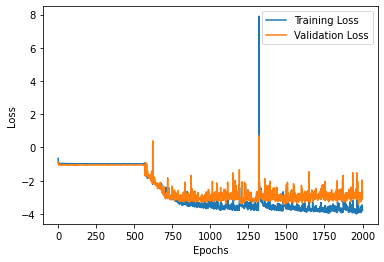

20/20 [==============================] - 1s 52ms/step - loss: -3.3933


20/20 [==============================] - 2s 48ms/step - loss: -3.4796
model number 9


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6688

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 23s 1s/step - loss: -0.6688 - val_loss: -0.8922
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.8936

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -0.8936 - val_loss: -0.9741
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9424

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 983ms/step - loss: -0.9424 - val_loss: -1.0268
Epoch 4/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9521 - val_loss: -1.0034
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9549

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9549 - val_loss: -1.0431
Epoch 6/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9343 - val_loss: -0.9508
Epoch 7/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9457 - val_loss: -1.0407
Epoch 8/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9475 - val_loss: -1.0171
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9588

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 983ms/step - loss: -0.9588 - val_loss: -1.0452
Epoch 10/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9684 - val_loss: -1.0340
Epoch 11/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9653 - val_loss: -1.0304
Epoch 12/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9657 - val_loss: -1.0397
Epoch 13/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9656 - val_loss: -1.0260
Epoch 14/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9679 - val_loss: -1.0433
Epoch 15/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9648 - val_loss: -1.0344
Epoch 16/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9623 - val_loss: -1.0313
Epoch 17/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9677 - val_loss: -1.0408
Epoch 18/2000
15/15 [==============================] - 3s 198ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9707 - val_loss: -1.0496
Epoch 22/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9634 - val_loss: -1.0067
Epoch 23/2000
15/15 [==============================] - ETA: 0s - loss: -0.9669

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 990ms/step - loss: -0.9669 - val_loss: -1.0502
Epoch 24/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9718 - val_loss: -1.0464
Epoch 25/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9660 - val_loss: -1.0386
Epoch 26/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9720 - val_loss: -1.0473
Epoch 27/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9729 - val_loss: -1.0291
Epoch 28/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9642 - val_loss: -1.0480
Epoch 29/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9740 - val_loss: -1.0480
Epoch 30/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9698 - val_loss: -1.0363
Epoch 31/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9698 - val_loss: -1.0499
Epoch 32/2000
15/15 [==============================] - 3s 195ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9719 - val_loss: -1.0502
Epoch 37/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9767 - val_loss: -1.0499
Epoch 38/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9745 - val_loss: -1.0449
Epoch 39/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9749 - val_loss: -1.0437
Epoch 40/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9711 - val_loss: -1.0399
Epoch 41/2000
15/15 [==============================] - ETA: 0s - loss: -0.9648

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9648 - val_loss: -1.0510
Epoch 42/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9791 - val_loss: -1.0439
Epoch 43/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9738 - val_loss: -1.0430
Epoch 44/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9708 - val_loss: -1.0386
Epoch 45/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9731 - val_loss: -1.0460
Epoch 46/2000
15/15 [==============================] - ETA: 0s - loss: -0.9765

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9765 - val_loss: -1.0525
Epoch 47/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9755 - val_loss: -1.0455
Epoch 48/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9679 - val_loss: -1.0473
Epoch 49/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9758 - val_loss: -1.0446
Epoch 50/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9751 - val_loss: -1.0429
Epoch 51/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9710 - val_loss: -1.0452
Epoch 52/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9797 - val_loss: -1.0463
Epoch 53/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9759 - val_loss: -1.0450
Epoch 54/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9772 - val_loss: -1.0520
Epoch 55/2000
15/15 [==============================] - 3s 187ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9729 - val_loss: -1.0527
Epoch 68/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9801 - val_loss: -1.0425
Epoch 69/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9773 - val_loss: -1.0456
Epoch 70/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9799 - val_loss: -1.0492
Epoch 71/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9790 - val_loss: -1.0517
Epoch 72/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9783 - val_loss: -1.0507
Epoch 73/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9787 - val_loss: -1.0520
Epoch 74/2000
15/15 [==============================] - ETA: 0s - loss: -0.9757

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 994ms/step - loss: -0.9757 - val_loss: -1.0533
Epoch 75/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9762 - val_loss: -1.0454
Epoch 76/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9781 - val_loss: -1.0529
Epoch 77/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9783 - val_loss: -1.0518
Epoch 78/2000
15/15 [==============================] - 3s 185ms/step - loss: -0.9802 - val_loss: -1.0385
Epoch 79/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9754 - val_loss: -1.0449
Epoch 80/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9789 - val_loss: -1.0484
Epoch 81/2000
15/15 [==============================] - ETA: 0s - loss: -0.9783

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9783 - val_loss: -1.0538
Epoch 82/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9800 - val_loss: -1.0481
Epoch 83/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9790 - val_loss: -1.0472
Epoch 84/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9791 - val_loss: -1.0479
Epoch 85/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9782 - val_loss: -1.0501
Epoch 86/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9781 - val_loss: -1.0455
Epoch 87/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9729 - val_loss: -1.0517
Epoch 88/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9767 - val_loss: -1.0463
Epoch 89/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9802 - val_loss: -1.0475
Epoch 90/2000
15/15 [==============================] - 3s 196ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9774 - val_loss: -1.0554
Epoch 97/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9791 - val_loss: -1.0435
Epoch 98/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9792 - val_loss: -1.0487
Epoch 99/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9773 - val_loss: -1.0490
Epoch 100/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9776 - val_loss: -1.0523
Epoch 101/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9809 - val_loss: -1.0460
Epoch 102/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9767 - val_loss: -1.0509
Epoch 103/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9779 - val_loss: -1.0467
Epoch 104/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9784 - val_loss: -1.0543
Epoch 105/2000
15/15 [==============================] - 3s 191ms/s

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9807 - val_loss: -1.0574
Epoch 112/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9777 - val_loss: -1.0497
Epoch 113/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9807 - val_loss: -1.0503
Epoch 114/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9764 - val_loss: -1.0445
Epoch 115/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9770 - val_loss: -1.0546
Epoch 116/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9807 - val_loss: -1.0466
Epoch 117/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9809 - val_loss: -1.0499
Epoch 118/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9804 - val_loss: -1.0483
Epoch 119/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9771 - val_loss: -1.0529
Epoch 120/2000
15/15 [==============================] - 3s 195m

15/15 [==============================] - 3s 199ms/step - loss: -0.9823 - val_loss: -1.0512
Epoch 266/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9794 - val_loss: -1.0498
Epoch 267/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9805 - val_loss: -1.0515
Epoch 268/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9808 - val_loss: -1.0515
Epoch 269/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9796 - val_loss: -1.0463
Epoch 270/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9815 - val_loss: -1.0490
Epoch 271/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9802 - val_loss: -1.0526
Epoch 272/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9815 - val_loss: -1.0477
Epoch 273/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9814 - val_loss: -1.0512
Epoch 274/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 200ms/step - loss: -0.9829 - val_loss: -1.0501
Epoch 420/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9800 - val_loss: -1.0440
Epoch 421/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9811 - val_loss: -1.0541
Epoch 422/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9822 - val_loss: -1.0520
Epoch 423/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9812 - val_loss: -1.0496
Epoch 424/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9826 - val_loss: -1.0504
Epoch 425/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9779 - val_loss: -1.0490
Epoch 426/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9770 - val_loss: -1.0513
Epoch 427/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9779 - val_loss: -1.0518
Epoch 428/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 194ms/step - loss: -0.9823 - val_loss: -1.0510
Epoch 574/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9814 - val_loss: -1.0490
Epoch 575/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9811 - val_loss: -1.0489
Epoch 576/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9809 - val_loss: -1.0491
Epoch 577/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9818 - val_loss: -1.0548
Epoch 578/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9809 - val_loss: -1.0509
Epoch 579/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9801 - val_loss: -1.0529
Epoch 580/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9814 - val_loss: -1.0439
Epoch 581/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9808 - val_loss: -1.0470
Epoch 582/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 200ms/step - loss: -0.9818 - val_loss: -1.0546
Epoch 728/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9810 - val_loss: -1.0494
Epoch 729/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9818 - val_loss: -1.0499
Epoch 730/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9828 - val_loss: -1.0529
Epoch 731/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9788 - val_loss: -1.0500
Epoch 732/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9818 - val_loss: -1.0513
Epoch 733/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9807 - val_loss: -1.0530
Epoch 734/2000
15/15 [==============================] - 3s 205ms/step - loss: -0.9817 - val_loss: -1.0544
Epoch 735/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9819 - val_loss: -1.0491
Epoch 736/2000
15/15 [==============================] - 3s 18

15/15 [==============================] - 3s 197ms/step - loss: -0.9819 - val_loss: -1.0527
Epoch 882/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9824 - val_loss: -1.0526
Epoch 883/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9815 - val_loss: -1.0535
Epoch 884/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9816 - val_loss: -1.0477
Epoch 885/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9821 - val_loss: -1.0522
Epoch 886/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9826 - val_loss: -1.0509
Epoch 887/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9823 - val_loss: -1.0527
Epoch 888/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9818 - val_loss: -1.0519
Epoch 889/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9799 - val_loss: -1.0554
Epoch 890/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 197ms/step - loss: -0.9817 - val_loss: -1.0499
Epoch 1036/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9815 - val_loss: -1.0543
Epoch 1037/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9823 - val_loss: -1.0511
Epoch 1038/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9827 - val_loss: -1.0515
Epoch 1039/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9819 - val_loss: -1.0510
Epoch 1040/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9815 - val_loss: -1.0518
Epoch 1041/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9820 - val_loss: -1.0542
Epoch 1042/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9815 - val_loss: -1.0545
Epoch 1043/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9820 - val_loss: -1.0488
Epoch 1044/2000
15/15 [==============================

15/15 [==============================] - 3s 187ms/step - loss: -0.9823 - val_loss: -1.0515
Epoch 1188/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9821 - val_loss: -1.0499
Epoch 1189/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9825 - val_loss: -1.0513
Epoch 1190/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9825 - val_loss: -1.0509
Epoch 1191/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9821 - val_loss: -1.0539
Epoch 1192/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9820 - val_loss: -1.0506
Epoch 1193/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9822 - val_loss: -1.0527
Epoch 1194/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9816 - val_loss: -1.0530
Epoch 1195/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9825 - val_loss: -1.0486
Epoch 1196/2000
15/15 [==============================

15/15 [==============================] - 3s 196ms/step - loss: -0.9823 - val_loss: -1.0507
Epoch 1340/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9820 - val_loss: -1.0523
Epoch 1341/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9826 - val_loss: -1.0508
Epoch 1342/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9830 - val_loss: -1.0555
Epoch 1343/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9834 - val_loss: -1.0548
Epoch 1344/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9825 - val_loss: -1.0504
Epoch 1345/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9839 - val_loss: -1.0547
Epoch 1346/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9850 - val_loss: -1.0532
Epoch 1347/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9825 - val_loss: -1.0503
Epoch 1348/2000
15/15 [==============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 988ms/step - loss: -0.9864 - val_loss: -1.0581
Epoch 1349/2000
15/15 [==============================] - ETA: 0s - loss: -0.9853

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9853 - val_loss: -1.0593
Epoch 1350/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9796 - val_loss: -1.0457
Epoch 1351/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9801 - val_loss: -1.0483
Epoch 1352/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9812 - val_loss: -1.0531
Epoch 1353/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9815 - val_loss: -1.0485
Epoch 1354/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9821 - val_loss: -1.0499
Epoch 1355/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9820 - val_loss: -1.0503
Epoch 1356/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9850 - val_loss: -1.0559
Epoch 1357/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9882 - val_loss: -1.0583
Epoch 1358/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 985ms/step - loss: -0.9899 - val_loss: -1.0623
Epoch 1359/2000
15/15 [==============================] - ETA: 0s - loss: -0.9907

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9907 - val_loss: -1.0647
Epoch 1360/2000
15/15 [==============================] - ETA: 0s - loss: -1.0064

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 989ms/step - loss: -1.0064 - val_loss: -1.1000
Epoch 1361/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.0265 - val_loss: -1.0298
Epoch 1362/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9665 - val_loss: -1.0657
Epoch 1363/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9828 - val_loss: -1.0427
Epoch 1364/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9913 - val_loss: -1.0652
Epoch 1365/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9944 - val_loss: -1.0658
Epoch 1366/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.0012 - val_loss: -1.0821
Epoch 1367/2000
15/15 [==============================] - ETA: 0s - loss: -1.0267

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -1.0267 - val_loss: -1.1250
Epoch 1368/2000
15/15 [==============================] - ETA: 0s - loss: -1.2669

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 979ms/step - loss: -1.2669 - val_loss: -1.4964
Epoch 1369/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9402 - val_loss: -0.9066
Epoch 1370/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9791 - val_loss: -1.0523
Epoch 1371/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.0929 - val_loss: -1.2336
Epoch 1372/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.2284 - val_loss: -0.8085
Epoch 1373/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9183 - val_loss: -1.0573
Epoch 1374/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9861 - val_loss: -1.0604
Epoch 1375/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.0199 - val_loss: -1.1702
Epoch 1376/2000
15/15 [==============================] - 3s 188ms/step - loss: -1.0678 - val_loss: -0.9369
Epoch 1377/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -1.5859 - val_loss: -1.5913
Epoch 1455/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.1807 - val_loss: -1.3923
Epoch 1456/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.1279 - val_loss: -0.9959
Epoch 1457/2000
15/15 [==============================] - 3s 190ms/step - loss: -1.0358 - val_loss: -1.1264
Epoch 1458/2000
15/15 [==============================] - 3s 195ms/step - loss: -1.2625 - val_loss: -1.4224
Epoch 1459/2000
15/15 [==============================] - ETA: 0s - loss: -1.5084

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -1.5084 - val_loss: -1.6877
Epoch 1460/2000
15/15 [==============================] - ETA: 0s - loss: -1.8188

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 987ms/step - loss: -1.8188 - val_loss: -1.7903
Epoch 1461/2000
15/15 [==============================] - ETA: 0s - loss: -1.8847

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -1.8847 - val_loss: -1.8761
Epoch 1462/2000
15/15 [==============================] - ETA: 0s - loss: -1.9933

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 994ms/step - loss: -1.9933 - val_loss: -2.1041
Epoch 1463/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.5103 - val_loss: -1.6695
Epoch 1464/2000
15/15 [==============================] - 3s 187ms/step - loss: -1.8325 - val_loss: -2.0438
Epoch 1465/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.0497 - val_loss: -2.0284
Epoch 1466/2000
15/15 [==============================] - ETA: 0s - loss: -2.1417

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.1417 - val_loss: -2.2453
Epoch 1467/2000
15/15 [==============================] - ETA: 0s - loss: -2.2505

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 1000ms/step - loss: -2.2505 - val_loss: -2.4194
Epoch 1468/2000
15/15 [==============================] - 3s 198ms/step - loss: -1.6966 - val_loss: 0.3103
Epoch 1469/2000
15/15 [==============================] - 3s 192ms/step - loss: -1.0693 - val_loss: -1.3032
Epoch 1470/2000
15/15 [==============================] - 3s 193ms/step - loss: -1.3117 - val_loss: -1.4820
Epoch 1471/2000
15/15 [==============================] - 3s 194ms/step - loss: -1.6342 - val_loss: -1.7121
Epoch 1472/2000
15/15 [==============================] - 3s 189ms/step - loss: -1.8563 - val_loss: -2.1020
Epoch 1473/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2121 - val_loss: -2.3375
Epoch 1474/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.4323 - val_loss: -2.0697
Epoch 1475/2000
15/15 [==============================] - 3s 191ms/step - loss: -1.5251 - val_loss: -1.9995
Epoch 1476/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.3543 - val_loss: -2.4366
Epoch 1480/2000
15/15 [==============================] - ETA: 0s - loss: -2.4384

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 990ms/step - loss: -2.4384 - val_loss: -2.4414
Epoch 1481/2000
15/15 [==============================] - ETA: 0s - loss: -2.5032

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.5032 - val_loss: -2.6493
Epoch 1482/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.5736 - val_loss: -2.4120
Epoch 1483/2000
15/15 [==============================] - 3s 202ms/step - loss: -2.2126 - val_loss: -1.2079
Epoch 1484/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.1531 - val_loss: -2.2663
Epoch 1485/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.3127 - val_loss: -2.4191
Epoch 1486/2000
15/15 [==============================] - 3s 205ms/step - loss: -2.4571 - val_loss: -2.5595
Epoch 1487/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.4203 - val_loss: -2.3208
Epoch 1488/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.3585 - val_loss: -2.5660
Epoch 1489/2000
15/15 [==============================] - ETA: 0s - loss: -2.4638

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.4638 - val_loss: -2.6627
Epoch 1490/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.5702 - val_loss: -2.6369
Epoch 1491/2000
15/15 [==============================] - ETA: 0s - loss: -2.5084

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 1s/step - loss: -2.5084 - val_loss: -2.6713
Epoch 1492/2000
15/15 [==============================] - ETA: 0s - loss: -2.6927

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.6927 - val_loss: -2.8083
Epoch 1493/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.3900 - val_loss: -1.9466
Epoch 1494/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.2839 - val_loss: -2.2438
Epoch 1495/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.3184 - val_loss: -2.4792
Epoch 1496/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.5090 - val_loss: -2.6474
Epoch 1497/2000
15/15 [==============================] - 3s 200ms/step - loss: -2.5935 - val_loss: -2.7616
Epoch 1498/2000
15/15 [==============================] - ETA: 0s - loss: -2.7043

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 989ms/step - loss: -2.7043 - val_loss: -2.8273
Epoch 1499/2000
15/15 [==============================] - ETA: 0s - loss: -2.7214

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.7214 - val_loss: -2.8466
Epoch 1500/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.2723 - val_loss: -1.8413
Epoch 1501/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.2728 - val_loss: -2.5858
Epoch 1502/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.5547 - val_loss: -2.6708
Epoch 1503/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.6556 - val_loss: -2.7500
Epoch 1504/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.6451 - val_loss: -2.7180
Epoch 1505/2000
15/15 [==============================] - ETA: 0s - loss: -2.6886

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 992ms/step - loss: -2.6886 - val_loss: -2.8590
Epoch 1506/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7826 - val_loss: -2.7504
Epoch 1507/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8434 - val_loss: -2.8192
Epoch 1508/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.7800 - val_loss: -2.8501
Epoch 1509/2000
15/15 [==============================] - 3s 188ms/step - loss: -2.6677 - val_loss: -2.2467
Epoch 1510/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.6320 - val_loss: -2.5797
Epoch 1511/2000
15/15 [==============================] - ETA: 0s - loss: -2.7897

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.7897 - val_loss: -2.8685
Epoch 1512/2000
15/15 [==============================] - ETA: 0s - loss: -2.8570

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 981ms/step - loss: -2.8570 - val_loss: -2.8958
Epoch 1513/2000
15/15 [==============================] - 3s 189ms/step - loss: -2.8548 - val_loss: -2.6897
Epoch 1514/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.7925 - val_loss: -2.3179
Epoch 1515/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7152 - val_loss: -2.8344
Epoch 1516/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8262 - val_loss: -2.7784
Epoch 1517/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7335 - val_loss: -2.8777
Epoch 1518/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7635 - val_loss: -2.7550
Epoch 1519/2000
15/15 [==============================] - 3s 190ms/step - loss: -2.7665 - val_loss: -2.7578
Epoch 1520/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.7913 - val_loss: -2.8646
Epoch 1521/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.7837 - val_loss: -2.9003
Epoch 1527/2000
15/15 [==============================] - ETA: 0s - loss: -2.9119

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 990ms/step - loss: -2.9119 - val_loss: -2.9232
Epoch 1528/2000
15/15 [==============================] - ETA: 0s - loss: -2.9445

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -2.9445 - val_loss: -2.9671
Epoch 1529/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.9527 - val_loss: -2.8727
Epoch 1530/2000
15/15 [==============================] - 3s 193ms/step - loss: -2.7562 - val_loss: -2.7452
Epoch 1531/2000
15/15 [==============================] - 3s 199ms/step - loss: -2.9223 - val_loss: -2.9106
Epoch 1532/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9499 - val_loss: -2.8796
Epoch 1533/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.7571 - val_loss: -2.6687
Epoch 1534/2000
15/15 [==============================] - 3s 196ms/step - loss: -2.8291 - val_loss: -2.8676
Epoch 1535/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.9593 - val_loss: -2.8822
Epoch 1536/2000
15/15 [==============================] - 3s 198ms/step - loss: -2.9054 - val_loss: -2.9095
Epoch 1537/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 990ms/step - loss: -2.9674 - val_loss: -3.0467
Epoch 1539/2000
15/15 [==============================] - ETA: 0s - loss: -3.0676

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.0676 - val_loss: -3.0812
Epoch 1540/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.8173 - val_loss: -2.8750
Epoch 1541/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.7847 - val_loss: -2.8877
Epoch 1542/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0020 - val_loss: -3.0165
Epoch 1543/2000
15/15 [==============================] - 3s 186ms/step - loss: -3.0394 - val_loss: -3.0125
Epoch 1544/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.0464 - val_loss: -3.0487
Epoch 1545/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.8141 - val_loss: -2.5934
Epoch 1546/2000
15/15 [==============================] - 3s 203ms/step - loss: -2.5555 - val_loss: -2.6441
Epoch 1547/2000
15/15 [==============================] - 3s 192ms/step - loss: -2.8054 - val_loss: -2.8765
Epoch 1548/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -3.0500 - val_loss: -3.0903
Epoch 1558/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1386 - val_loss: -3.0585
Epoch 1559/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0490 - val_loss: -2.9501
Epoch 1560/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.0321 - val_loss: -2.9692
Epoch 1561/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0822 - val_loss: -2.8768
Epoch 1562/2000
15/15 [==============================] - ETA: 0s - loss: -3.0799

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 988ms/step - loss: -3.0799 - val_loss: -3.0934
Epoch 1563/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1512 - val_loss: -3.0519
Epoch 1564/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.1623 - val_loss: -3.0830
Epoch 1565/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1479 - val_loss: -3.0800
Epoch 1566/2000
15/15 [==============================] - ETA: 0s - loss: -3.1500

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.1500 - val_loss: -3.1090
Epoch 1567/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0301 - val_loss: -2.9908
Epoch 1568/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0644 - val_loss: -2.9886
Epoch 1569/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.1153 - val_loss: -3.0720
Epoch 1570/2000
15/15 [==============================] - ETA: 0s - loss: -3.1559

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 986ms/step - loss: -3.1559 - val_loss: -3.1331
Epoch 1571/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1879 - val_loss: -3.0806
Epoch 1572/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1338 - val_loss: -2.7603
Epoch 1573/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.0697 - val_loss: -3.0712
Epoch 1574/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.1153 - val_loss: -3.0773
Epoch 1575/2000
15/15 [==============================] - 3s 201ms/step - loss: -2.9657 - val_loss: -2.9828
Epoch 1576/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.9282 - val_loss: -2.8477
Epoch 1577/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.0133 - val_loss: -2.8905
Epoch 1578/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.0382 - val_loss: -2.9892
Epoch 1579/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.1878 - val_loss: -3.1658
Epoch 1580/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.1601 - val_loss: -2.4776
Epoch 1581/2000
15/15 [==============================] - ETA: 0s - loss: -3.1098

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 980ms/step - loss: -3.1098 - val_loss: -3.1767
Epoch 1582/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.0610 - val_loss: -2.9918
Epoch 1583/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.2066 - val_loss: -3.0777
Epoch 1584/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.2098 - val_loss: -3.1049
Epoch 1585/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.0875 - val_loss: -2.9982
Epoch 1586/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.1018 - val_loss: -3.0883
Epoch 1587/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0810 - val_loss: -2.8513
Epoch 1588/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1030 - val_loss: -3.1017
Epoch 1589/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.2378 - val_loss: -3.0369
Epoch 1590/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.3006 - val_loss: -3.1850
Epoch 1600/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.2946 - val_loss: -3.0469
Epoch 1601/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2177 - val_loss: -2.7883
Epoch 1602/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.0397 - val_loss: -3.1567
Epoch 1603/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.1973 - val_loss: -3.1189
Epoch 1604/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.0674 - val_loss: -3.1585
Epoch 1605/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1873 - val_loss: -3.1664
Epoch 1606/2000
15/15 [==============================] - ETA: 0s - loss: -3.2527

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 984ms/step - loss: -3.2527 - val_loss: -3.2034
Epoch 1607/2000
15/15 [==============================] - 3s 202ms/step - loss: -3.3231 - val_loss: -3.1451
Epoch 1608/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3571 - val_loss: -3.1903
Epoch 1609/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3498 - val_loss: -3.1574
Epoch 1610/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3292 - val_loss: -3.0121
Epoch 1611/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.0332 - val_loss: -3.1378
Epoch 1612/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.0637 - val_loss: -2.7751
Epoch 1613/2000
15/15 [==============================] - 3s 191ms/step - loss: -2.9118 - val_loss: -2.9111
Epoch 1614/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.1539 - val_loss: -3.0709
Epoch 1615/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -3.1886 - val_loss: -3.2285
Epoch 1616/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.1045 - val_loss: -2.7724
Epoch 1617/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.1833 - val_loss: -3.1536
Epoch 1618/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.3216 - val_loss: -3.2178
Epoch 1619/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.3773 - val_loss: -3.1801
Epoch 1620/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.3274 - val_loss: -3.0760
Epoch 1621/2000
15/15 [==============================] - 3s 194ms/step - loss: -2.7422 - val_loss: -2.4559
Epoch 1622/2000
15/15 [==============================] - 3s 195ms/step - loss: -2.8092 - val_loss: -2.9077
Epoch 1623/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.0775 - val_loss: -3.0748
Epoch 1624/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 16s 1s/step - loss: -3.2826 - val_loss: -3.2380
Epoch 1628/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3789 - val_loss: -3.2127
Epoch 1629/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4381 - val_loss: -3.1733
Epoch 1630/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4061 - val_loss: -3.1409
Epoch 1631/2000
15/15 [==============================] - 3s 203ms/step - loss: -3.4681 - val_loss: -3.0416
Epoch 1632/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.4003 - val_loss: -3.1166
Epoch 1633/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3257 - val_loss: -3.1600
Epoch 1634/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.1778 - val_loss: -3.1172
Epoch 1635/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.1719 - val_loss: -3.1305
Epoch 1636/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 994ms/step - loss: -3.4739 - val_loss: -3.2589
Epoch 1647/2000
15/15 [==============================] - 3s 198ms/step - loss: -3.4693 - val_loss: -2.8315
Epoch 1648/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3204 - val_loss: -3.2457
Epoch 1649/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.2994 - val_loss: -3.0900
Epoch 1650/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.3178 - val_loss: -2.9714
Epoch 1651/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.2746 - val_loss: -3.0108
Epoch 1652/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.3236 - val_loss: -3.2385
Epoch 1653/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3409 - val_loss: -3.2205
Epoch 1654/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.2725 - val_loss: -3.1221
Epoch 1655/2000
15/15 [=============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.3696 - val_loss: -3.2652
Epoch 1742/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.4451 - val_loss: -3.0965
Epoch 1743/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5060 - val_loss: -3.0930
Epoch 1744/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4559 - val_loss: -3.2094
Epoch 1745/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.3892 - val_loss: -2.3922
Epoch 1746/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.1358 - val_loss: -2.7747
Epoch 1747/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.2359 - val_loss: -2.9883
Epoch 1748/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.2807 - val_loss: -3.2425
Epoch 1749/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.3670 - val_loss: -3.2121
Epoch 1750/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 997ms/step - loss: -3.5594 - val_loss: -3.2804
Epoch 1759/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.5563 - val_loss: -2.5662
Epoch 1760/2000
15/15 [==============================] - 3s 206ms/step - loss: -3.3136 - val_loss: -3.1110
Epoch 1761/2000
15/15 [==============================] - ETA: 0s - loss: -3.2542

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.2542 - val_loss: -3.2939
Epoch 1762/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3884 - val_loss: -3.2482
Epoch 1763/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.5274 - val_loss: -3.1594
Epoch 1764/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5718 - val_loss: -2.9709
Epoch 1765/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.4830 - val_loss: -2.8928
Epoch 1766/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.5754 - val_loss: -3.0204
Epoch 1767/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5822 - val_loss: -3.0754
Epoch 1768/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.5302 - val_loss: -2.7402
Epoch 1769/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.4120 - val_loss: -3.0325
Epoch 1770/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 990ms/step - loss: -3.4449 - val_loss: -3.3172
Epoch 1773/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.5182 - val_loss: -3.1009
Epoch 1774/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.5221 - val_loss: -3.1722
Epoch 1775/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.5093 - val_loss: -3.1319
Epoch 1776/2000
15/15 [==============================] - 3s 195ms/step - loss: -3.4918 - val_loss: -3.1868
Epoch 1777/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.3003 - val_loss: -2.2998
Epoch 1778/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.1519 - val_loss: -3.0755
Epoch 1779/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.4007 - val_loss: -3.0773
Epoch 1780/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.4932 - val_loss: -2.9739
Epoch 1781/2000
15/15 [=============================

15/15 [==============================] - 3s 195ms/step - loss: -3.4418 - val_loss: -2.3757
Epoch 1925/2000
15/15 [==============================] - 3s 193ms/step - loss: -3.2522 - val_loss: -3.2606
Epoch 1926/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.3844 - val_loss: -3.1641
Epoch 1927/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.5727 - val_loss: -3.3094
Epoch 1928/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.6889 - val_loss: -3.2339
Epoch 1929/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7443 - val_loss: -3.1406
Epoch 1930/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.7100 - val_loss: -2.9455
Epoch 1931/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.6974 - val_loss: -3.2214
Epoch 1932/2000
15/15 [==============================] - 3s 192ms/step - loss: -3.8177 - val_loss: -3.1697
Epoch 1933/2000
15/15 [==============================

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 17s 1s/step - loss: -3.4556 - val_loss: -3.3382
Epoch 1948/2000
15/15 [==============================] - 3s 190ms/step - loss: -3.4700 - val_loss: -3.2691
Epoch 1949/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.2991 - val_loss: -3.1122
Epoch 1950/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.4392 - val_loss: -3.1142
Epoch 1951/2000
15/15 [==============================] - 3s 188ms/step - loss: -3.6701 - val_loss: -3.0319
Epoch 1952/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7391 - val_loss: -2.9582
Epoch 1953/2000
15/15 [==============================] - 3s 194ms/step - loss: -3.7656 - val_loss: -3.0600
Epoch 1954/2000
15/15 [==============================] - 3s 201ms/step - loss: -3.7780 - val_loss: -2.8639
Epoch 1955/2000
15/15 [==============================] - 3s 197ms/step - loss: -3.7761 - val_loss: -2.9734
Epoch 1956/2000
15/15 [==============================] 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel9/assets


15/15 [==============================] - 14s 986ms/step - loss: -3.5620 - val_loss: -3.3646
Epoch 1970/2000
15/15 [==============================] - 3s 199ms/step - loss: -3.7423 - val_loss: -3.2122
Epoch 1971/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7063 - val_loss: -3.2222
Epoch 1972/2000
15/15 [==============================] - 3s 191ms/step - loss: -3.7919 - val_loss: -3.1288
Epoch 1973/2000
15/15 [==============================] - 3s 200ms/step - loss: -3.8072 - val_loss: -2.9850
Epoch 1974/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.8084 - val_loss: -2.8198
Epoch 1975/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.7287 - val_loss: -3.1884
Epoch 1976/2000
15/15 [==============================] - 3s 189ms/step - loss: -3.8162 - val_loss: -3.1667
Epoch 1977/2000
15/15 [==============================] - 3s 196ms/step - loss: -3.8197 - val_loss: -2.9840
Epoch 1978/2000
15/15 [=============================

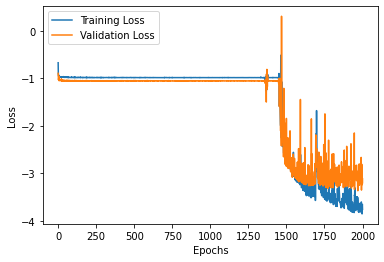

20/20 [==============================] - 1s 50ms/step - loss: -3.6027


20/20 [==============================] - 2s 44ms/step - loss: -3.5893
model number 10


Epoch 1/2000
15/15 [==============================] - ETA: 0s - loss: -0.6328

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 22s 1s/step - loss: -0.6328 - val_loss: -0.9503
Epoch 2/2000
15/15 [==============================] - ETA: 0s - loss: -0.9129

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 989ms/step - loss: -0.9129 - val_loss: -1.0308
Epoch 3/2000
15/15 [==============================] - ETA: 0s - loss: -0.9580

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9580 - val_loss: -1.0326
Epoch 4/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9535 - val_loss: -0.9965
Epoch 5/2000
15/15 [==============================] - ETA: 0s - loss: -0.9532

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 988ms/step - loss: -0.9532 - val_loss: -1.0379
Epoch 6/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9364 - val_loss: -0.9244
Epoch 7/2000
15/15 [==============================] - ETA: 0s - loss: -0.9298

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9298 - val_loss: -1.0411
Epoch 8/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9461 - val_loss: -1.0046
Epoch 9/2000
15/15 [==============================] - ETA: 0s - loss: -0.9523

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 993ms/step - loss: -0.9523 - val_loss: -1.0432
Epoch 10/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9657 - val_loss: -1.0303
Epoch 11/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9631 - val_loss: -1.0325
Epoch 12/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9655 - val_loss: -1.0371
Epoch 13/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9637 - val_loss: -1.0244
Epoch 14/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9654 - val_loss: -1.0430
Epoch 15/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9624 - val_loss: -1.0277
Epoch 16/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9613 - val_loss: -1.0393
Epoch 17/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9661 - val_loss: -1.0367
Epoch 18/2000
15/15 [==============================] - 3s 194ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9684 - val_loss: -1.0460
Epoch 22/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9640 - val_loss: -1.0095
Epoch 23/2000
15/15 [==============================] - ETA: 0s - loss: -0.9641

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 1s/step - loss: -0.9641 - val_loss: -1.0491
Epoch 24/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9713 - val_loss: -1.0457
Epoch 25/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9628 - val_loss: -1.0335
Epoch 26/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9702 - val_loss: -1.0448
Epoch 27/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9735 - val_loss: -1.0302
Epoch 28/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9606 - val_loss: -1.0440
Epoch 29/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9736 - val_loss: -1.0486
Epoch 30/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9684 - val_loss: -1.0327
Epoch 31/2000
15/15 [==============================] - ETA: 0s - loss: -0.9660

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9660 - val_loss: -1.0500
Epoch 32/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9707 - val_loss: -1.0433
Epoch 33/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9722 - val_loss: -1.0484
Epoch 34/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9652 - val_loss: -1.0307
Epoch 35/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9546 - val_loss: -1.0398
Epoch 36/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9723 - val_loss: -1.0471
Epoch 37/2000
15/15 [==============================] - ETA: 0s - loss: -0.9766

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 994ms/step - loss: -0.9766 - val_loss: -1.0510
Epoch 38/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9743 - val_loss: -1.0428
Epoch 39/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9742 - val_loss: -1.0447
Epoch 40/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9711 - val_loss: -1.0407
Epoch 41/2000
15/15 [==============================] - ETA: 0s - loss: -0.9628

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9628 - val_loss: -1.0517
Epoch 42/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9781 - val_loss: -1.0432
Epoch 43/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9736 - val_loss: -1.0440
Epoch 44/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9695 - val_loss: -1.0350
Epoch 45/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9702 - val_loss: -1.0468
Epoch 46/2000
15/15 [==============================] - ETA: 0s - loss: -0.9756

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 989ms/step - loss: -0.9756 - val_loss: -1.0522
Epoch 47/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9754 - val_loss: -1.0450
Epoch 48/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9664 - val_loss: -1.0484
Epoch 49/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9759 - val_loss: -1.0431
Epoch 50/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9745 - val_loss: -1.0439
Epoch 51/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9706 - val_loss: -1.0459
Epoch 52/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9803 - val_loss: -1.0449
Epoch 53/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9753 - val_loss: -1.0448
Epoch 54/2000
15/15 [==============================] - ETA: 0s - loss: -0.9768

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9768 - val_loss: -1.0524
Epoch 55/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9733 - val_loss: -1.0487
Epoch 56/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9761 - val_loss: -1.0402
Epoch 57/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9653 - val_loss: -1.0458
Epoch 58/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9753 - val_loss: -1.0503
Epoch 59/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9754 - val_loss: -1.0408
Epoch 60/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9765 - val_loss: -1.0508
Epoch 61/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9756 - val_loss: -1.0483
Epoch 62/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9735 - val_loss: -1.0469
Epoch 63/2000
15/15 [==============================] - 3s 199ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 16s 1s/step - loss: -0.9811 - val_loss: -1.0526
Epoch 67/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9722 - val_loss: -1.0525
Epoch 68/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9796 - val_loss: -1.0412
Epoch 69/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9767 - val_loss: -1.0457
Epoch 70/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9795 - val_loss: -1.0492
Epoch 71/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9785 - val_loss: -1.0509
Epoch 72/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9778 - val_loss: -1.0507
Epoch 73/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9783 - val_loss: -1.0518
Epoch 74/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9755 - val_loss: -1.0523
Epoch 75/2000
15/15 [==============================] - 3s 196ms/step - 

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 984ms/step - loss: -0.9777 - val_loss: -1.0539
Epoch 82/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9798 - val_loss: -1.0475
Epoch 83/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9784 - val_loss: -1.0467
Epoch 84/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9788 - val_loss: -1.0477
Epoch 85/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9775 - val_loss: -1.0494
Epoch 86/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9775 - val_loss: -1.0441
Epoch 87/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9714 - val_loss: -1.0518
Epoch 88/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9765 - val_loss: -1.0458
Epoch 89/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9796 - val_loss: -1.0470
Epoch 90/2000
15/15 [==============================] - 3s 192ms/step

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 17s 1s/step - loss: -0.9771 - val_loss: -1.0554
Epoch 97/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9784 - val_loss: -1.0421
Epoch 98/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9786 - val_loss: -1.0491
Epoch 99/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9759 - val_loss: -1.0479
Epoch 100/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9761 - val_loss: -1.0526
Epoch 101/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9805 - val_loss: -1.0449
Epoch 102/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9753 - val_loss: -1.0507
Epoch 103/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9777 - val_loss: -1.0466
Epoch 104/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9778 - val_loss: -1.0534
Epoch 105/2000
15/15 [==============================] - 3s 198ms/s

INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


INFO:tensorflow:Assets written to: ../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel10/assets


15/15 [==============================] - 14s 994ms/step - loss: -0.9805 - val_loss: -1.0571
Epoch 112/2000
15/15 [==============================] - 3s 205ms/step - loss: -0.9774 - val_loss: -1.0503
Epoch 113/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9798 - val_loss: -1.0492
Epoch 114/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9760 - val_loss: -1.0444
Epoch 115/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9763 - val_loss: -1.0547
Epoch 116/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9801 - val_loss: -1.0451
Epoch 117/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9808 - val_loss: -1.0497
Epoch 118/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9797 - val_loss: -1.0480
Epoch 119/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9767 - val_loss: -1.0528
Epoch 120/2000
15/15 [==============================] - 3s 1

15/15 [==============================] - 3s 188ms/step - loss: -0.9823 - val_loss: -1.0513
Epoch 266/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9789 - val_loss: -1.0497
Epoch 267/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9800 - val_loss: -1.0514
Epoch 268/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9807 - val_loss: -1.0520
Epoch 269/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9790 - val_loss: -1.0454
Epoch 270/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9814 - val_loss: -1.0486
Epoch 271/2000
15/15 [==============================] - 3s 201ms/step - loss: -0.9799 - val_loss: -1.0529
Epoch 272/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9814 - val_loss: -1.0478
Epoch 273/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9812 - val_loss: -1.0512
Epoch 274/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 196ms/step - loss: -0.9829 - val_loss: -1.0502
Epoch 420/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9801 - val_loss: -1.0442
Epoch 421/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9811 - val_loss: -1.0539
Epoch 422/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9821 - val_loss: -1.0521
Epoch 423/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9810 - val_loss: -1.0498
Epoch 424/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9827 - val_loss: -1.0502
Epoch 425/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9774 - val_loss: -1.0486
Epoch 426/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9760 - val_loss: -1.0506
Epoch 427/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9769 - val_loss: -1.0518
Epoch 428/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 198ms/step - loss: -0.9823 - val_loss: -1.0511
Epoch 574/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9814 - val_loss: -1.0490
Epoch 575/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9810 - val_loss: -1.0486
Epoch 576/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9808 - val_loss: -1.0489
Epoch 577/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9817 - val_loss: -1.0548
Epoch 578/2000
15/15 [==============================] - 3s 188ms/step - loss: -0.9808 - val_loss: -1.0510
Epoch 579/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9801 - val_loss: -1.0529
Epoch 580/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9814 - val_loss: -1.0441
Epoch 581/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9806 - val_loss: -1.0466
Epoch 582/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 197ms/step - loss: -0.9818 - val_loss: -1.0545
Epoch 728/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9809 - val_loss: -1.0496
Epoch 729/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9817 - val_loss: -1.0498
Epoch 730/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9828 - val_loss: -1.0528
Epoch 731/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9785 - val_loss: -1.0500
Epoch 732/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9816 - val_loss: -1.0512
Epoch 733/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9808 - val_loss: -1.0532
Epoch 734/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9816 - val_loss: -1.0544
Epoch 735/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9818 - val_loss: -1.0493
Epoch 736/2000
15/15 [==============================] - 3s 20

15/15 [==============================] - 3s 192ms/step - loss: -0.9818 - val_loss: -1.0526
Epoch 882/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9824 - val_loss: -1.0528
Epoch 883/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9815 - val_loss: -1.0535
Epoch 884/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9817 - val_loss: -1.0480
Epoch 885/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9821 - val_loss: -1.0520
Epoch 886/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9826 - val_loss: -1.0510
Epoch 887/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9823 - val_loss: -1.0526
Epoch 888/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9818 - val_loss: -1.0519
Epoch 889/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9799 - val_loss: -1.0552
Epoch 890/2000
15/15 [==============================] - 3s 19

15/15 [==============================] - 3s 200ms/step - loss: -0.9817 - val_loss: -1.0500
Epoch 1036/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9816 - val_loss: -1.0542
Epoch 1037/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9822 - val_loss: -1.0513
Epoch 1038/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9827 - val_loss: -1.0515
Epoch 1039/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9818 - val_loss: -1.0510
Epoch 1040/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9815 - val_loss: -1.0519
Epoch 1041/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9820 - val_loss: -1.0541
Epoch 1042/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9816 - val_loss: -1.0545
Epoch 1043/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9820 - val_loss: -1.0492
Epoch 1044/2000
15/15 [==============================

15/15 [==============================] - 3s 195ms/step - loss: -0.9823 - val_loss: -1.0515
Epoch 1188/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9822 - val_loss: -1.0501
Epoch 1189/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9825 - val_loss: -1.0512
Epoch 1190/2000
15/15 [==============================] - 3s 187ms/step - loss: -0.9825 - val_loss: -1.0508
Epoch 1191/2000
15/15 [==============================] - 3s 190ms/step - loss: -0.9821 - val_loss: -1.0538
Epoch 1192/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9819 - val_loss: -1.0509
Epoch 1193/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9822 - val_loss: -1.0527
Epoch 1194/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9816 - val_loss: -1.0530
Epoch 1195/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9825 - val_loss: -1.0489
Epoch 1196/2000
15/15 [==============================

15/15 [==============================] - 3s 197ms/step - loss: -0.9823 - val_loss: -1.0509
Epoch 1340/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9820 - val_loss: -1.0524
Epoch 1341/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9818 - val_loss: -1.0496
Epoch 1342/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9814 - val_loss: -1.0538
Epoch 1343/2000
15/15 [==============================] - 3s 189ms/step - loss: -0.9820 - val_loss: -1.0537
Epoch 1344/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9809 - val_loss: -1.0491
Epoch 1345/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9817 - val_loss: -1.0523
Epoch 1346/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9823 - val_loss: -1.0517
Epoch 1347/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9811 - val_loss: -1.0475
Epoch 1348/2000
15/15 [==============================

15/15 [==============================] - 3s 202ms/step - loss: -0.9822 - val_loss: -1.0525
Epoch 1492/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9807 - val_loss: -1.0510
Epoch 1493/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9824 - val_loss: -1.0507
Epoch 1494/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9816 - val_loss: -1.0516
Epoch 1495/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9817 - val_loss: -1.0506
Epoch 1496/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9813 - val_loss: -1.0509
Epoch 1497/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9823 - val_loss: -1.0499
Epoch 1498/2000
15/15 [==============================] - 3s 202ms/step - loss: -0.9823 - val_loss: -1.0506
Epoch 1499/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9821 - val_loss: -1.0526
Epoch 1500/2000
15/15 [==============================

15/15 [==============================] - 3s 199ms/step - loss: -0.9821 - val_loss: -1.0528
Epoch 1644/2000
15/15 [==============================] - 3s 199ms/step - loss: -0.9822 - val_loss: -1.0494
Epoch 1645/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9826 - val_loss: -1.0506
Epoch 1646/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9818 - val_loss: -1.0500
Epoch 1647/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9821 - val_loss: -1.0518
Epoch 1648/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9813 - val_loss: -1.0505
Epoch 1649/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9824 - val_loss: -1.0499
Epoch 1650/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9817 - val_loss: -1.0518
Epoch 1651/2000
15/15 [==============================] - 3s 196ms/step - loss: -0.9826 - val_loss: -1.0493
Epoch 1652/2000
15/15 [==============================

15/15 [==============================] - 3s 193ms/step - loss: -0.9821 - val_loss: -1.0506
Epoch 1796/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9828 - val_loss: -1.0519
Epoch 1797/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9827 - val_loss: -1.0518
Epoch 1798/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9822 - val_loss: -1.0540
Epoch 1799/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9807 - val_loss: -1.0512
Epoch 1800/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9824 - val_loss: -1.0510
Epoch 1801/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9826 - val_loss: -1.0508
Epoch 1802/2000
15/15 [==============================] - 3s 197ms/step - loss: -0.9818 - val_loss: -1.0516
Epoch 1803/2000
15/15 [==============================] - 3s 195ms/step - loss: -0.9819 - val_loss: -1.0512
Epoch 1804/2000
15/15 [==============================

15/15 [==============================] - 3s 197ms/step - loss: -0.9827 - val_loss: -1.0517
Epoch 1948/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9822 - val_loss: -1.0482
Epoch 1949/2000
15/15 [==============================] - 3s 186ms/step - loss: -0.9820 - val_loss: -1.0511
Epoch 1950/2000
15/15 [==============================] - 3s 192ms/step - loss: -0.9825 - val_loss: -1.0520
Epoch 1951/2000
15/15 [==============================] - 3s 191ms/step - loss: -0.9825 - val_loss: -1.0508
Epoch 1952/2000
15/15 [==============================] - 3s 193ms/step - loss: -0.9825 - val_loss: -1.0515
Epoch 1953/2000
15/15 [==============================] - 3s 194ms/step - loss: -0.9826 - val_loss: -1.0508
Epoch 1954/2000
15/15 [==============================] - 3s 198ms/step - loss: -0.9823 - val_loss: -1.0499
Epoch 1955/2000
15/15 [==============================] - 3s 200ms/step - loss: -0.9823 - val_loss: -1.0524
Epoch 1956/2000
15/15 [==============================

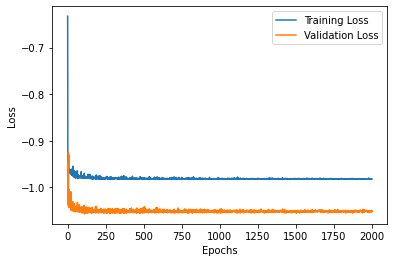

20/20 [==============================] - 1s 46ms/step - loss: -1.0001


20/20 [==============================] - 2s 54ms/step - loss: -0.9986


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

NumEnsemble = 10
SequenceLength = 250
validation_split = 0.25
batch_size = 16
NumEpochs = 2000
test_split = 0.2

reconstructed_model = keras.models.load_model("../Models/SimulatedDataPretrainedModel",custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

reconstructed_model.trainable = False

df = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=0)

labels = df.iloc[:,0]
df_data = df.iloc[:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

train_labels = df_train.iloc[:,0]

df_train, df_val = train_test_split(df_train, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=train_labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)
df_norm_val = (df_val - min_value)/(max_value - min_value)

models = list()

for i in range(NumEnsemble):
    
    df_norm_train = df_norm_train.sample(frac=1)
    df_norm_val = df_norm_val.sample(frac=1)
    
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)

    X_val = df_norm_val.iloc[:,:SequenceLength].values
    y_val = df_norm_val.iloc[:,SequenceLength-1].values
    X_val = np.expand_dims(X_val, 2)
    y_val = np.broadcast_to(y_val[:,None], (y_val.shape[0],SequenceLength))
    y_val = np.expand_dims(y_val, 2)
    
    print("model number " + str(i+1))
    model = keras.models.Sequential()

    for layer in reconstructed_model.layers[:-1]:
            model.add(layer)
    for layer in model.layers:
            layer.trainable = False
    model.add(keras.layers.LSTM(500, return_sequences=True,stateful=False, name = "first_lstm_layer"))
    model.add(keras.layers.LSTM(5, return_sequences=True,stateful=False, name = "second_lstm_layer"))
    model.add(keras.layers.LSTM(200, return_sequences=True,stateful=False, name = "third_lstm_layer"))
    model.add(keras.layers.LSTM(2, activation='softplus',return_sequences=True,stateful=False, name = "output_layer"))
    
    checkpoint_filepath = r"../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
        
    model.compile(optimizer="adam",loss = MeanVarianceLogLikelyhoodLoss)

    history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val,y_val), epochs=NumEpochs, callbacks=[model_checkpoint_callback])

    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)
    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    model.evaluate(X_train,y_train,batch_size=batch_size) #min loss shold be -6.908
    
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    bestModel.evaluate(X_train, y_train, batch_size=batch_size)
    
    models.append(model)